#Predicting Lung Cancer through Machine Learning Approach

##1.Project Overview

The goal of this project is to develop a machine learning model to accurately predict lung cancer based on a dataset containing 32 instances with 56 integer-based features. Given the small number of samples and the relatively high number of features, the project will address the challenge of developing a robust and generalizable classification model.



##2.Data Information

https://archive.ics.uci.edu/dataset/62/lung+cancer

##3.Data Inspecting and Preprocessing

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [2]:
!pip install logitboost

In [3]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 5.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from logitboost import LogitBoost
import warnings
warnings.filterwarnings("ignore")

In [5]:
pip install ucimlrepo

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
lung_cancer = fetch_ucirepo(id=62)

# data (as pandas dataframes)
X = lung_cancer.data.features
y = lung_cancer.data.targets

# metadata
print(lung_cancer.metadata)

# variable information
print(lung_cancer.variables)

{'uci_id': 62, 'name': 'Lung Cancer', 'repository_url': 'https://archive.ics.uci.edu/dataset/62/lung+cancer', 'data_url': 'https://archive.ics.uci.edu/static/public/62/data.csv', 'abstract': 'Lung cancer data; no attribute definitions', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 32, 'num_features': 56, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1991, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C57596', 'creators': ['Z.Q. Hong', 'J.Y Yang'], 'intro_paper': None, 'additional_info': {'summary': "This data was used by Hong and Young to illustrate the power of the optimal discriminant plane even in ill-posed settings. Applying the KNN method in the resulting plane gave 77% accuracy. However, these results are strongly biased (See Aeberhard's second ref. above, or emai

In [7]:
# Concatenates X and y into the DataFrames
df = pd.concat([X, y], axis=1)

# Display the first few rows of the combined DataFrame
df.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0           0           3           0         NaN           0           2   
1           0           3           3         1.0           0           3   
2           0           3           3         2.0           0           3   
3           0           2           3         2.0           1           3   
4           0           3           2         1.0           1           3   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute48  \
0           2           2           1            1  ...            2   
1           1           3           1            1  ...            2   
2           3           3           1            1  ...            2   
3           3           3           1            2  ...            2   
4           3           3           2            2  ...            2   

   Attribute49  Attribute50  Attribute51  Attribute52  Attribute53  \
0            2            2            2            1            1   
1            2            2            2            2            2   
2            2            2            2            2            2   
3            2            2            2            2            2   
4            2            2            2            2            2   

   Attribute54  Attribute55  Attribute56  class  
0            1            2            2      1  
1            1            2            2      1  
2            2            1            2      1  
3            2            2            2      1  
4            1            2            2      1  

[5 rows x 57 columns]

In [8]:
# Check its rows and columns
df.shape

(32, 57)

In [9]:
# Check its information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 57 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Attribute1   32 non-null     int64  
 1   Attribute2   32 non-null     int64  
 2   Attribute3   32 non-null     int64  
 3   Attribute4   28 non-null     float64
 4   Attribute5   32 non-null     int64  
 5   Attribute6   32 non-null     int64  
 6   Attribute7   32 non-null     int64  
 7   Attribute8   32 non-null     int64  
 8   Attribute9   32 non-null     int64  
 9   Attribute10  32 non-null     int64  
 10  Attribute11  32 non-null     int64  
 11  Attribute12  32 non-null     int64  
 12  Attribute13  32 non-null     int64  
 13  Attribute14  32 non-null     int64  
 14  Attribute15  32 non-null     int64  
 15  Attribute16  32 non-null     int64  
 16  Attribute17  32 non-null     int64  
 17  Attribute18  32 non-null     int64  
 18  Attribute19  32 non-null     int64  
 19  Attribute2

In [10]:
df.describe().T

count      mean       std  min   25%  50%   75%  max
Attribute1    32.0  0.031250  0.176777  0.0  0.00  0.0  0.00  1.0
Attribute2    32.0  2.375000  0.553581  1.0  2.00  2.0  3.00  3.0
Attribute3    32.0  2.031250  1.031265  0.0  1.75  2.0  3.00  3.0
Attribute4    28.0  1.392857  0.566947  0.0  1.00  1.0  2.00  2.0
Attribute5    32.0  0.281250  0.456803  0.0  0.00  0.0  1.00  1.0
Attribute6    32.0  2.187500  0.737804  1.0  2.00  2.0  3.00  3.0
Attribute7    32.0  2.125000  0.751343  1.0  2.00  2.0  3.00  3.0
Attribute8    32.0  2.406250  0.756024  1.0  2.00  3.0  3.00  3.0
Attribute9    32.0  1.156250  0.514899  1.0  1.00  1.0  1.00  3.0
Attribute10   32.0  1.406250  0.559918  1.0  1.00  1.0  2.00  3.0
Attribute11   32.0  1.500000  0.672022  1.0  1.00  1.0  2.00  3.0
Attribute12   32.0  0.906250  0.856074  0.0  0.00  1.0  1.00  3.0
Attribute13   32.0  1.937500  0.800705  1.0  1.00  2.0  3.00  3.0
Attribute14   32.0  2.187500  0.737804  1.0  2.00  2.0  3.00  3.0
Attribute15   32.0  2.218750  0.750672  1.0  2.00  2.0  3.00  3.0
Attribute16   32.0  1.312500  0.535061  1.0  1.00  1.0  2.00  3.0
Attribute17   32.0  1.875000  0.336011  1.0  2.00  2.0  2.00  2.0
Attribute18   32.0  1.875000  0.336011  1.0  2.00  2.0  2.00  2.0
Attribute19   32.0  0.468750  0.841825  0.0  0.00  0.0  0.25  2.0
Attribute20   32.0  1.093750  0.962503  0.0  0.00  1.5  2.00  2.0
Attribute21   32.0  1.750000  0.439941  1.0  1.75  2.0  2.00  2.0
Attribute22   32.0  1.812500  0.396558  1.0  2.00  2.0  2.00  2.0
Attribute23   32.0  1.750000  0.439941  1.0  1.75  2.0  2.00  2.0
Attribute24   32.0  1.343750  0.653002  1.0  1.00  1.0  1.25  3.0
Attribute25   32.0  1.718750  0.581121  1.0  1.00  2.0  2.00  3.0
Attribute26   32.0  1.937500  0.800705  1.0  1.00  2.0  3.00  3.0
Attribute27   32.0  2.312500  0.470929  2.0  2.00  2.0  3.00  3.0
Attribute28   32.0  2.062500  0.564401  1.0  2.00  2.0  2.00  3.0
Attribute29   32.0  2.156250  0.677251  1.0  2.00  2.0  3.00  3.0
Attribute30   32.0  1.437500  0.715609  1.0  1.00  1.0  2.00  3.0
Attribute31   32.0  2.312500  0.895779  1.0  1.00  3.0  3.00  3.0
Attribute32   32.0  2.312500  0.895779  1.0  1.00  3.0  3.00  3.0
Attribute33   32.0  2.718750  0.634206  1.0  3.00  3.0  3.00  3.0
Attribute34   32.0  1.718750  0.728869  1.0  1.00  2.0  2.00  3.0
Attribute35   32.0  1.625000  0.707107  1.0  1.00  1.5  2.00  3.0
Attribute36   32.0  1.687500  0.535061  1.0  1.00  2.0  2.00  3.0
Attribute37   32.0  1.687500  0.692704  1.0  1.00  2.0  2.00  3.0
Attribute38   31.0  1.709677  0.588419  1.0  1.00  2.0  2.00  3.0
Attribute39   32.0  1.968750  0.474129  1.0  2.00  2.0  2.00  3.0
Attribute40   32.0  2.000000  0.439941  1.0  2.00  2.0  2.00  3.0
Attribute41   32.0  1.593750  0.614837  1.0  1.00  2.0  2.00  3.0
Attribute42   32.0  1.750000  0.622171  1.0  1.00  2.0  2.00  3.0
Attribute43   32.0  2.062500  0.353553  1.0  2.00  2.0  2.00  3.0
Attribute44   32.0  1.875000  0.491869  1.0  2.00  2.0  2.00  3.0
Attribute45   32.0  1.968750  0.400353  1.0  2.00  2.0  2.00  3.0
Attribute46   32.0  1.937500  0.435335  1.0  2.00  2.0  2.00  3.0
Attribute47   32.0  2.062500  0.245935  2.0  2.00  2.0  2.00  3.0
Attribute48   32.0  2.062500  0.245935  2.0  2.00  2.0  2.00  3.0
Attribute49   32.0  2.000000  0.359211  1.0  2.00  2.0  2.00  3.0
Attribute50   32.0  2.000000  0.359211  1.0  2.00  2.0  2.00  3.0
Attribute51   32.0  2.000000  0.508001  1.0  2.00  2.0  2.00  3.0
Attribute52   32.0  1.843750  0.447889  1.0  2.00  2.0  2.00  3.0
Attribute53   32.0  1.843750  0.447889  1.0  2.00  2.0  2.00  3.0
Attribute54   32.0  1.562500  0.504016  1.0  1.00  2.0  2.00  2.0
Attribute55   32.0  1.812500  0.396558  1.0  2.00  2.0  2.00  2.0
Attribute56   32.0  1.718750  0.456803  1.0  1.00  2.0  2.00  2.0
class         32.0  2.031250  0.782237  1.0  1.00  2.0  3.00  3.0

In [11]:
# Check its missing values
df.isnull().sum()

Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     4
Attribute5     0
Attribute6     0
Attribute7     0
Attribute8     0
Attribute9     0
Attribute10    0
Attribute11    0
Attribute12    0
Attribute13    0
Attribute14    0
Attribute15    0
Attribute16    0
Attribute17    0
Attribute18    0
Attribute19    0
Attribute20    0
Attribute21    0
Attribute22    0
Attribute23    0
Attribute24    0
Attribute25    0
Attribute26    0
Attribute27    0
Attribute28    0
Attribute29    0
Attribute30    0
Attribute31    0
Attribute32    0
Attribute33    0
Attribute34    0
Attribute35    0
Attribute36    0
Attribute37    0
Attribute38    1
Attribute39    0
Attribute40    0
Attribute41    0
Attribute42    0
Attribute43    0
Attribute44    0
Attribute45    0
Attribute46    0
Attribute47    0
Attribute48    0
Attribute49    0
Attribute50    0
Attribute51    0
Attribute52    0
Attribute53    0
Attribute54    0
Attribute55    0
Attribute56    0
class          0
dtype: int64

In [12]:
# Check its duplication
df.duplicated().sum()

0

In [13]:
df.columns

Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20', 'Attribute21', 'Attribute22',
       'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26',
       'Attribute27', 'Attribute28', 'Attribute29', 'Attribute30',
       'Attribute31', 'Attribute32', 'Attribute33', 'Attribute34',
       'Attribute35', 'Attribute36', 'Attribute37', 'Attribute38',
       'Attribute39', 'Attribute40', 'Attribute41', 'Attribute42',
       'Attribute43', 'Attribute44', 'Attribute45', 'Attribute46',
       'Attribute47', 'Attribute48', 'Attribute49', 'Attribute50',
       'Attribute51', 'Attribute52', 'Attribute53', 'Attribute54',
       'Attribute55', 'Attribute56', 'class'],
      dtype='object')

In [14]:
df['class']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
22    3
23    3
24    3
25    3
26    3
27    3
28    3
29    3
30    3
31    3
Name: class, dtype: int64

In [15]:
df['class'].value_counts()

class
2    13
3    10
1     9
Name: count, dtype: int64

In [16]:
# Checking the uniqueness of each column in the dataset 'df'
unique_counts = df.nunique()

# Displaying the unique counts for each column
unique_counts

Attribute1     2
Attribute2     3
Attribute3     4
Attribute4     3
Attribute5     2
Attribute6     3
Attribute7     3
Attribute8     3
Attribute9     3
Attribute10    3
Attribute11    3
Attribute12    4
Attribute13    3
Attribute14    3
Attribute15    3
Attribute16    3
Attribute17    2
Attribute18    2
Attribute19    3
Attribute20    3
Attribute21    2
Attribute22    2
Attribute23    2
Attribute24    3
Attribute25    3
Attribute26    3
Attribute27    2
Attribute28    3
Attribute29    3
Attribute30    3
Attribute31    3
Attribute32    3
Attribute33    3
Attribute34    3
Attribute35    3
Attribute36    3
Attribute37    3
Attribute38    3
Attribute39    3
Attribute40    3
Attribute41    3
Attribute42    3
Attribute43    3
Attribute44    3
Attribute45    3
Attribute46    3
Attribute47    2
Attribute48    2
Attribute49    3
Attribute50    3
Attribute51    3
Attribute52    3
Attribute53    3
Attribute54    2
Attribute55    2
Attribute56    2
class          3
dtype: int64

##4.Exploratory Data Analysis (EDA)

###Attribute1

In [17]:
# Counting the occurrences of each value in the 'Attribute1' column
df['Attribute1'].value_counts()

Attribute1
0    31
1     1
Name: count, dtype: int64

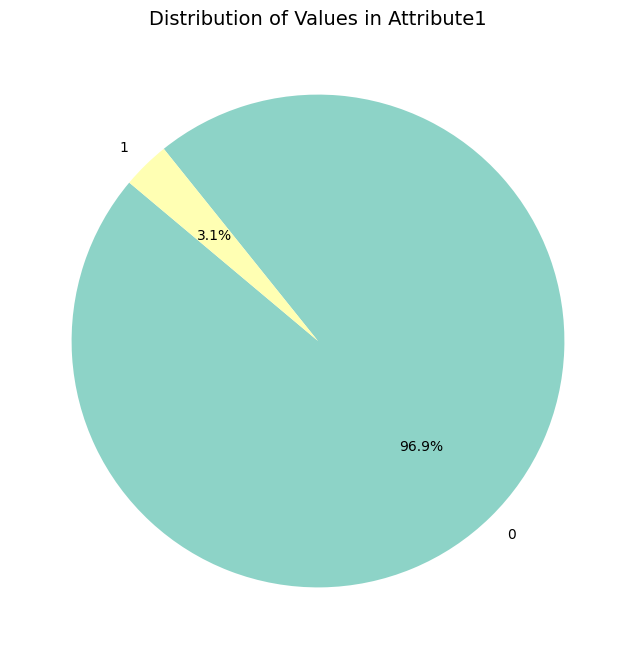

In [18]:
# Retrieve the value counts of 'Attribute1' from the dataframe
attribute1_counts = df['Attribute1'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute1_counts, labels=attribute1_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3', len(attribute1_counts)))

# Add a title
plt.title('Distribution of Values in Attribute1', fontsize=14)

# Display the chart
plt.show()

In [19]:
# Creating a cross-tabulation table of counts for Attribute1 against NObeyesdad
Attribute1_class_counts = pd.crosstab(df['Attribute1'], df['class'])
Attribute1_class_counts

class       1   2   3
Attribute1           
0           9  12  10
1           0   1   0

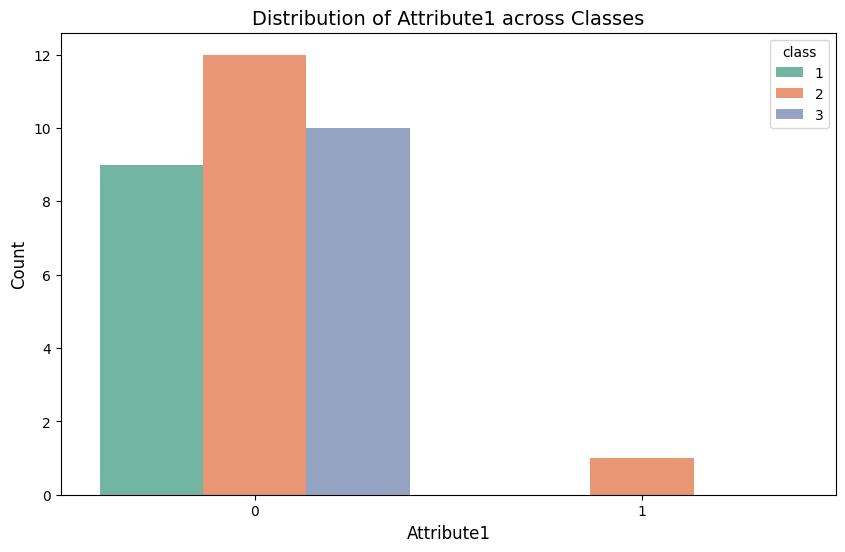

In [20]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute1' grouped by 'class'
sns.countplot(data=df, x='Attribute1', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute1 across Classes', fontsize=14)
plt.xlabel('Attribute1', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute2

In [21]:
# Counting the occurrences of each value in the 'Attribute2' column
df['Attribute2'].value_counts()

Attribute2
2    18
3    13
1     1
Name: count, dtype: int64

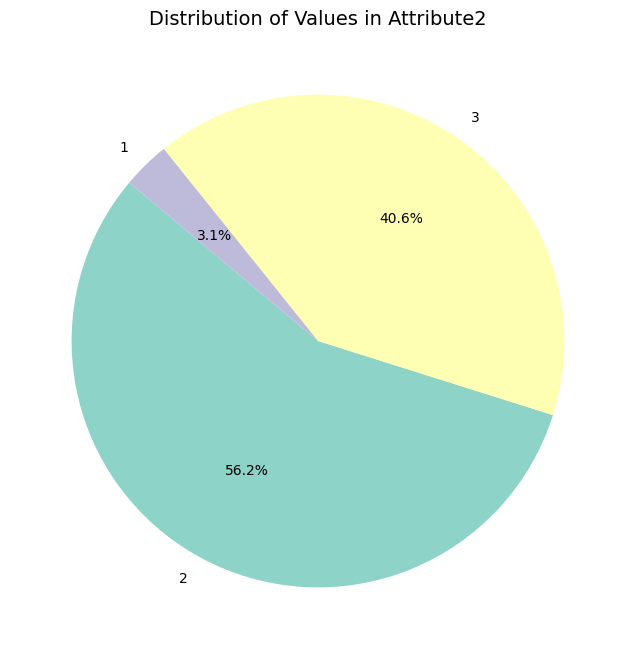

In [22]:
# Retrieve the value counts of 'Attribute2' from the dataframe
attribute2_counts = df['Attribute2'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute2_counts, labels=attribute2_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute2_counts)))

# Add a title
plt.title('Distribution of Values in Attribute2', fontsize=14)

# Display the chart
plt.show()

In [23]:
# Creating a cross-tabulation table of counts for Attribute2 against class
Attribute2_class_counts = pd.crosstab(df['Attribute2'], df['class'])
Attribute2_class_counts

class       1  2  3
Attribute2         
1           0  1  0
2           2  8  8
3           7  4  2

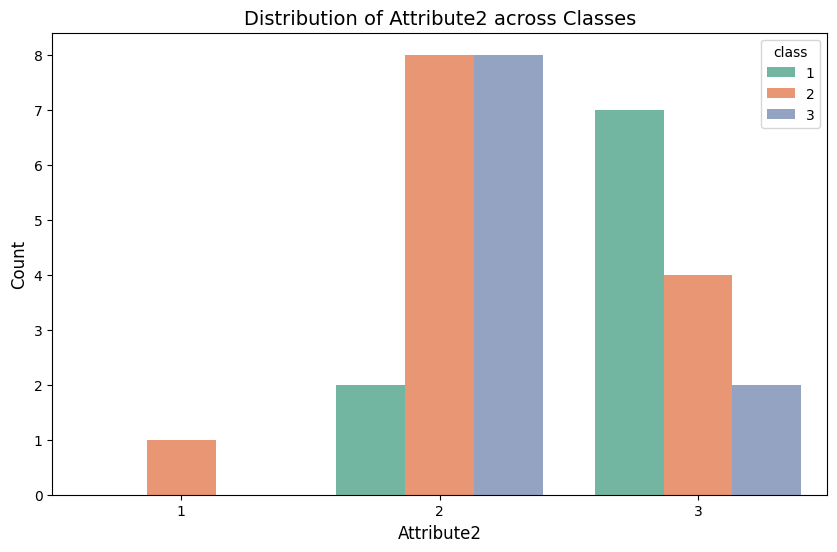

In [24]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute2' grouped by 'class'
sns.countplot(data=df, x='Attribute2', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute2 across Classes', fontsize=14)
plt.xlabel('Attribute2', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute3

In [25]:
# Counting the occurrences of each value in the 'Attribute3' column
df['Attribute3'].value_counts()

Attribute3
3    13
2    11
0     4
1     4
Name: count, dtype: int64

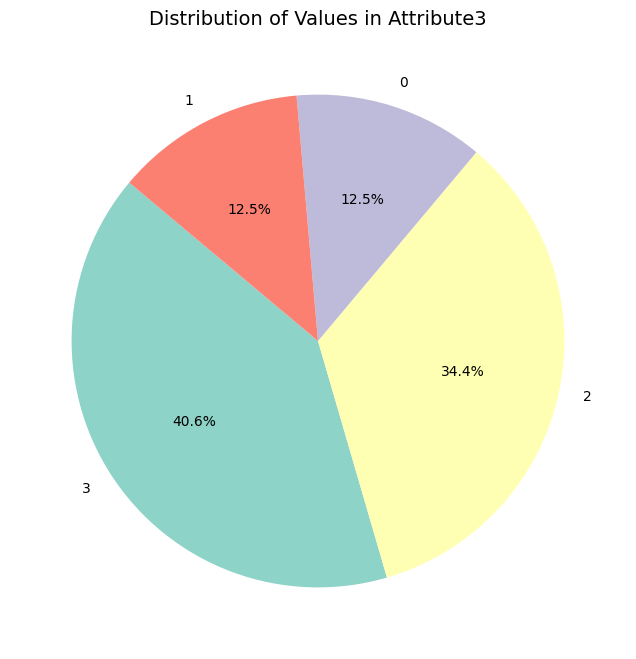

In [26]:
# Retrieve the value counts of 'Attribute3' from the dataframe
attribute3_counts = df['Attribute3'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute3_counts, labels=attribute3_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute3_counts)))

# Add a title
plt.title('Distribution of Values in Attribute3', fontsize=14)

# Display the chart
plt.show()

In [27]:
# Creating a cross-tabulation table of counts for Attribute3 against class
Attribute3_class_counts = pd.crosstab(df['Attribute3'], df['class'])
Attribute3_class_counts

class       1  2  3
Attribute3         
0           1  3  0
1           1  2  1
2           3  5  3
3           4  3  6

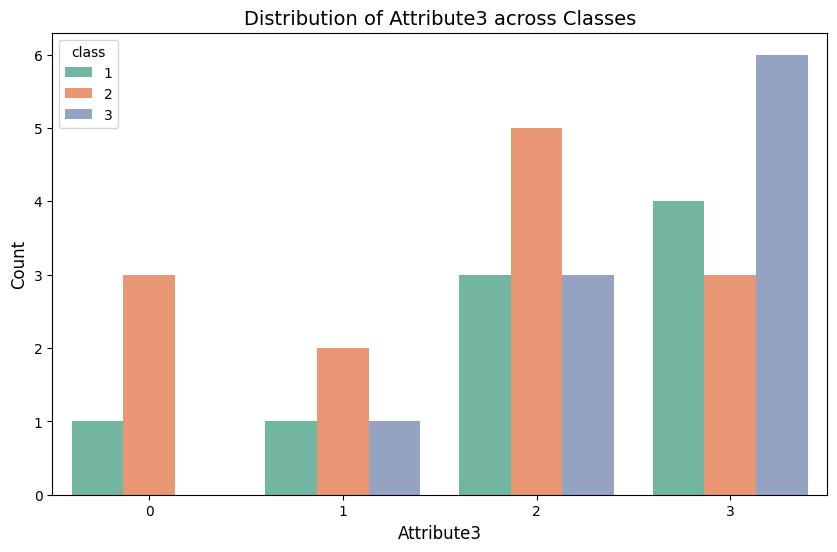

In [28]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute3' grouped by 'class'
sns.countplot(data=df, x='Attribute3', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute3 across Classes', fontsize=14)
plt.xlabel('Attribute3', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute4

In [29]:
# Counting the occurrences of each value in the 'Attribute4' column
Attribute4_counts = df['Attribute4'].value_counts()
Attribute4_counts

Attribute4
1.0    15
2.0    12
0.0     1
Name: count, dtype: int64

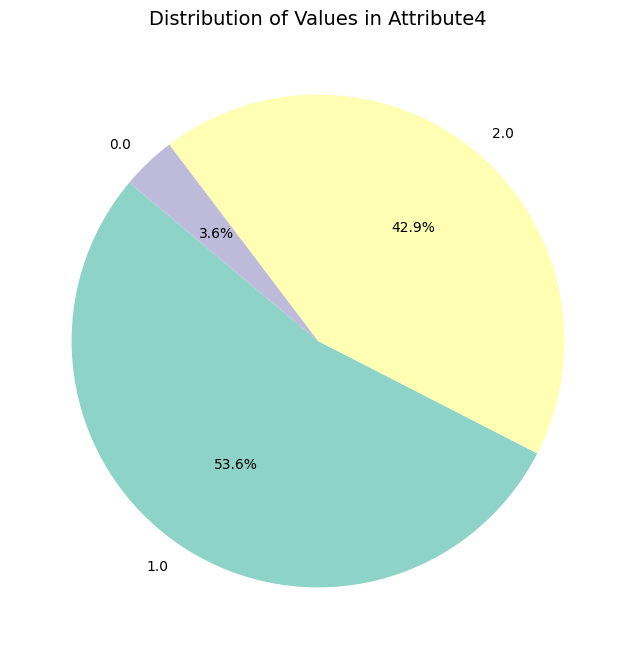

In [30]:
# Retrieve the value counts of 'Attribute4' from the dataframe
attribute4_counts = df['Attribute4'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute4_counts, labels=attribute4_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute4_counts)))

# Add a title
plt.title('Distribution of Values in Attribute4', fontsize=14)

# Display the chart
plt.show()

In [31]:
# Creating a cross-tabulation table of counts for Attribute4 against class
Attribute4_class_counts = pd.crosstab(df['Attribute4'], df['class'])
Attribute4_class_counts

class       1  2  3
Attribute4         
0.0         0  1  0
1.0         5  4  6
2.0         3  5  4

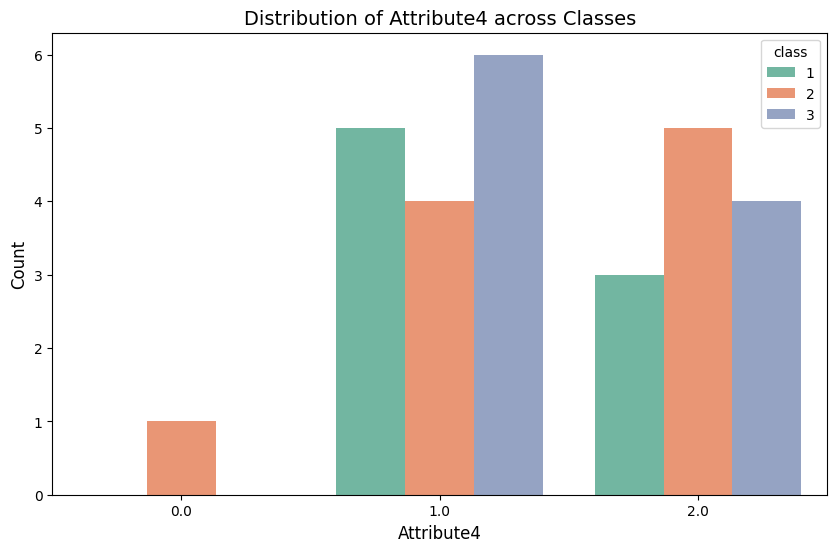

In [32]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute4' grouped by 'class'
sns.countplot(data=df, x='Attribute4', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute4 across Classes', fontsize=14)
plt.xlabel('Attribute4', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute5

In [33]:
# Counting the occurrences of each value in the 'Attribute5' column
Attribute5_counts = df['Attribute5'].value_counts()
Attribute5_counts

Attribute5
0    23
1     9
Name: count, dtype: int64

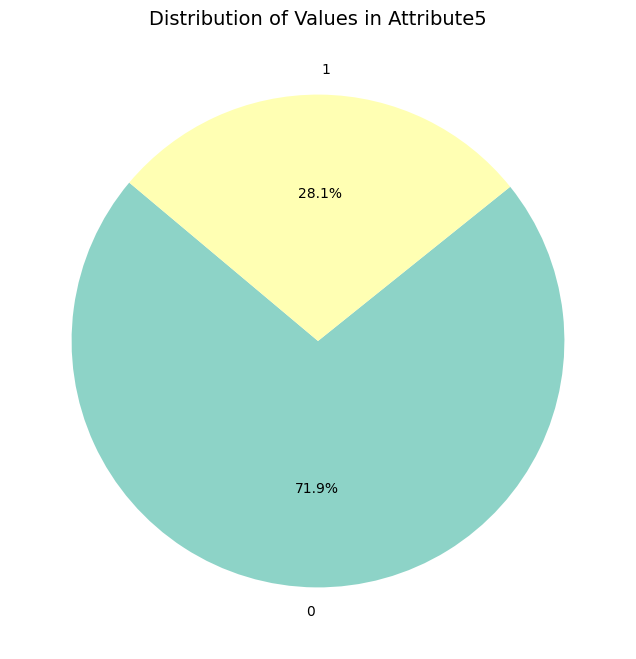

In [34]:
# Retrieve the value counts of 'Attribute5' from the dataframe
attribute5_counts = df['Attribute5'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute5_counts, labels=attribute5_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute5_counts)))

# Add a title
plt.title('Distribution of Values in Attribute5', fontsize=14)

# Display the chart
plt.show()

In [35]:
# Creating a cross-tabulation table of counts for Attribute5 against class
Attribute5_class_counts = pd.crosstab(df['Attribute5'], df['class'])
Attribute5_class_counts

class       1  2  3
Attribute5         
0           7  9  7
1           2  4  3

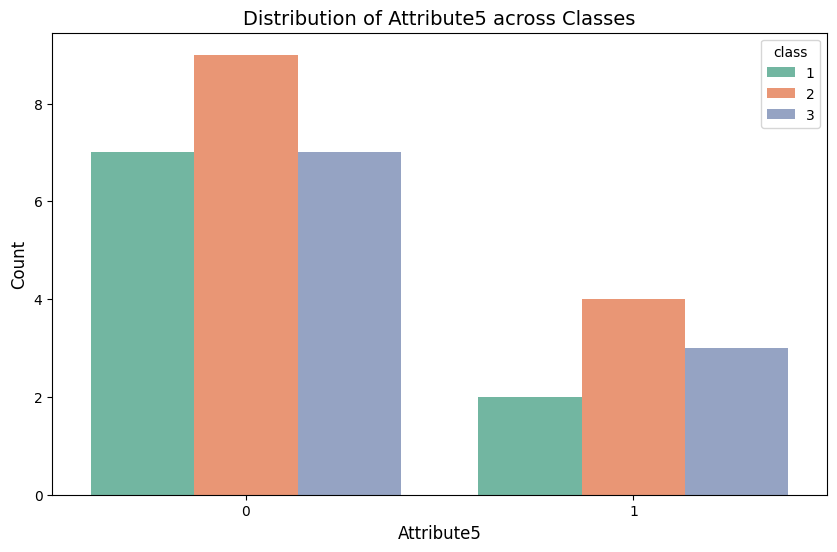

In [36]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute5' grouped by 'class'
sns.countplot(data=df, x='Attribute5', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute5 across Classes', fontsize=14)
plt.xlabel('Attribute5', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute6

In [37]:
# Counting the occurrences of each value in the 'Attribute6' column
Attribute6_counts = df['Attribute6'].value_counts()
Attribute6_counts

Attribute6
2    14
3    12
1     6
Name: count, dtype: int64

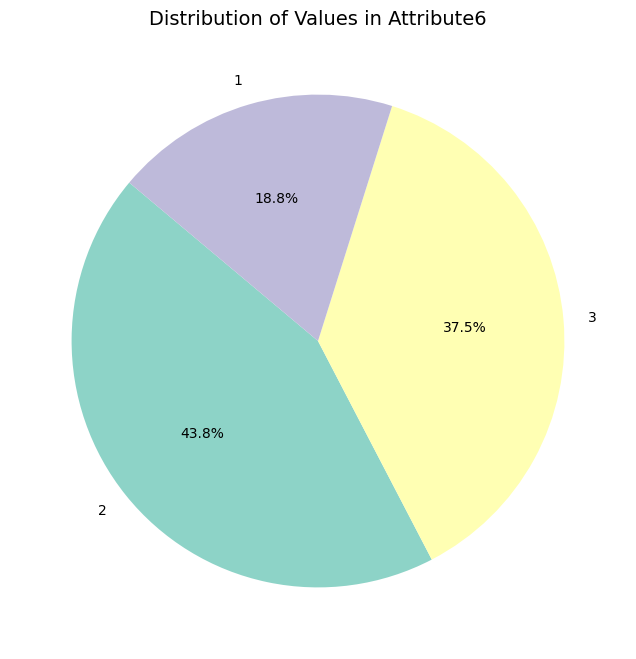

In [38]:
# Retrieve the value counts of 'Attribute6' from the dataframe
attribute6_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute6_counts, labels=attribute6_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute6_counts)))

# Add a title
plt.title('Distribution of Values in Attribute6', fontsize=14)

# Display the chart
plt.show()

In [39]:
# Creating a cross-tabulation table of counts for Attribute6 against class
Attribute6_class_counts = pd.crosstab(df['Attribute6'], df['class'])
Attribute6_class_counts

class       1  2  3
Attribute6         
1           0  4  2
2           1  6  7
3           8  3  1

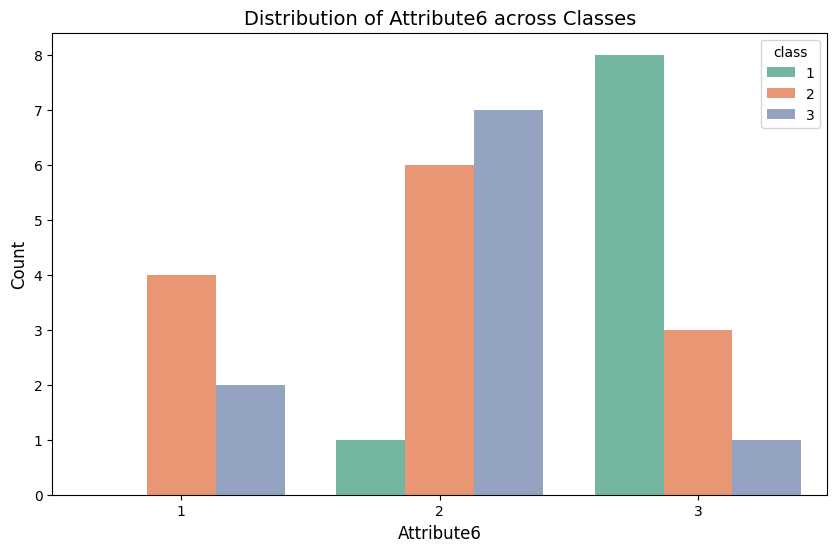

In [40]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute6' grouped by 'class'
sns.countplot(data=df, x='Attribute6', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute6 across Classes', fontsize=14)
plt.xlabel('Attribute6', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute7

In [41]:
# Counting the occurrences of each value in the 'Attribute7' column
Attribute6_counts = df['Attribute7'].value_counts()
Attribute6_counts

Attribute7
2    14
3    11
1     7
Name: count, dtype: int64

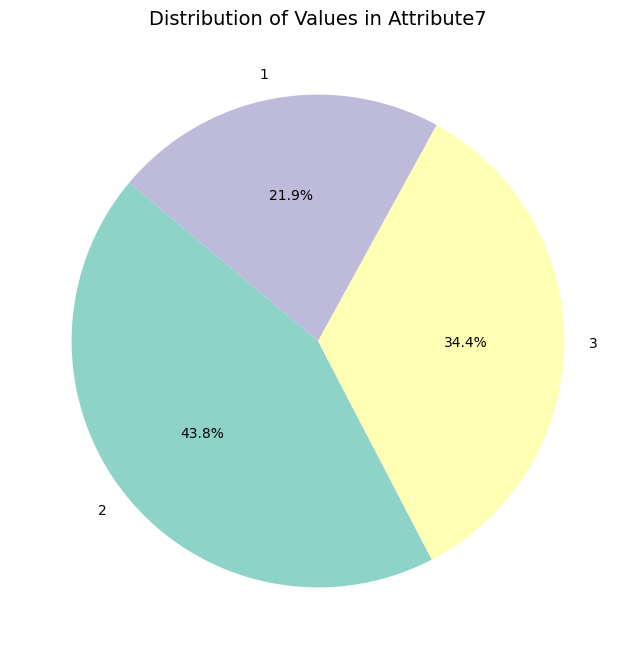

In [42]:
# Retrieve the value counts of 'Attribute7' from the dataframe
attribute7_counts = df['Attribute7'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute7_counts, labels=attribute7_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute7_counts)))

# Add a title
plt.title('Distribution of Values in Attribute7', fontsize=14)

# Display the chart
plt.show()

In [43]:
# Creating a cross-tabulation table of counts for Attribute7 against class
Attribute7_class_counts = pd.crosstab(df['Attribute7'], df['class'])
Attribute7_class_counts

class       1  2  3
Attribute7         
1           3  3  1
2           1  6  7
3           5  4  2

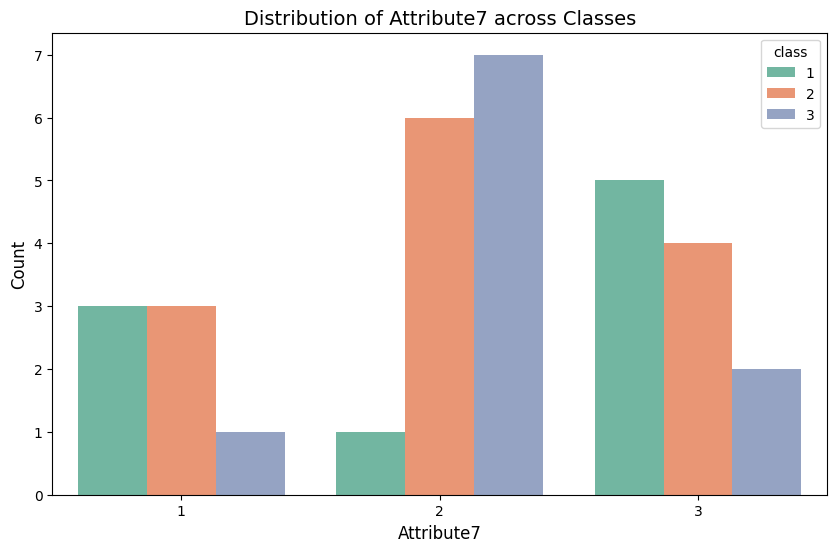

In [44]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute7' grouped by 'class'
sns.countplot(data=df, x='Attribute7', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute7 across Classes', fontsize=14)
plt.xlabel('Attribute7', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute8

In [45]:
# Counting the occurrences of each value in the 'Attribute8' column
Attribute8_counts = df['Attribute8'].value_counts()
Attribute8_counts

Attribute8
3    18
2     9
1     5
Name: count, dtype: int64

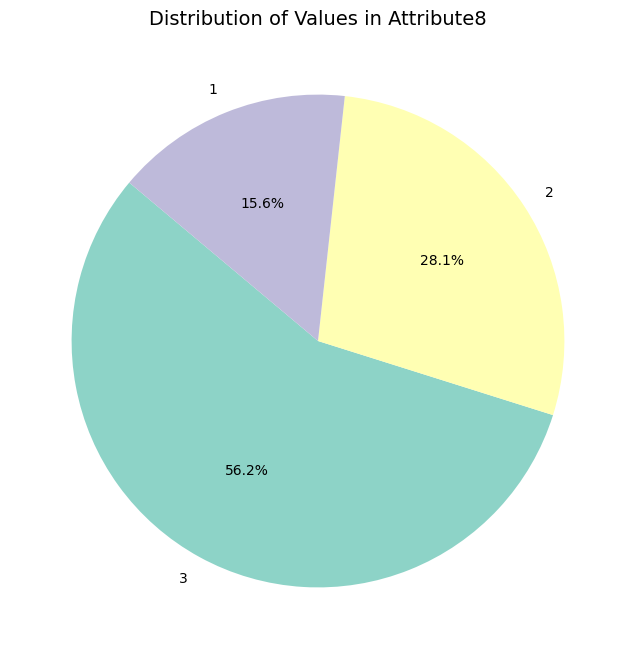

In [46]:
# Retrieve the value counts of 'Attribute8' from the dataframe
attribute8_counts = df['Attribute8'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute8_counts, labels=attribute8_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute8_counts)))

# Add a title
plt.title('Distribution of Values in Attribute8', fontsize=14)

# Display the chart
plt.show()

In [47]:
# Creating a cross-tabulation table of counts for Attribute8 against class
Attribute8_class_counts = pd.crosstab(df['Attribute8'], df['class'])
Attribute8_class_counts

class       1  2  3
Attribute8         
1           0  1  4
2           1  4  4
3           8  8  2

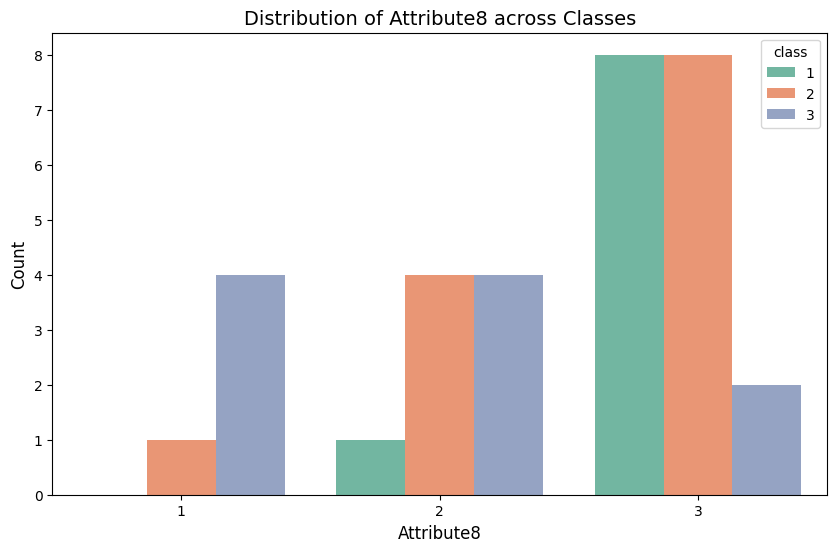

In [48]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute8' grouped by 'class'
sns.countplot(data=df, x='Attribute8', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute8 across Classes', fontsize=14)
plt.xlabel('Attribute8', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute9

In [49]:
# Counting the occurrences of each value in the 'Attribute9' column
Attribute9_counts = df['Attribute9'].value_counts()
Attribute9_counts

Attribute9
1    29
3     2
2     1
Name: count, dtype: int64

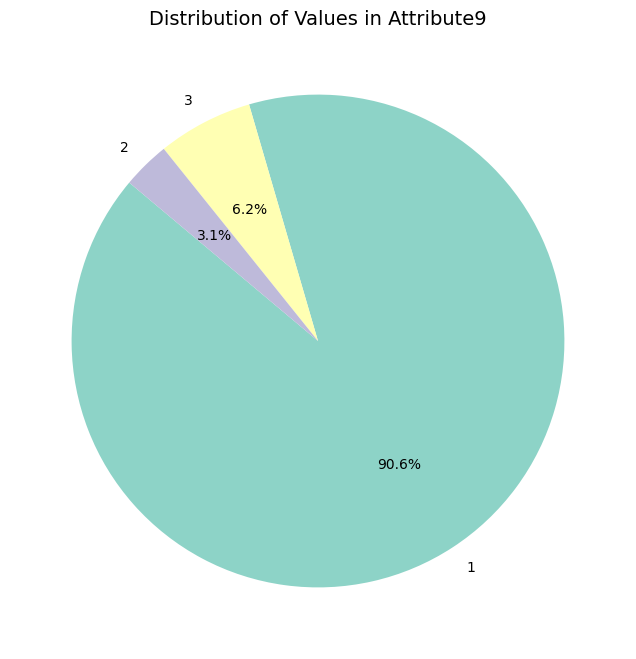

In [50]:
# Retrieve the value counts of 'Attribute9' from the dataframe
attribute9_counts = df['Attribute9'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute9_counts, labels=attribute9_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute9_counts)))

# Add a title
plt.title('Distribution of Values in Attribute9', fontsize=14)

# Display the chart
plt.show()

In [51]:
# Creating a cross-tabulation table of counts for Attribute9 against class
Attribute9_class_counts = pd.crosstab(df['Attribute9'], df['class'])
Attribute9_class_counts

class       1   2   3
Attribute9           
1           7  12  10
2           1   0   0
3           1   1   0

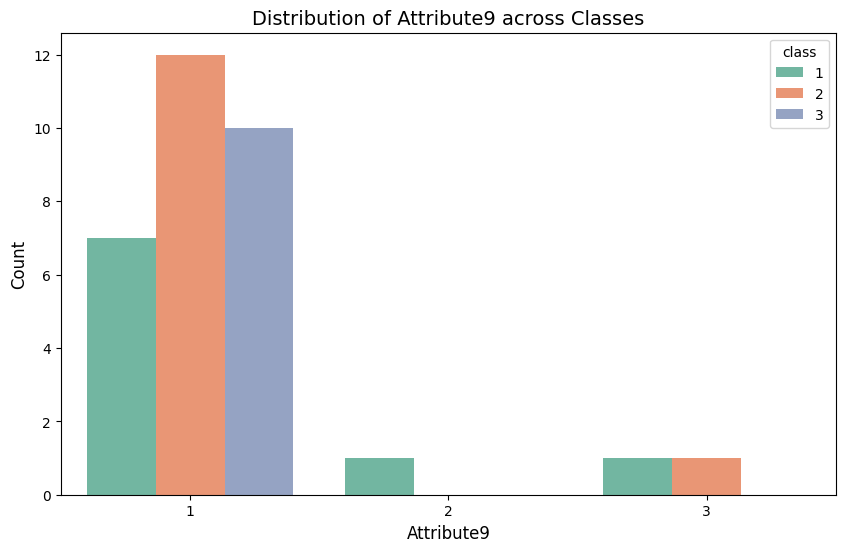

In [52]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute9' grouped by 'class'
sns.countplot(data=df, x='Attribute9', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute9 across Classes', fontsize=14)
plt.xlabel('Attribute9', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute10

In [53]:
# Counting the occurrences of each value in the 'Attribute10' column
Attribute10_counts = df['Attribute10'].value_counts()
Attribute10_counts

Attribute10
1    20
2    11
3     1
Name: count, dtype: int64

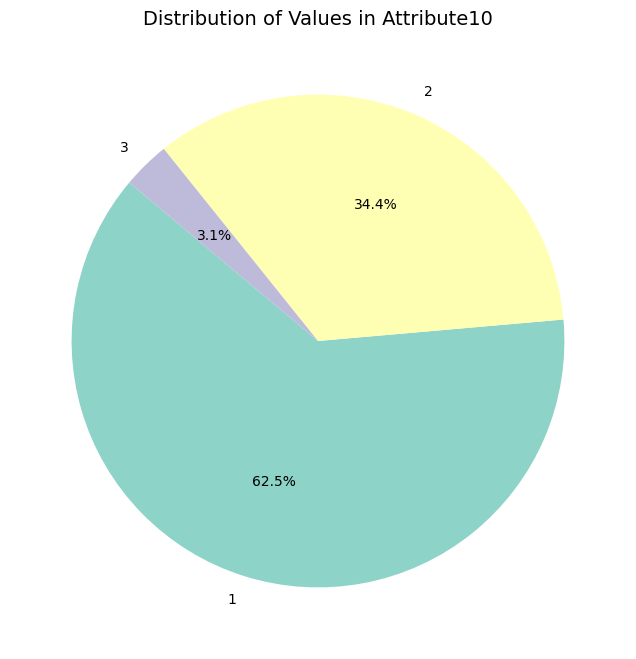

In [54]:
# Retrieve the value counts of 'Attribute10' from the dataframe
attribute10_counts = df['Attribute10'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute10_counts, labels=attribute10_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute10_counts)))

# Add a title
plt.title('Distribution of Values in Attribute10', fontsize=14)

# Display the chart
plt.show()

In [55]:
# Creating a cross-tabulation table of counts for Attribute10 against class
Attribute10_class_counts = pd.crosstab(df['Attribute10'], df['class'])
Attribute10_class_counts

class        1  2  3
Attribute10         
1            4  7  9
2            4  6  1
3            1  0  0

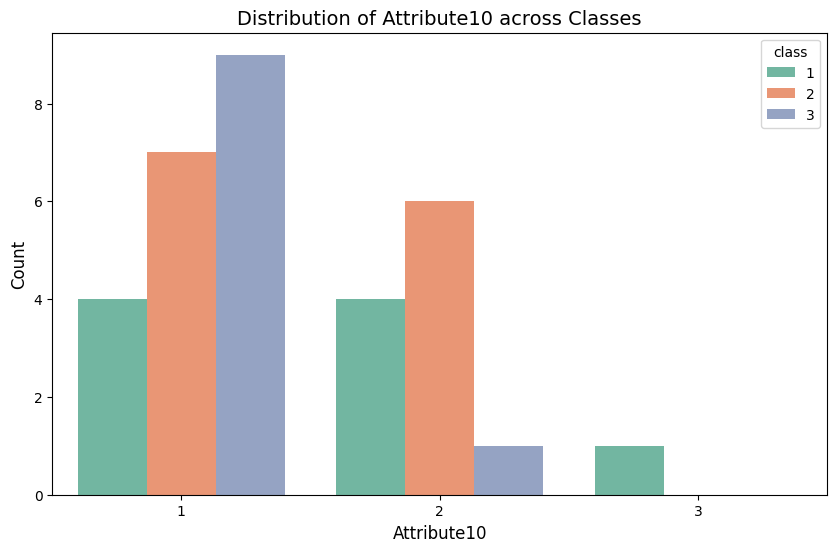

In [56]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute10' grouped by 'class'
sns.countplot(data=df, x='Attribute10', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute10 across Classes', fontsize=14)
plt.xlabel('Attribute10', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute11

In [57]:
# Counting the occurrences of each value in the 'Attribute11' column
Attribute11_counts = df['Attribute11'].value_counts()
Attribute11_counts

Attribute11
1    19
2    10
3     3
Name: count, dtype: int64

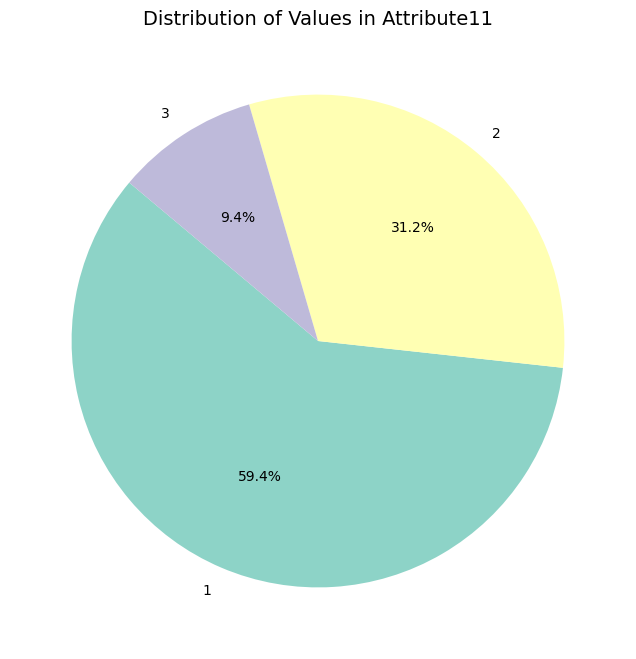

In [58]:
# Retrieve the value counts of 'Attribute11' from the dataframe
attribute11_counts = df['Attribute11'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute11_counts, labels=attribute11_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute11_counts)))

# Add a title
plt.title('Distribution of Values in Attribute11', fontsize=14)

# Display the chart
plt.show()

In [59]:
# Creating a cross-tabulation table of counts for Attribute11 against class
Attribute11_class_counts = pd.crosstab(df['Attribute11'], df['class'])
Attribute11_class_counts

class        1  2  3
Attribute11         
1            6  8  5
2            2  3  5
3            1  2  0

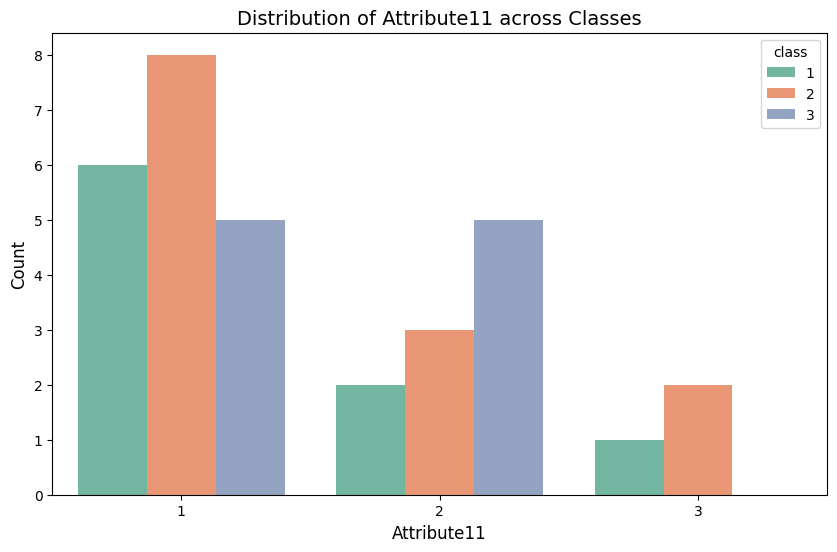

In [60]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute11' grouped by 'class'
sns.countplot(data=df, x='Attribute11', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute11 across Classes', fontsize=14)
plt.xlabel('Attribute11', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute12

In [61]:
# Counting the occurrences of each value in the 'Attribute12' column
Attribute12_counts = df['Attribute12'].value_counts()
Attribute12_counts

Attribute12
1    15
0    11
2     4
3     2
Name: count, dtype: int64

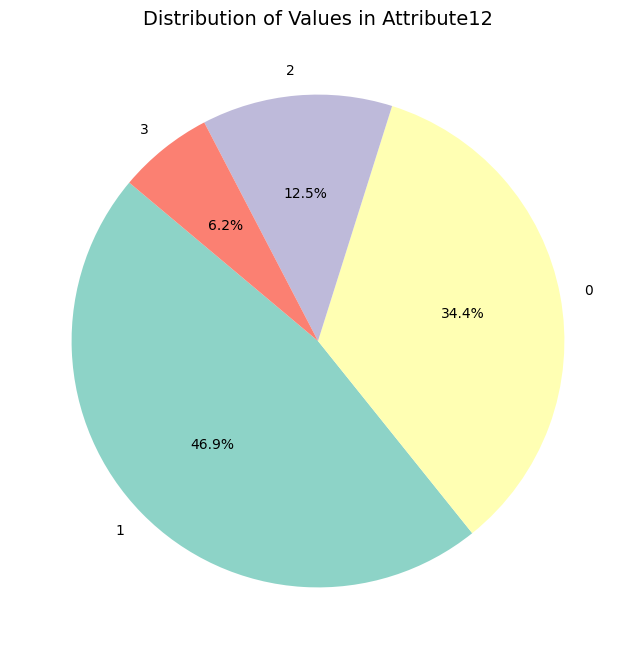

In [62]:
# Retrieve the value counts of 'Attribute12' from the dataframe
attribute12_counts = df['Attribute12'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute12_counts, labels=attribute12_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute12_counts)))

# Add a title
plt.title('Distribution of Values in Attribute12', fontsize=14)

# Display the chart
plt.show()

In [63]:
# Creating a cross-tabulation table of counts for Attribute12 against class
Attribute12_class_counts = pd.crosstab(df['Attribute12'], df['class'])
Attribute12_class_counts

class        1  2  3
Attribute12         
0            3  4  4
1            3  7  5
2            2  1  1
3            1  1  0

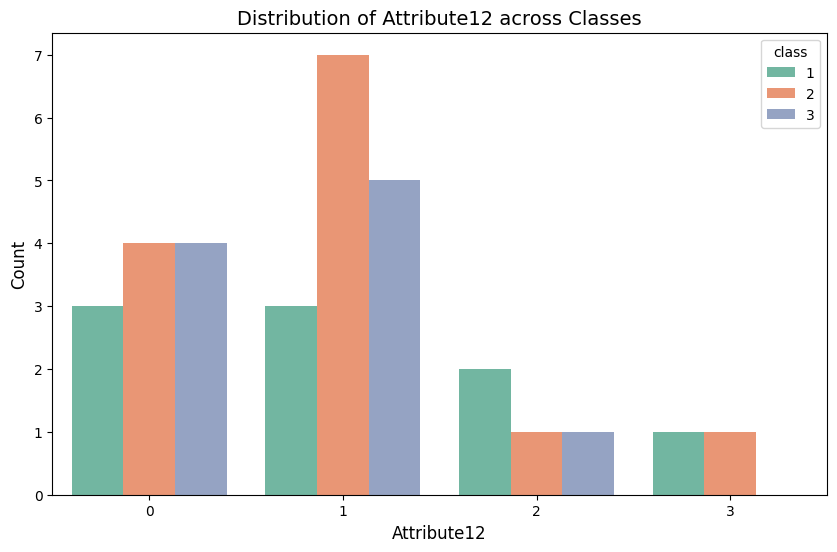

In [64]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute12' grouped by 'class'
sns.countplot(data=df, x='Attribute12', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute12 across Classes', fontsize=14)
plt.xlabel('Attribute12', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute13

In [65]:
# Counting the occurrences of each value in the 'Attribute13' column
Attribute13_counts = df['Attribute13'].value_counts()
Attribute13_counts

Attribute13
2    12
1    11
3     9
Name: count, dtype: int64

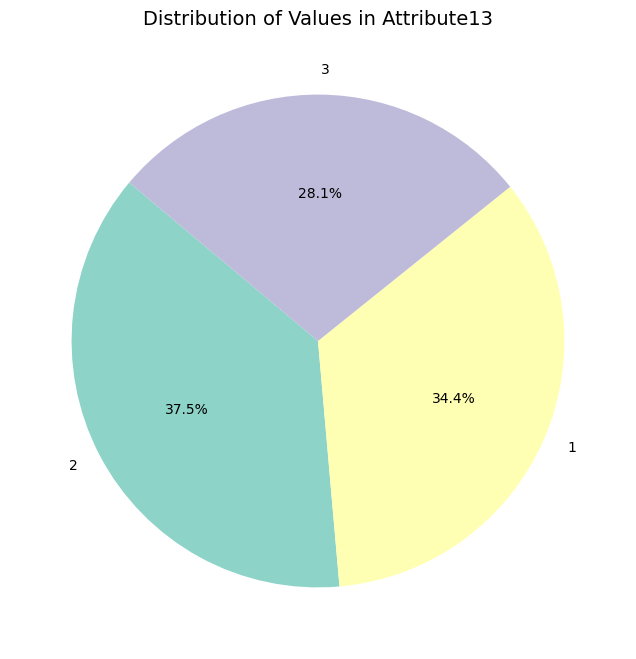

In [66]:
# Retrieve the value counts of 'Attribute13' from the dataframe
attribute13_counts = df['Attribute13'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute13_counts, labels=attribute13_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute13_counts)))

# Add a title
plt.title('Distribution of Values in Attribute13', fontsize=14)

# Display the chart
plt.show()

In [67]:
# Creating a cross-tabulation table of counts for Attribute13 against class
Attribute13_class_counts = pd.crosstab(df['Attribute13'], df['class'])
Attribute13_class_counts

class        1  2  3
Attribute13         
1            3  3  5
2            1  6  5
3            5  4  0

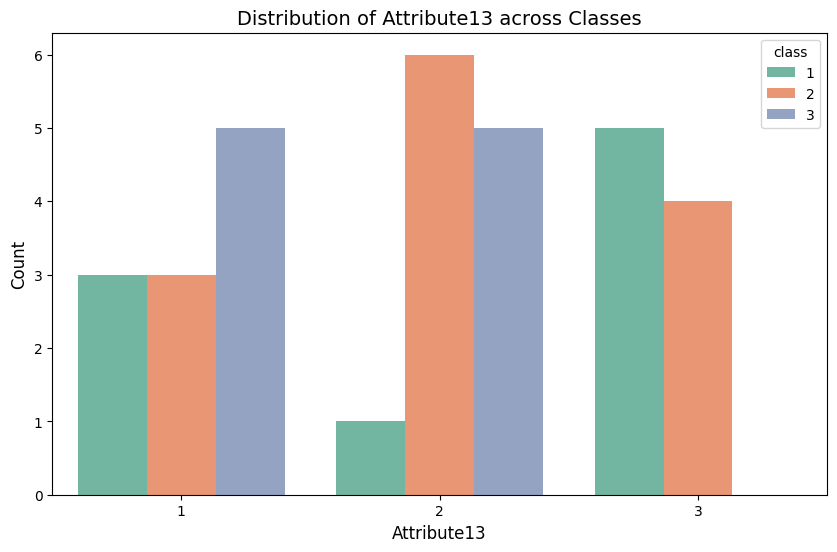

In [68]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute13' grouped by 'class'
sns.countplot(data=df, x='Attribute13', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute13 across Classes', fontsize=14)
plt.xlabel('Attribute13', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute14

In [69]:
# Counting the occurrences of each value in the 'Attribute14' column
Attribute14_counts = df['Attribute14'].value_counts()
Attribute14_counts

Attribute14
2    14
3    12
1     6
Name: count, dtype: int64

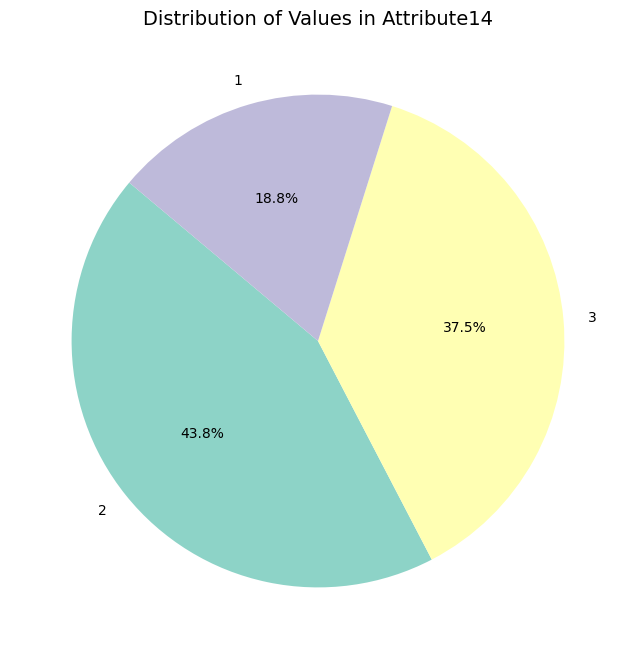

In [70]:
# Retrieve the value counts of 'Attribute14' from the dataframe
attribute14_counts = df['Attribute14'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute14_counts, labels=attribute14_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute14_counts)))

# Add a title
plt.title('Distribution of Values in Attribute14', fontsize=14)

# Display the chart
plt.show()

In [71]:
# Creating a cross-tabulation table of counts for Attribute14 against class
Attribute14_class_counts = pd.crosstab(df['Attribute14'], df['class'])
Attribute14_class_counts

class        1  2  3
Attribute14         
1            0  3  3
2            2  5  7
3            7  5  0

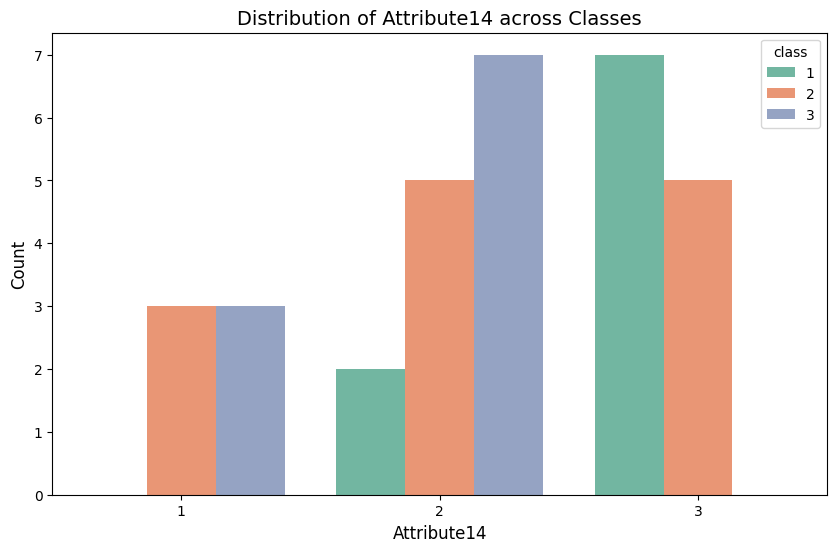

In [72]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute14' grouped by 'class'
sns.countplot(data=df, x='Attribute14', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute14 across Classes', fontsize=14)
plt.xlabel('Attribute14', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute15

In [73]:
# Counting the occurrences of each value in the 'Attribute15' column
Attribute15_counts = df['Attribute15'].value_counts()
Attribute15_counts

Attribute15
2    13
3    13
1     6
Name: count, dtype: int64

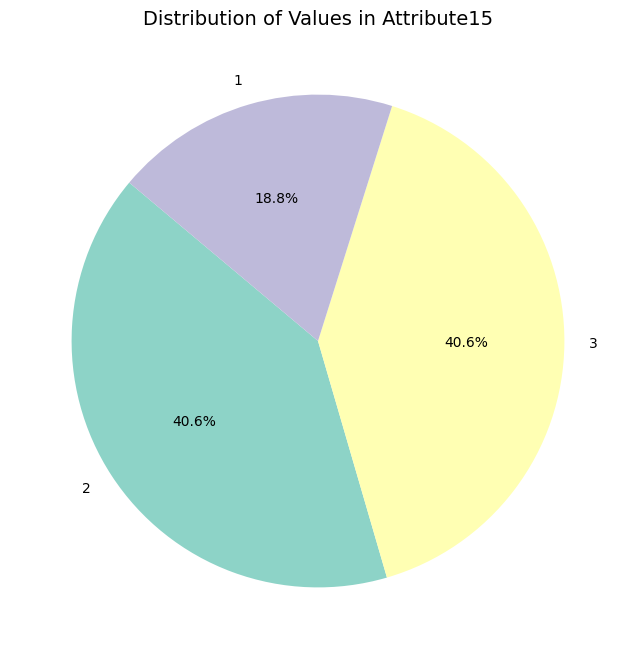

In [74]:
# Retrieve the value counts of 'Attribute15' from the dataframe
attribute15_counts = df['Attribute15'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute15_counts, labels=attribute15_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute15_counts)))

# Add a title
plt.title('Distribution of Values in Attribute15', fontsize=14)

# Display the chart
plt.show()

In [75]:
# Creating a cross-tabulation table of counts for Attribute15 against class
Attribute15_class_counts = pd.crosstab(df['Attribute15'], df['class'])
Attribute15_class_counts

class        1  2  3
Attribute15         
1            1  3  2
2            2  4  7
3            6  6  1

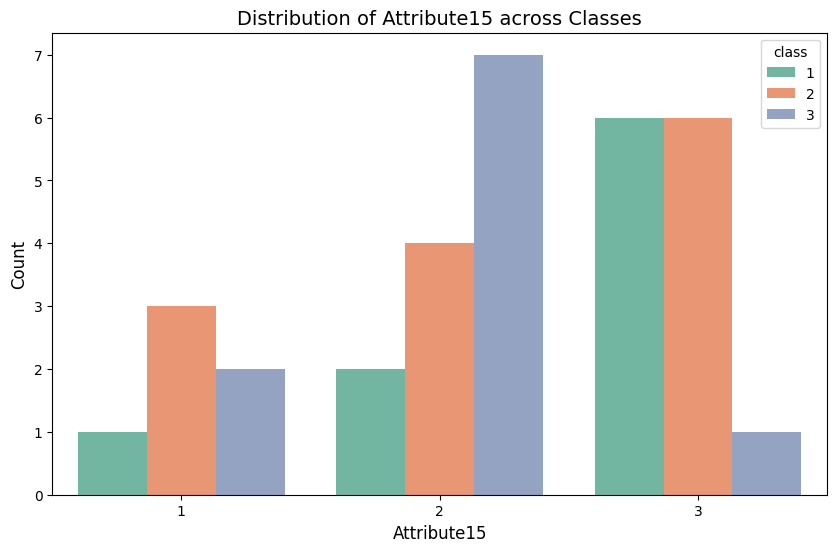

In [76]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute15' grouped by 'class'
sns.countplot(data=df, x='Attribute15', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute15 across Classes', fontsize=14)
plt.xlabel('Attribute15', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute16

In [77]:
# Counting the occurrences of each value in the 'Attribute6' column
Attribute16_counts = df['Attribute16'].value_counts()
Attribute16_counts

Attribute16
1    23
2     8
3     1
Name: count, dtype: int64

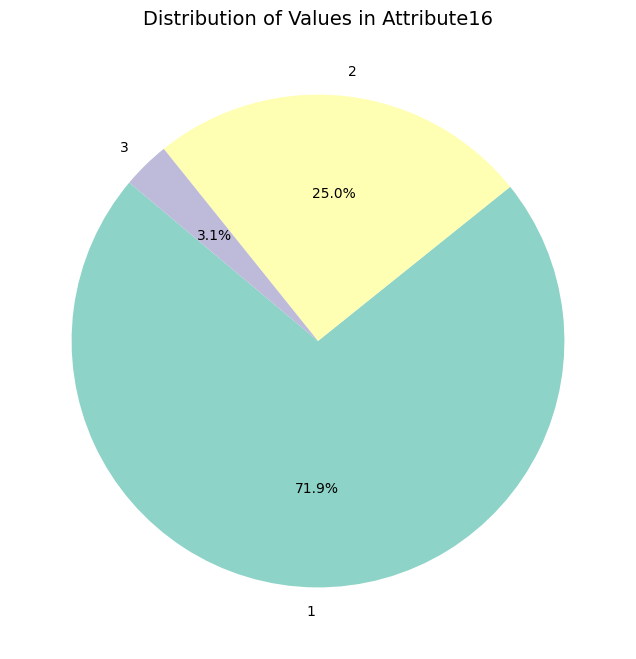

In [78]:
# Retrieve the value counts of 'Attribute6' from the dataframe
attribute16_counts = df['Attribute16'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute16_counts, labels=attribute16_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute16_counts)))

# Add a title
plt.title('Distribution of Values in Attribute16', fontsize=14)

# Display the chart
plt.show()

In [79]:
# Creating a cross-tabulation table of counts for Attribute16 against class
Attribute16_class_counts = pd.crosstab(df['Attribute16'], df['class'])
Attribute16_class_counts

class        1   2  3
Attribute16          
1            6  11  6
2            2   2  4
3            1   0  0

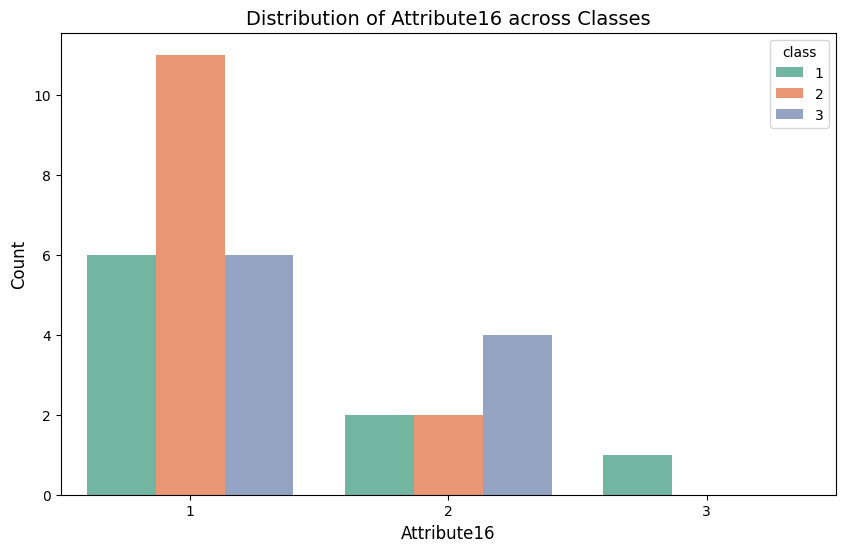

In [80]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute16' grouped by 'class'
sns.countplot(data=df, x='Attribute16', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute16 across Classes', fontsize=14)
plt.xlabel('Attribute16', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute17

In [81]:
# Counting the occurrences of each value in the 'Attribute17' column
Attribute17_counts = df['Attribute17'].value_counts()
Attribute17_counts

Attribute17
2    28
1     4
Name: count, dtype: int64

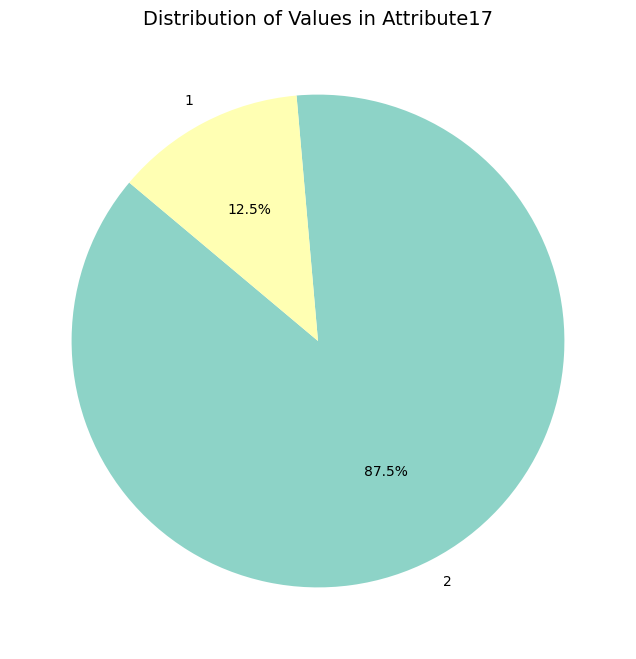

In [82]:
# Retrieve the value counts of 'Attribute17' from the dataframe
attribute17_counts = df['Attribute17'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute17_counts, labels=attribute17_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute17_counts)))

# Add a title
plt.title('Distribution of Values in Attribute17', fontsize=14)

# Display the chart
plt.show()

In [83]:
# Creating a cross-tabulation table of counts for Attribute17 against class
Attribute17_class_counts = pd.crosstab(df['Attribute17'], df['class'])
Attribute17_class_counts

class        1   2  3
Attribute17          
1            0   1  3
2            9  12  7

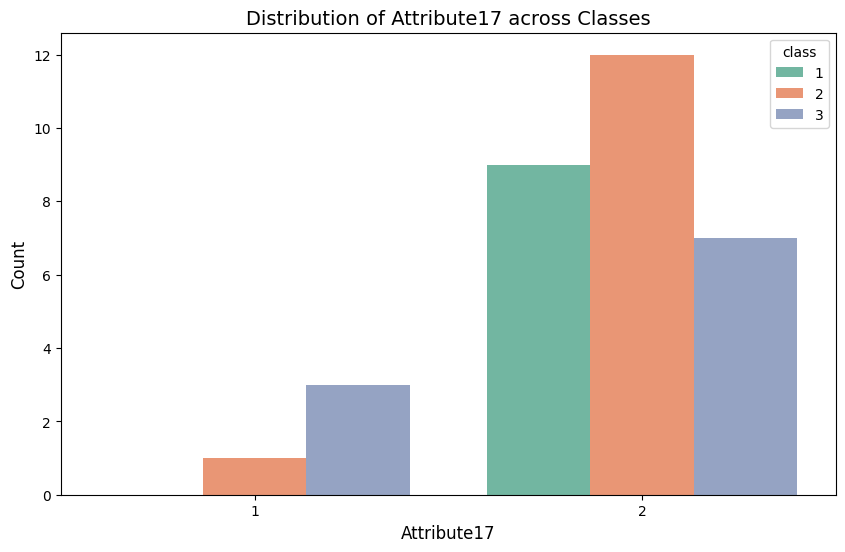

In [84]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute17' grouped by 'class'
sns.countplot(data=df, x='Attribute17', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute17 across Classes', fontsize=14)
plt.xlabel('Attribute17', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute18

In [85]:
# Counting the occurrences of each value in the 'Attribute18' column
Attribute18_counts = df['Attribute18'].value_counts()
Attribute18_counts

Attribute18
2    28
1     4
Name: count, dtype: int64

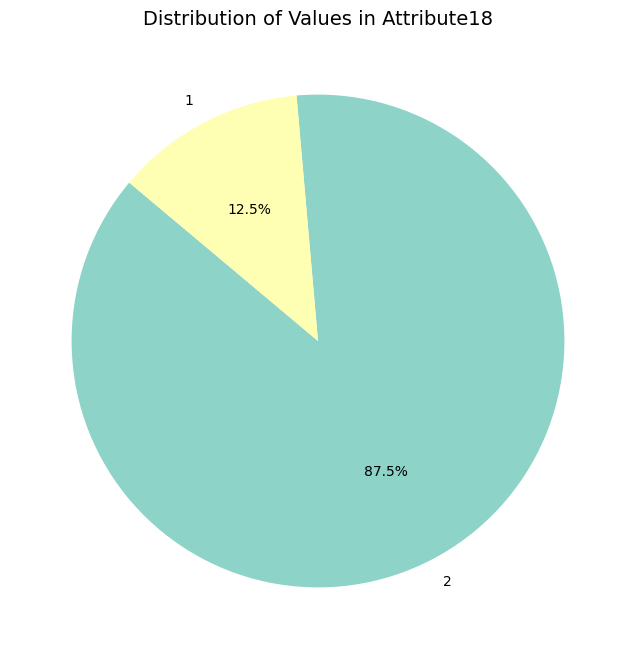

In [86]:
# Retrieve the value counts of 'Attribute18' from the dataframe
attribute18_counts = df['Attribute18'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute18_counts, labels=attribute18_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute18_counts)))

# Add a title
plt.title('Distribution of Values in Attribute18', fontsize=14)

# Display the chart
plt.show()

In [87]:
# Creating a cross-tabulation table of counts for Attribute18 against class
Attribute18_class_counts = pd.crosstab(df['Attribute18'], df['class'])
Attribute18_class_counts

class        1   2  3
Attribute18          
1            2   1  1
2            7  12  9

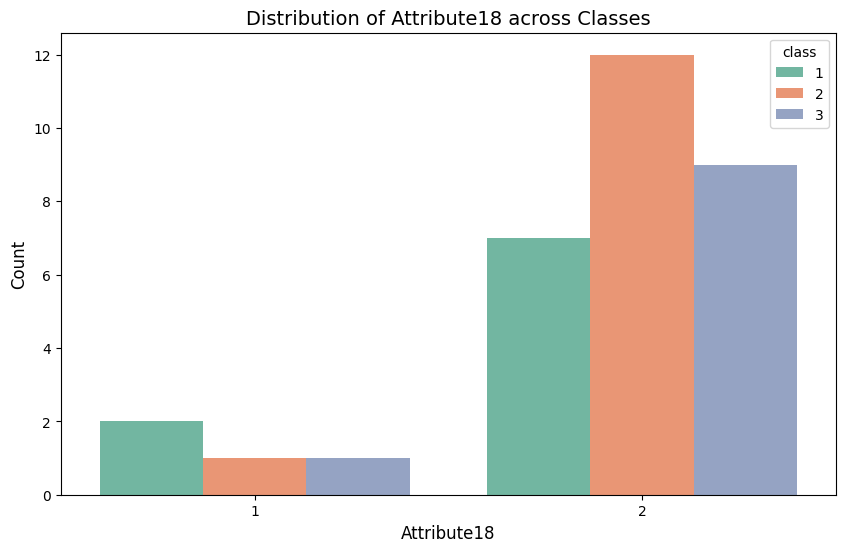

In [88]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute18' grouped by 'class'
sns.countplot(data=df, x='Attribute18', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute18 across Classes', fontsize=14)
plt.xlabel('Attribute18', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute19

In [89]:
# Counting the occurrences of each value in the 'Attribute6' column
Attribute19_counts = df['Attribute6'].value_counts()
Attribute19_counts

Attribute6
2    14
3    12
1     6
Name: count, dtype: int64

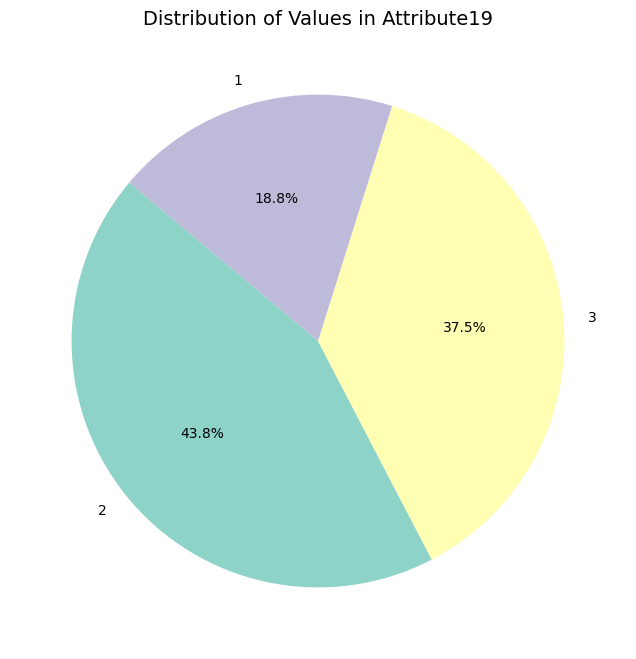

In [90]:
# Retrieve the value counts of 'Attribute19' from the dataframe
attribute19_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute19_counts, labels=attribute19_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute19_counts)))

# Add a title
plt.title('Distribution of Values in Attribute19', fontsize=14)

# Display the chart
plt.show()

In [91]:
# Creating a cross-tabulation table of counts for Attribute19 against class
Attribute19_class_counts = pd.crosstab(df['Attribute19'], df['class'])
Attribute19_class_counts

class        1   2  3
Attribute19          
0            9  12  3
1            0   0  1
2            0   1  6

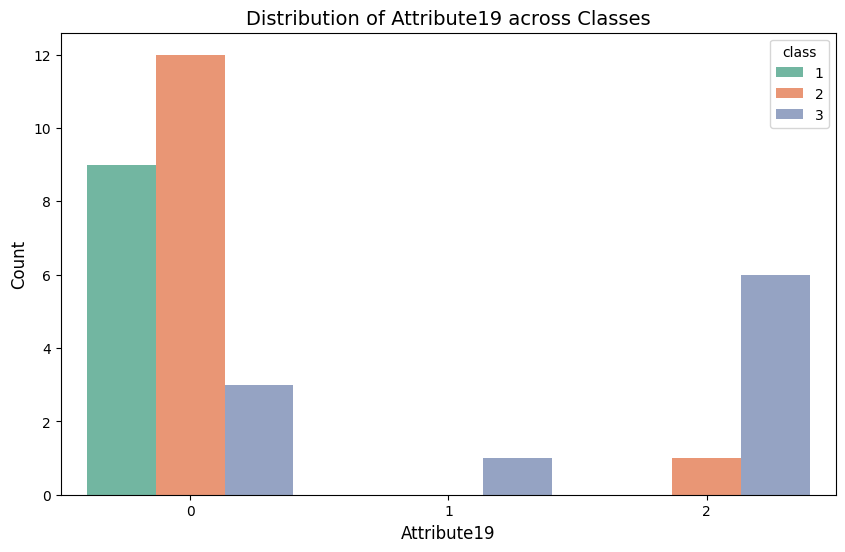

In [92]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute19' grouped by 'class'
sns.countplot(data=df, x='Attribute19', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute19 across Classes', fontsize=14)
plt.xlabel('Attribute19', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute20

In [93]:
# Counting the occurrences of each value in the 'Attribute20' column
Attribute20_counts = df['Attribute20'].value_counts()
Attribute20_counts

Attribute20
2    16
0    13
1     3
Name: count, dtype: int64

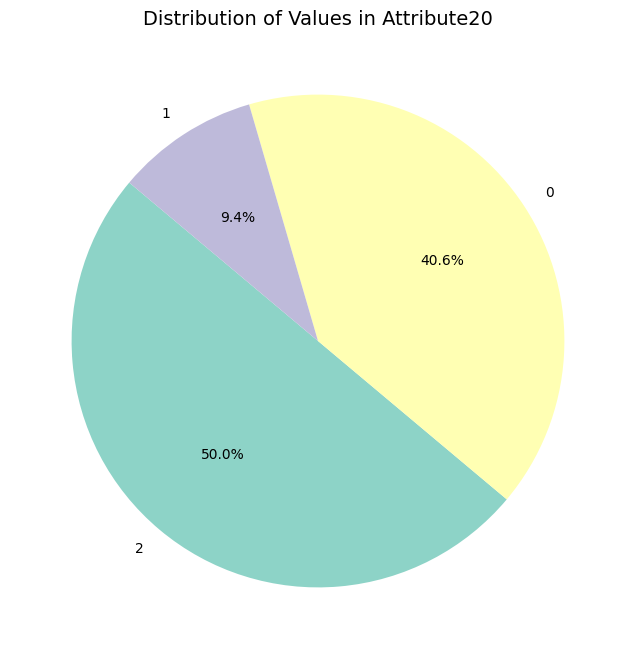

In [94]:
# Retrieve the value counts of 'Attribute20' from the dataframe
attribute20_counts = df['Attribute20'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute20_counts, labels=attribute20_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute20_counts)))

# Add a title
plt.title('Distribution of Values in Attribute20', fontsize=14)

# Display the chart
plt.show()

In [95]:
# Creating a cross-tabulation table of counts for Attribute20 against class
Attribute20_class_counts = pd.crosstab(df['Attribute20'], df['class'])
Attribute20_class_counts

class        1  2  3
Attribute20         
0            8  5  0
1            0  2  1
2            1  6  9

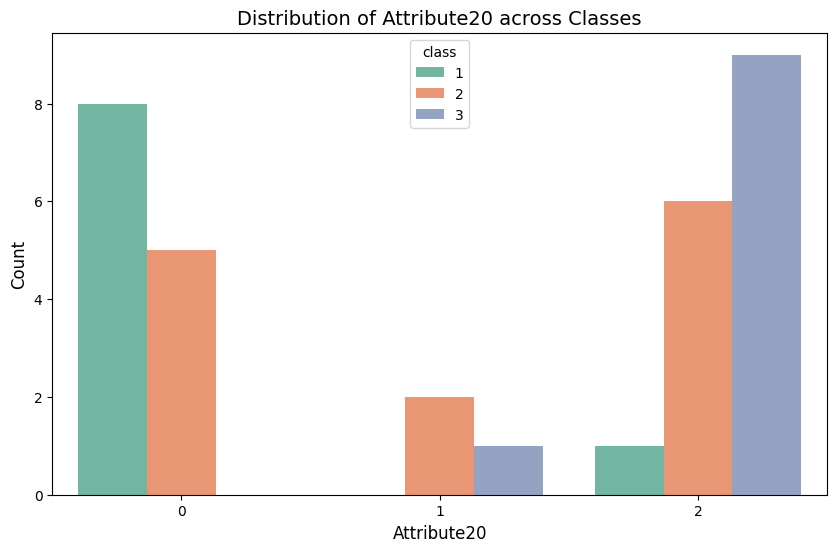

In [96]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute20' grouped by 'class'
sns.countplot(data=df, x='Attribute20', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute20 across Classes', fontsize=14)
plt.xlabel('Attribute20', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute21

In [97]:
# Counting the occurrences of each value in the 'Attribute21' column
Attribute21_counts = df['Attribute21'].value_counts()
Attribute21_counts

Attribute21
2    24
1     8
Name: count, dtype: int64

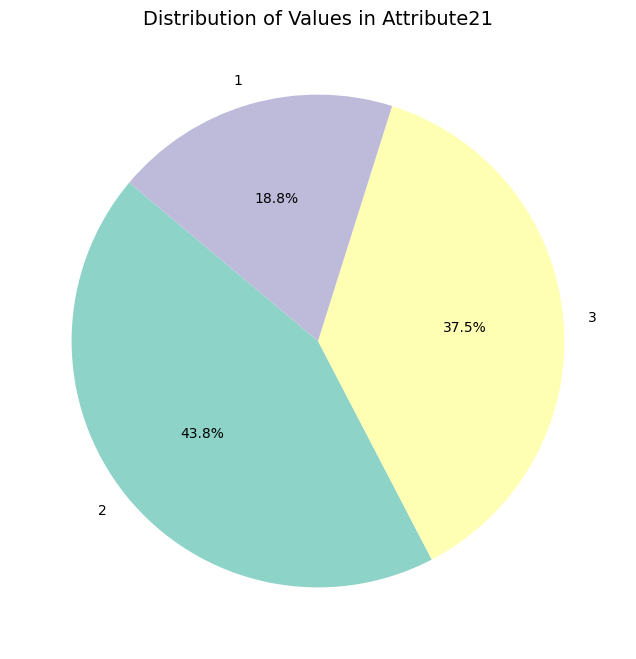

In [98]:
# Retrieve the value counts of 'Attribute21' from the dataframe
attribute21_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute21_counts, labels=attribute21_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute21_counts)))

# Add a title
plt.title('Distribution of Values in Attribute21', fontsize=14)

# Display the chart
plt.show()

In [99]:
# Creating a cross-tabulation table of counts for Attribute21 against class
Attribute21_class_counts = pd.crosstab(df['Attribute21'], df['class'])
Attribute21_class_counts

class        1   2  3
Attribute21          
1            2   2  4
2            7  11  6

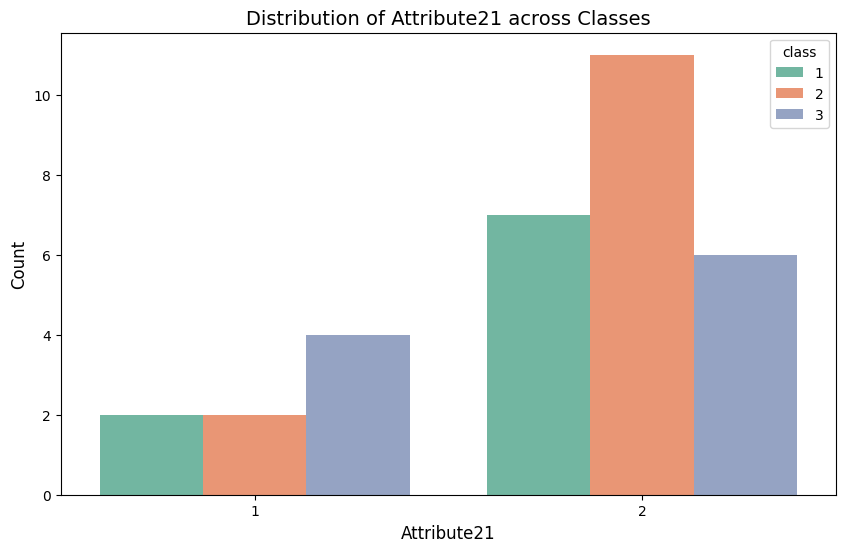

In [100]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute21' grouped by 'class'
sns.countplot(data=df, x='Attribute21', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute21 across Classes', fontsize=14)
plt.xlabel('Attribute21', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute22

In [101]:
# Counting the occurrences of each value in the 'Attribute22' column
Attribute22_counts = df['Attribute22'].value_counts()
Attribute22_counts

Attribute22
2    26
1     6
Name: count, dtype: int64

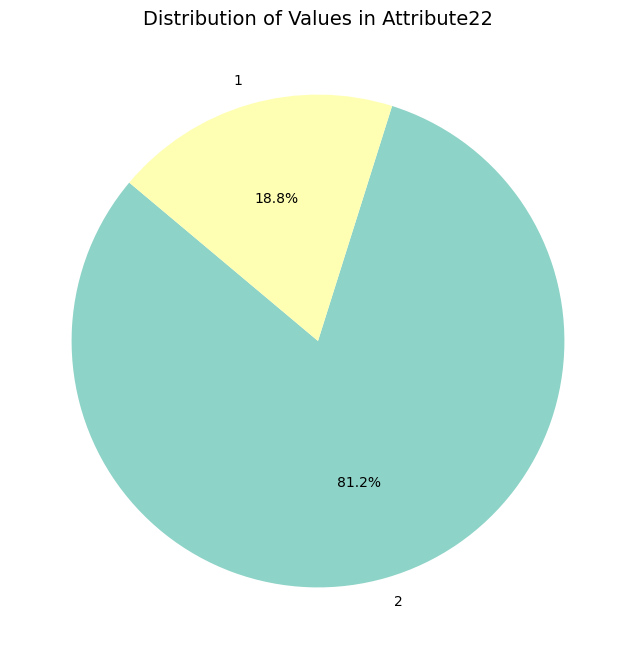

In [102]:
# Retrieve the value counts of 'Attribute22' from the dataframe
attribute22_counts = df['Attribute22'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute22_counts, labels=attribute22_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute22_counts)))

# Add a title
plt.title('Distribution of Values in Attribute22', fontsize=14)

# Display the chart
plt.show()

In [103]:
# Creating a cross-tabulation table of counts for Attribute22 against class
Attribute22_class_counts = pd.crosstab(df['Attribute22'], df['class'])
Attribute22_class_counts

class        1   2  3
Attribute22          
1            1   2  3
2            8  11  7

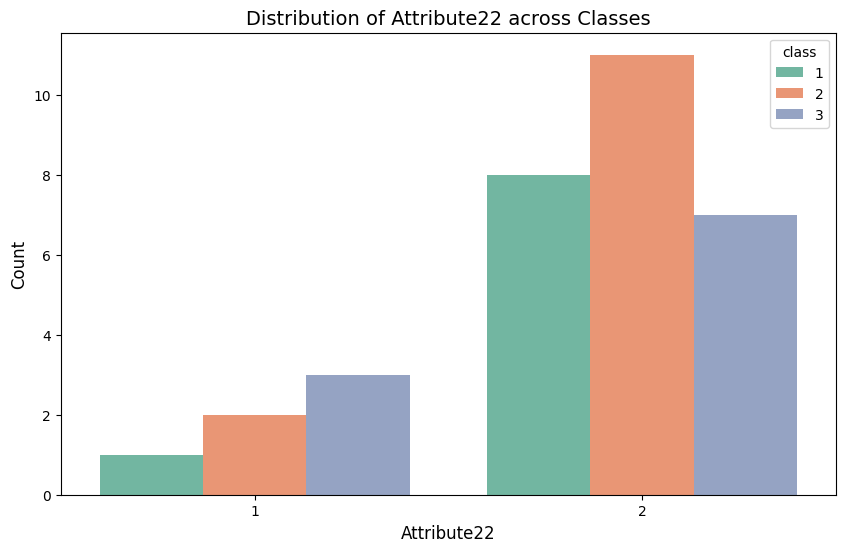

In [104]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute22' grouped by 'class'
sns.countplot(data=df, x='Attribute22', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute22 across Classes', fontsize=14)
plt.xlabel('Attribute22', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute23

In [105]:
# Counting the occurrences of each value in the 'Attribute23' column
Attribute23_counts = df['Attribute23'].value_counts()
Attribute23_counts

Attribute23
2    24
1     8
Name: count, dtype: int64

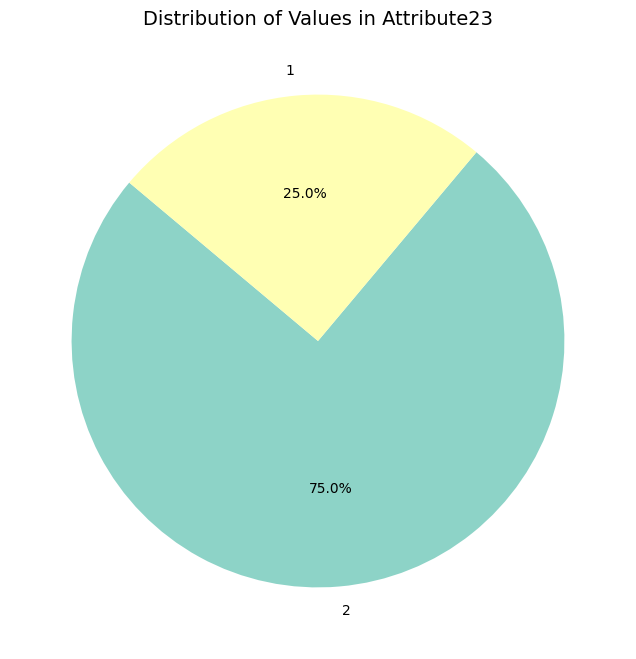

In [106]:
# Retrieve the value counts of 'Attribute23' from the dataframe
attribute23_counts = df['Attribute23'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute23_counts, labels=attribute23_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute23_counts)))

# Add a title
plt.title('Distribution of Values in Attribute23', fontsize=14)

# Display the chart
plt.show()

In [107]:
# Creating a cross-tabulation table of counts for Attribute23 against class
Attribute23_class_counts = pd.crosstab(df['Attribute23'], df['class'])
Attribute23_class_counts

class        1   2  3
Attribute23          
1            0   2  6
2            9  11  4

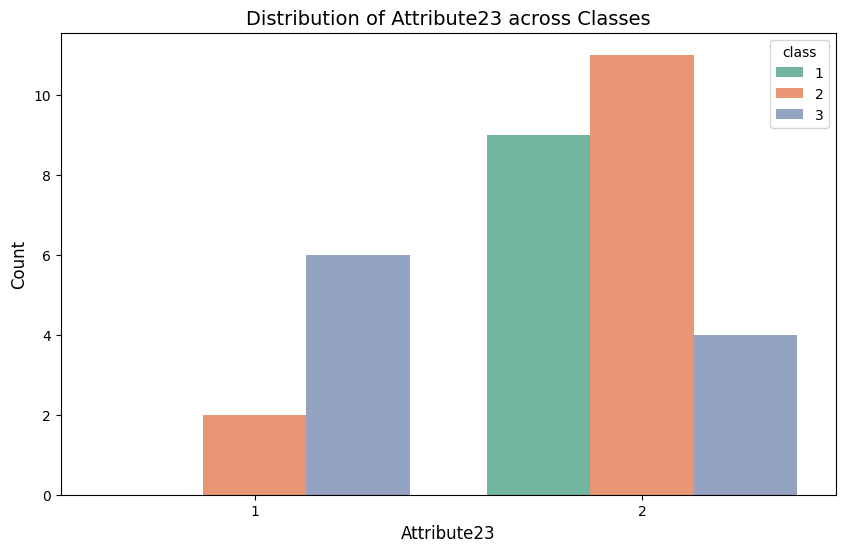

In [108]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute23' grouped by 'class'
sns.countplot(data=df, x='Attribute23', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute23 across Classes', fontsize=14)
plt.xlabel('Attribute23', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute24

In [109]:
# Counting the occurrences of each value in the 'Attribute24' column
Attribute24_counts = df['Attribute24'].value_counts()
Attribute24_counts

Attribute24
1    24
2     5
3     3
Name: count, dtype: int64

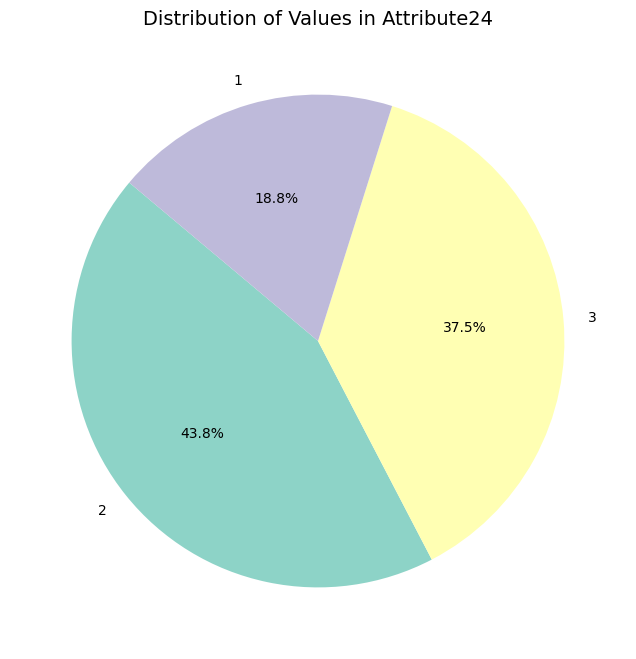

In [110]:
# Retrieve the value counts of 'Attribute24' from the dataframe
attribute24_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute24_counts, labels=attribute24_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute24_counts)))

# Add a title
plt.title('Distribution of Values in Attribute24', fontsize=14)

# Display the chart
plt.show()

In [111]:
# Creating a cross-tabulation table of counts for Attribute24 against class
Attribute24_class_counts = pd.crosstab(df['Attribute24'], df['class'])
Attribute24_class_counts

class        1   2  3
Attribute24          
1            6  10  8
2            3   1  1
3            0   2  1

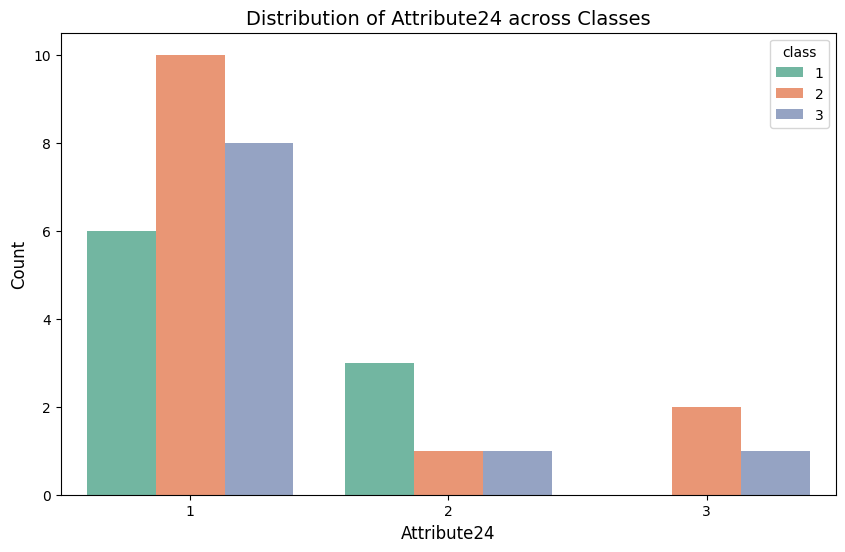

In [112]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute24' grouped by 'class'
sns.countplot(data=df, x='Attribute24', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute24 across Classes', fontsize=14)
plt.xlabel('Attribute24', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute25

In [113]:
# Counting the occurrences of each value in the 'Attribute25' column
Attribute25_counts = df['Attribute25'].value_counts()
Attribute25_counts

Attribute25
2    19
1    11
3     2
Name: count, dtype: int64

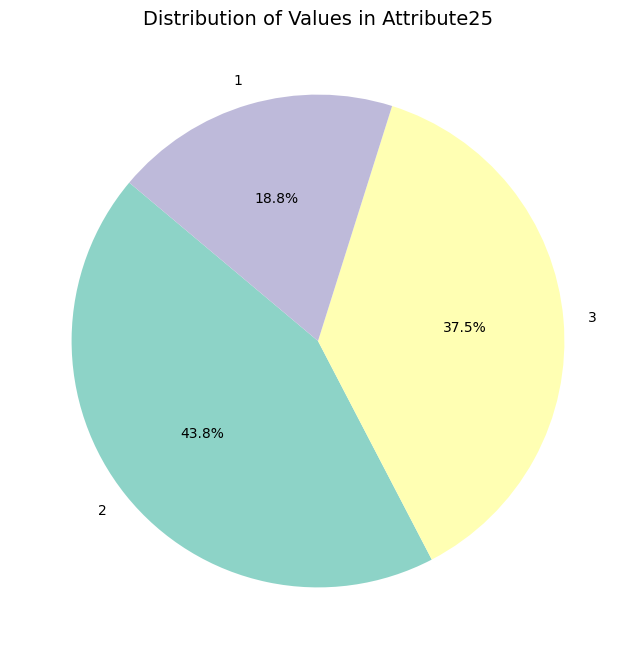

In [114]:
# Retrieve the value counts of 'Attribute25' from the dataframe
attribute25_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute25_counts, labels=attribute25_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute25_counts)))

# Add a title
plt.title('Distribution of Values in Attribute25', fontsize=14)

# Display the chart
plt.show()

In [115]:
# Creating a cross-tabulation table of counts for Attribute25 against class
Attribute25_class_counts = pd.crosstab(df['Attribute25'], df['class'])
Attribute25_class_counts

class        1  2  3
Attribute25         
1            4  3  4
2            5  9  5
3            0  1  1

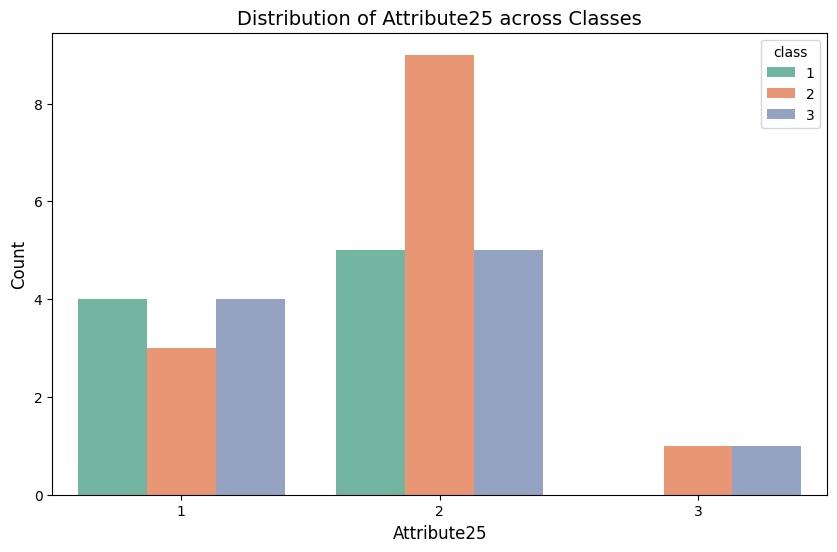

In [116]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute25' grouped by 'class'
sns.countplot(data=df, x='Attribute25', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute25 across Classes', fontsize=14)
plt.xlabel('Attribute25', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute26

In [117]:
# Counting the occurrences of each value in the 'Attribute26' column
Attribute26_counts = df['Attribute26'].value_counts()
Attribute26_counts

Attribute26
2    12
1    11
3     9
Name: count, dtype: int64

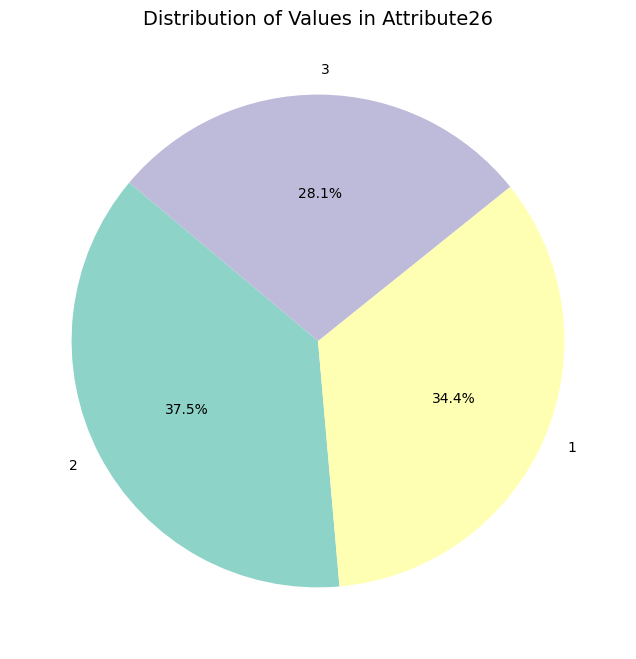

In [118]:
# Retrieve the value counts of 'Attribute6' from the dataframe
attribute26_counts = df['Attribute26'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute26_counts, labels=attribute26_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute26_counts)))

# Add a title
plt.title('Distribution of Values in Attribute26', fontsize=14)

# Display the chart
plt.show()

In [119]:
# Creating a cross-tabulation table of counts for Attribute26 against class
Attribute26_class_counts = pd.crosstab(df['Attribute26'], df['class'])
Attribute26_class_counts

class        1  2  3
Attribute26         
1            3  5  3
2            3  4  5
3            3  4  2

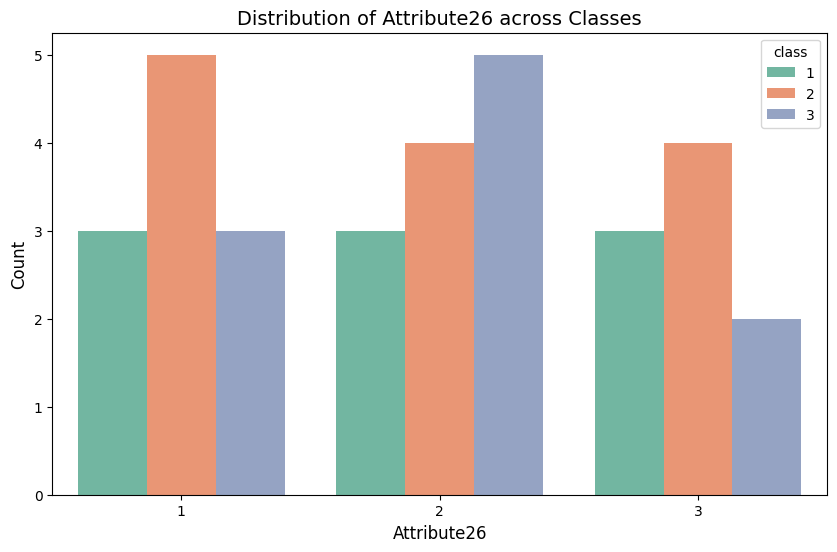

In [120]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute26' grouped by 'class'
sns.countplot(data=df, x='Attribute26', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute26 across Classes', fontsize=14)
plt.xlabel('Attribute26', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute27

In [121]:
# Counting the occurrences of each value in the 'Attribute27' column
Attribute27_counts = df['Attribute27'].value_counts()
Attribute27_counts

Attribute27
2    22
3    10
Name: count, dtype: int64

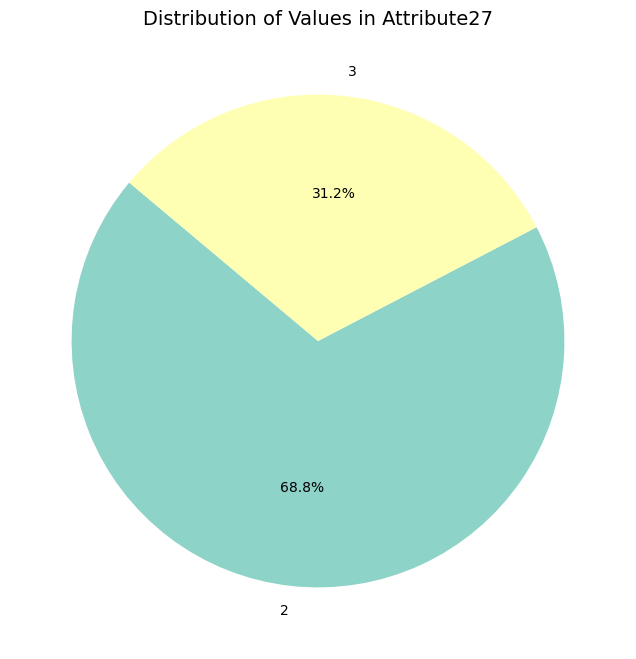

In [122]:
# Retrieve the value counts of 'Attribute27' from the dataframe
attribute27_counts = df['Attribute27'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute27_counts, labels=attribute27_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute27_counts)))

# Add a title
plt.title('Distribution of Values in Attribute27', fontsize=14)

# Display the chart
plt.show()

In [123]:
# Creating a cross-tabulation table of counts for Attribute27 against class
Attribute27_class_counts = pd.crosstab(df['Attribute27'], df['class'])
Attribute27_class_counts

class        1  2  3
Attribute27         
2            4  9  9
3            5  4  1

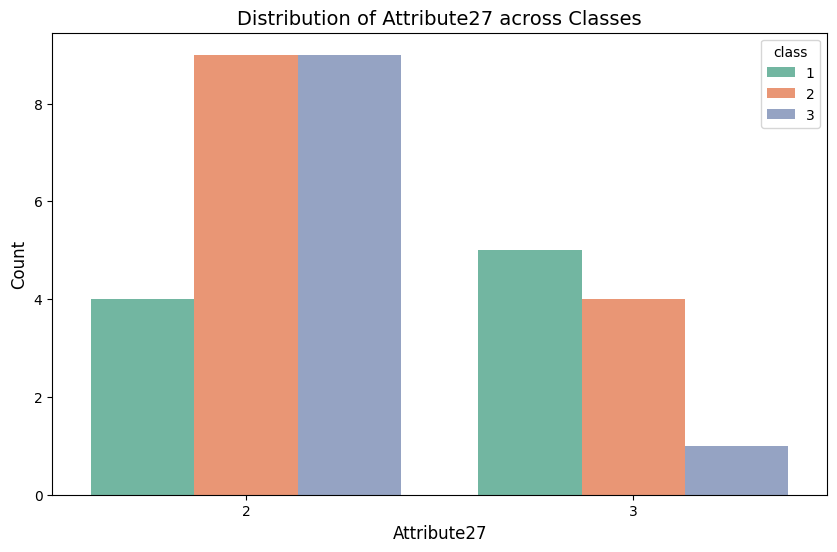

In [124]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute27' grouped by 'class'
sns.countplot(data=df, x='Attribute27', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute27 across Classes', fontsize=14)
plt.xlabel('Attribute27', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute28

In [125]:
# Counting the occurrences of each value in the 'Attribute28' column
Attribute28_counts = df['Attribute28'].value_counts()
Attribute28_counts

Attribute28
2    22
3     6
1     4
Name: count, dtype: int64

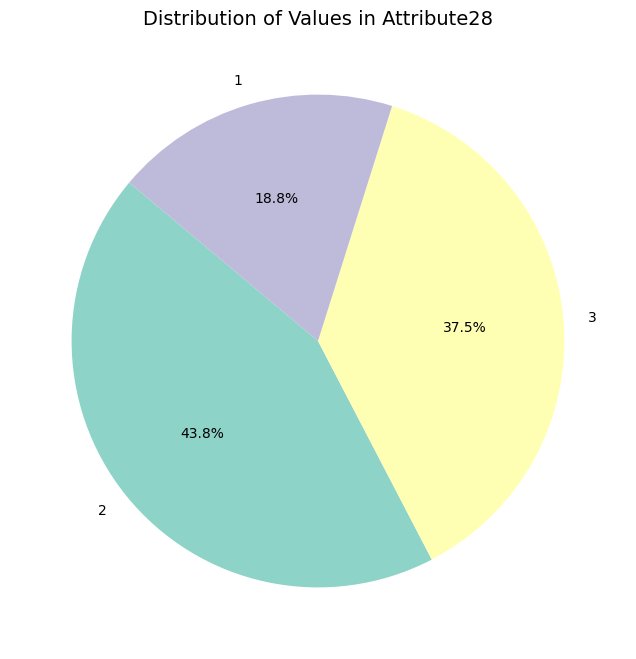

In [126]:
# Retrieve the value counts of 'Attribute28' from the dataframe
attribute28_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute28_counts, labels=attribute28_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute28_counts)))

# Add a title
plt.title('Distribution of Values in Attribute28', fontsize=14)

# Display the chart
plt.show()

In [127]:
# Creating a cross-tabulation table of counts for Attribute28 against class
Attribute28_class_counts = pd.crosstab(df['Attribute28'], df['class'])
Attribute28_class_counts

class        1   2  3
Attribute28          
1            2   0  2
2            5  10  7
3            2   3  1

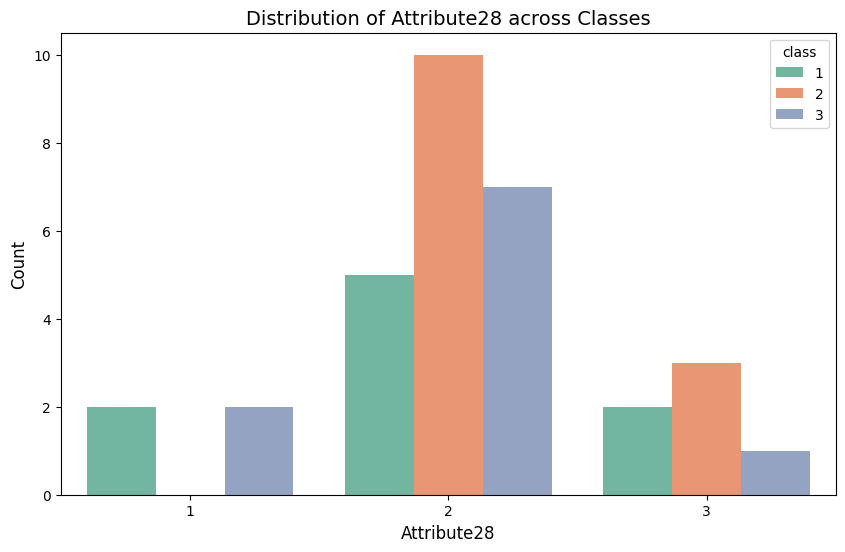

In [128]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute28' grouped by 'class'
sns.countplot(data=df, x='Attribute28', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute28 across Classes', fontsize=14)
plt.xlabel('Attribute28', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute29

In [129]:
# Counting the occurrences of each value in the 'Attribute29' column
Attribute29_counts = df['Attribute29'].value_counts()
Attribute29_counts

Attribute29
2    17
3    10
1     5
Name: count, dtype: int64

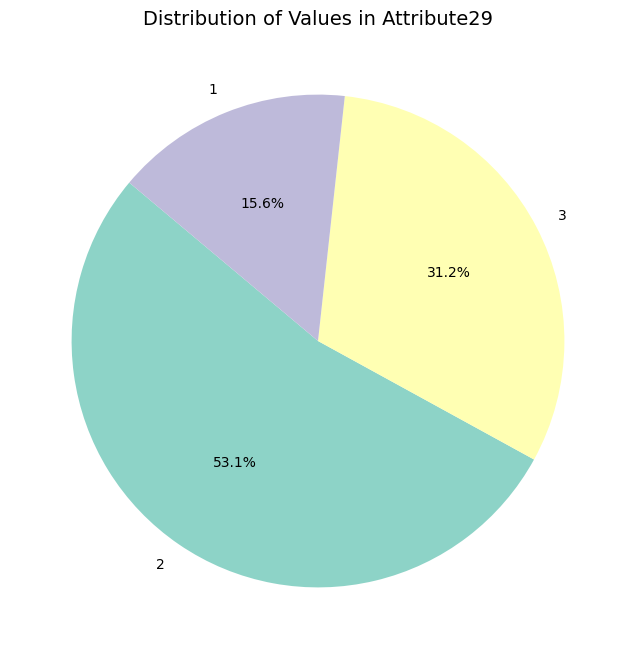

In [130]:
# Retrieve the value counts of 'Attribute29' from the dataframe
attribute29_counts = df['Attribute29'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute29_counts, labels=attribute29_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute29_counts)))

# Add a title
plt.title('Distribution of Values in Attribute29', fontsize=14)

# Display the chart
plt.show()

In [131]:
# Creating a cross-tabulation table of counts for Attribute29 against class
Attribute29_class_counts = pd.crosstab(df['Attribute29'], df['class'])
Attribute29_class_counts

class        1  2  3
Attribute29         
1            2  1  2
2            4  7  6
3            3  5  2

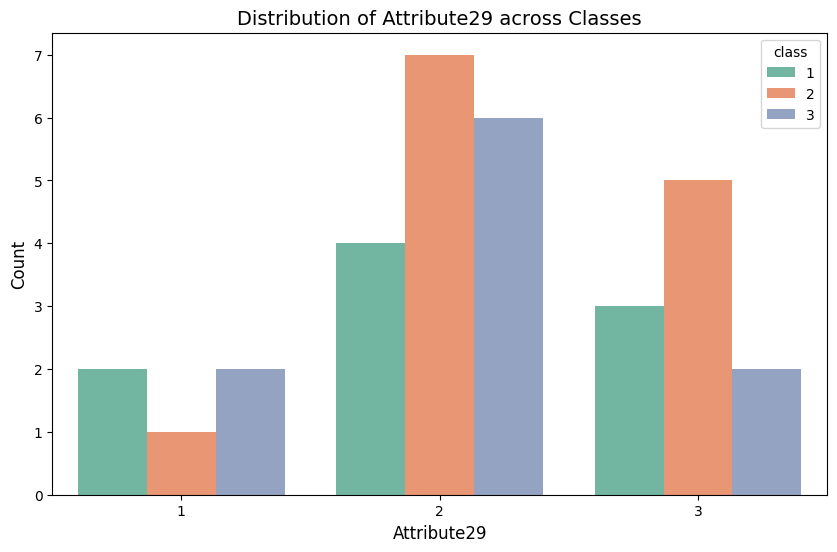

In [132]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute29' grouped by 'class'
sns.countplot(data=df, x='Attribute29', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute29 across Classes', fontsize=14)
plt.xlabel('Attribute29', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute30

In [133]:
# Counting the occurrences of each value in the 'Attribute30' column
Attribute30_counts = df['Attribute30'].value_counts()
Attribute30_counts

Attribute30
1    22
2     6
3     4
Name: count, dtype: int64

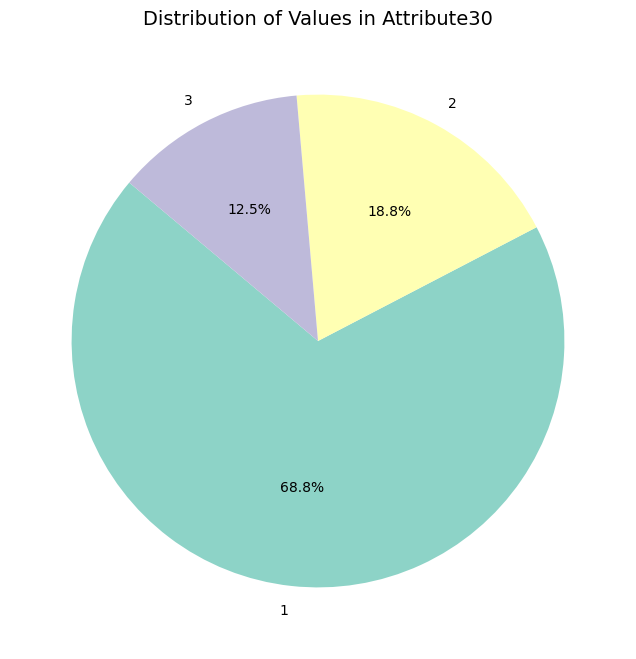

In [134]:
# Retrieve the value counts of 'Attribute30' from the dataframe
attribute30_counts = df['Attribute30'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute30_counts, labels=attribute30_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute30_counts)))

# Add a title
plt.title('Distribution of Values in Attribute30', fontsize=14)

# Display the chart
plt.show()

In [135]:
# Creating a cross-tabulation table of counts for Attribute30 against class
Attribute30_class_counts = pd.crosstab(df['Attribute30'], df['class'])
Attribute30_class_counts

class        1  2  3
Attribute30         
1            7  9  6
2            2  1  3
3            0  3  1

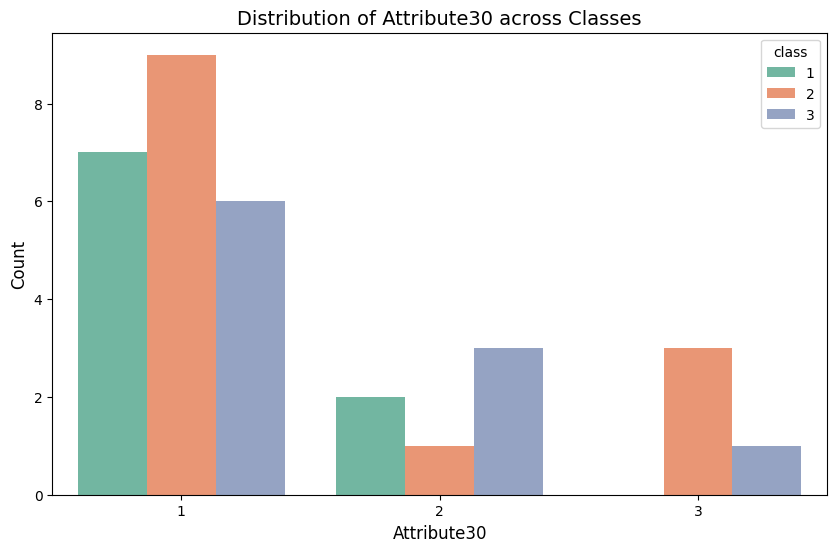

In [136]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute30' grouped by 'class'
sns.countplot(data=df, x='Attribute30', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute30 across Classes', fontsize=14)
plt.xlabel('Attribute30', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute31

In [137]:
# Counting the occurrences of each value in the 'Attribute31' column
Attribute31_counts = df['Attribute31'].value_counts()
Attribute31_counts

Attribute31
3    19
1     9
2     4
Name: count, dtype: int64

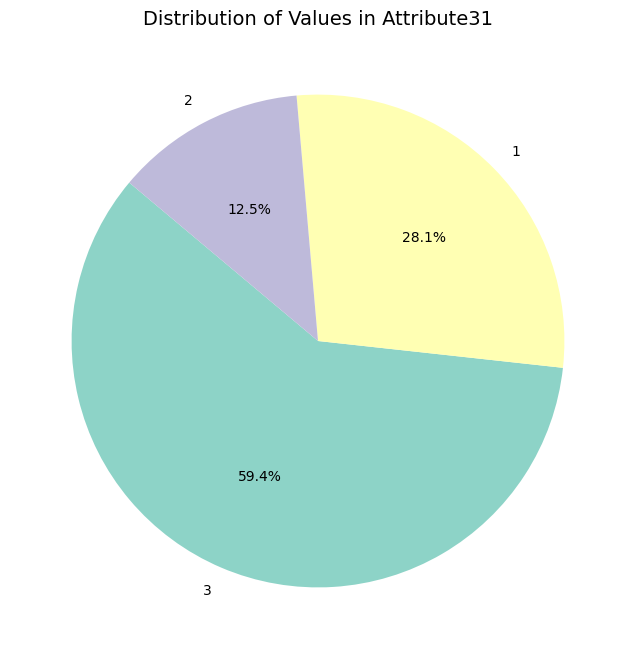

In [138]:
# Retrieve the value counts of 'Attribute31' from the dataframe
attribute31_counts = df['Attribute31'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute31_counts, labels=attribute31_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute31_counts)))

# Add a title
plt.title('Distribution of Values in Attribute31', fontsize=14)

# Display the chart
plt.show()

In [139]:
# Creating a cross-tabulation table of counts for Attribute31 against class
Attribute31_class_counts = pd.crosstab(df['Attribute31'], df['class'])
Attribute31_class_counts

class        1  2  3
Attribute31         
1            3  4  2
2            0  1  3
3            6  8  5

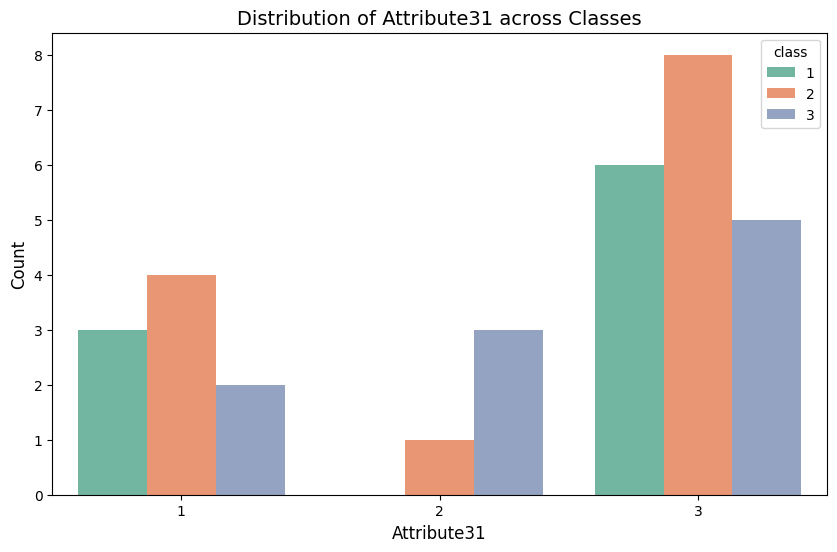

In [140]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute31' grouped by 'class'
sns.countplot(data=df, x='Attribute31', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute31 across Classes', fontsize=14)
plt.xlabel('Attribute31', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute32

In [141]:
# Counting the occurrences of each value in the 'Attribute32' column
Attribute32_counts = df['Attribute6'].value_counts()
Attribute32_counts

Attribute6
2    14
3    12
1     6
Name: count, dtype: int64

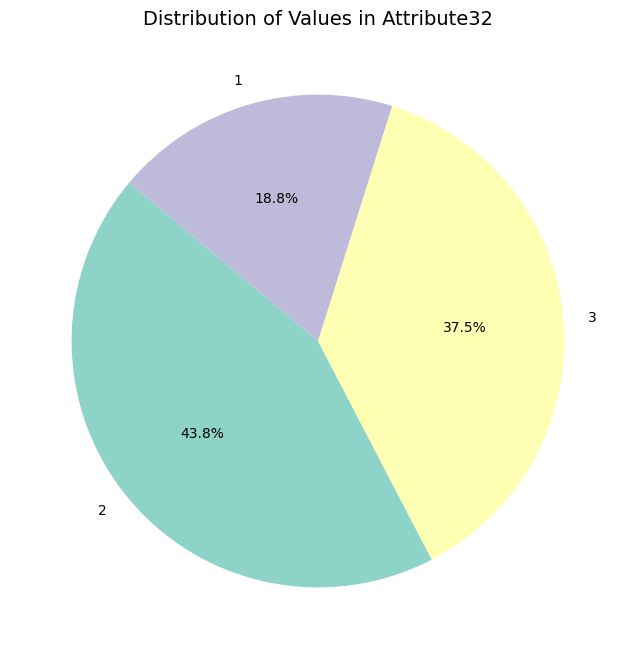

In [142]:
# Retrieve the value counts of 'Attribute32' from the dataframe
attribute32_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute32_counts, labels=attribute32_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute32_counts)))

# Add a title
plt.title('Distribution of Values in Attribute32', fontsize=14)

# Display the chart
plt.show()

In [143]:
# Creating a cross-tabulation table of counts for Attribute32 against class
Attribute32_class_counts = pd.crosstab(df['Attribute32'], df['class'])
Attribute32_class_counts

class        1  2  3
Attribute32         
1            3  4  2
2            0  1  3
3            6  8  5

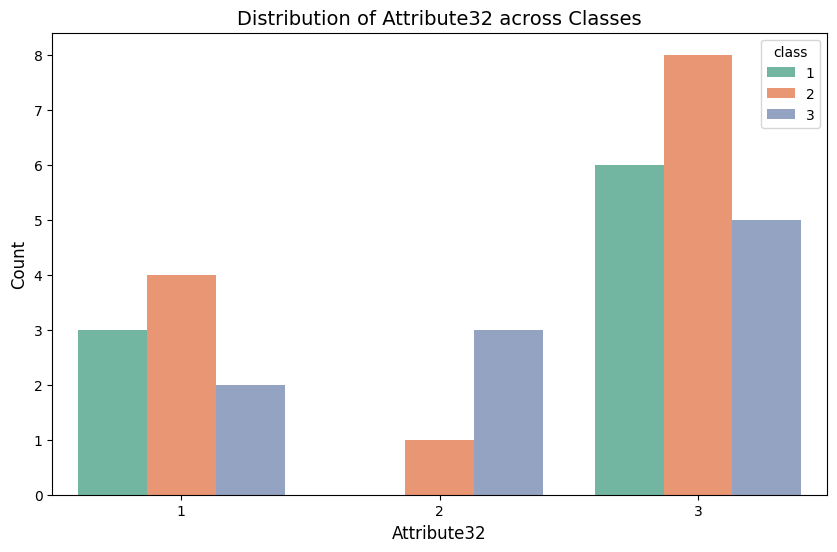

In [144]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute32' grouped by 'class'
sns.countplot(data=df, x='Attribute32', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute32 across Classes', fontsize=14)
plt.xlabel('Attribute32', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute33

In [145]:
# Counting the occurrences of each value in the 'Attribute33' column
Attribute33_counts = df['Attribute33'].value_counts()
Attribute33_counts

Attribute33
3    26
1     3
2     3
Name: count, dtype: int64

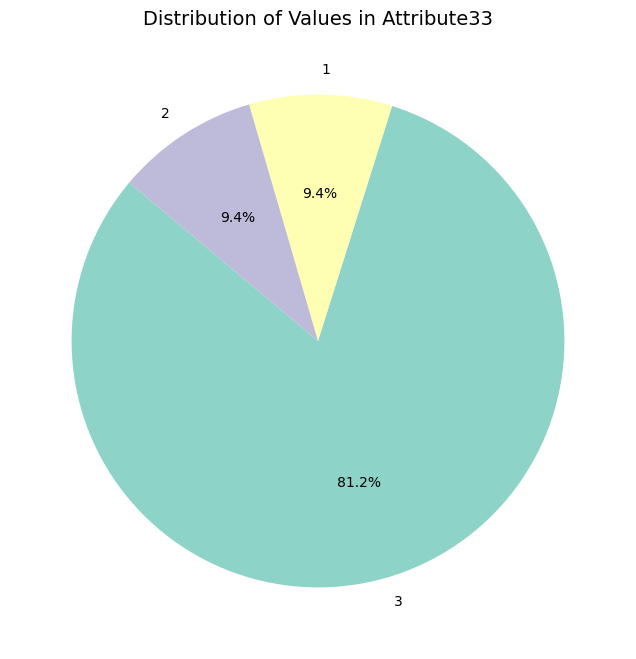

In [146]:
# Retrieve the value counts of 'Attribute33' from the dataframe
attribute33_counts = df['Attribute33'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute33_counts, labels=attribute33_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute33_counts)))

# Add a title
plt.title('Distribution of Values in Attribute33', fontsize=14)

# Display the chart
plt.show()

In [147]:
# Creating a cross-tabulation table of counts for Attribute33 against class
Attribute33_class_counts = pd.crosstab(df['Attribute33'], df['class'])
Attribute33_class_counts

class        1   2  3
Attribute33          
1            0   1  2
2            0   0  3
3            9  12  5

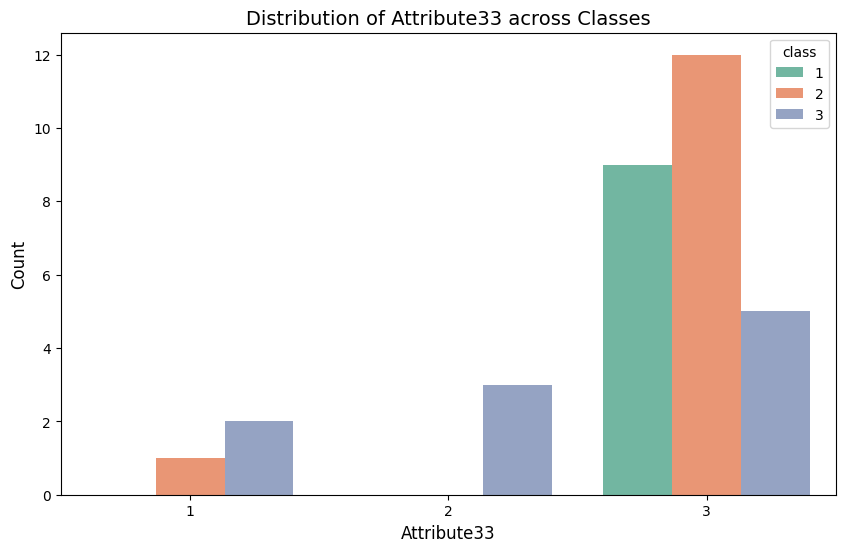

In [148]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute33' grouped by 'class'
sns.countplot(data=df, x='Attribute33', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute33 across Classes', fontsize=14)
plt.xlabel('Attribute33', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute34

In [149]:
# Counting the occurrences of each value in the 'Attribute34' column
Attribute34_counts = df['Attribute34'].value_counts()
Attribute34_counts

Attribute34
1    14
2    13
3     5
Name: count, dtype: int64

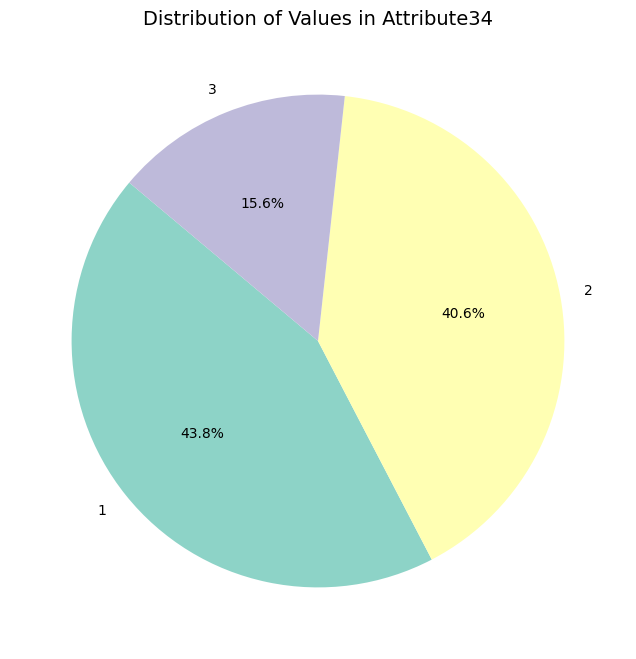

In [150]:
# Retrieve the value counts of 'Attribute34' from the dataframe
attribute34_counts = df['Attribute34'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute34_counts, labels=attribute34_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute34_counts)))

# Add a title
plt.title('Distribution of Values in Attribute34', fontsize=14)

# Display the chart
plt.show()

In [151]:
# Creating a cross-tabulation table of counts for Attribute34 against class
Attribute34_class_counts = pd.crosstab(df['Attribute34'], df['class'])
Attribute34_class_counts

class        1  2  3
Attribute34         
1            2  8  4
2            4  4  5
3            3  1  1

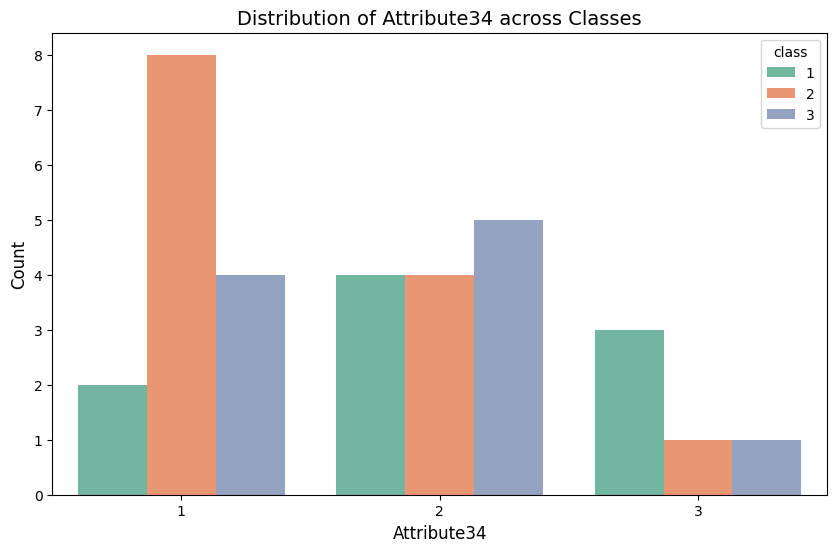

In [152]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute34' grouped by 'class'
sns.countplot(data=df, x='Attribute34', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute34 across Classes', fontsize=14)
plt.xlabel('Attribute34', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute35

In [153]:
# Counting the occurrences of each value in the 'Attribute35' column
Attribute6_counts = df['Attribute35'].value_counts()
Attribute6_counts

Attribute35
1    16
2    12
3     4
Name: count, dtype: int64

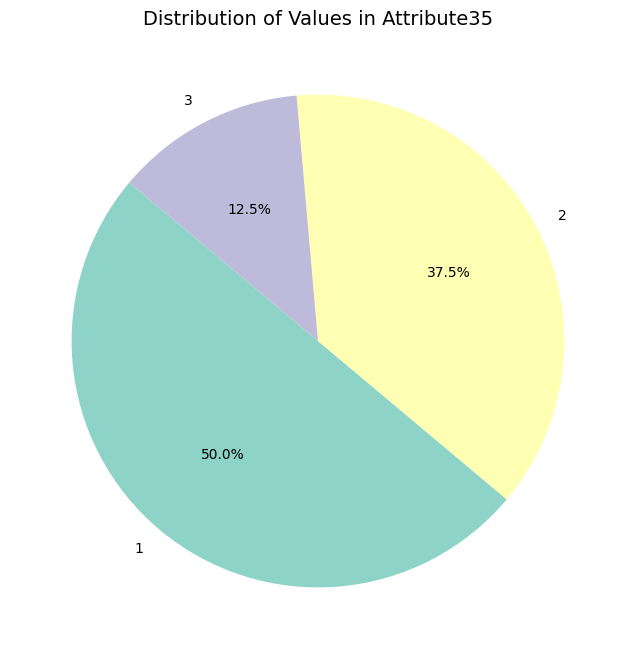

In [154]:
# Retrieve the value counts of 'Attribute35' from the dataframe
attribute35_counts = df['Attribute35'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute35_counts, labels=attribute35_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute35_counts)))

# Add a title
plt.title('Distribution of Values in Attribute35', fontsize=14)

# Display the chart
plt.show()

In [155]:
# Creating a cross-tabulation table of counts for Attribute35 against class
Attribute35_class_counts = pd.crosstab(df['Attribute35'], df['class'])
Attribute35_class_counts

class        1  2  3
Attribute35         
1            4  6  6
2            5  4  3
3            0  3  1

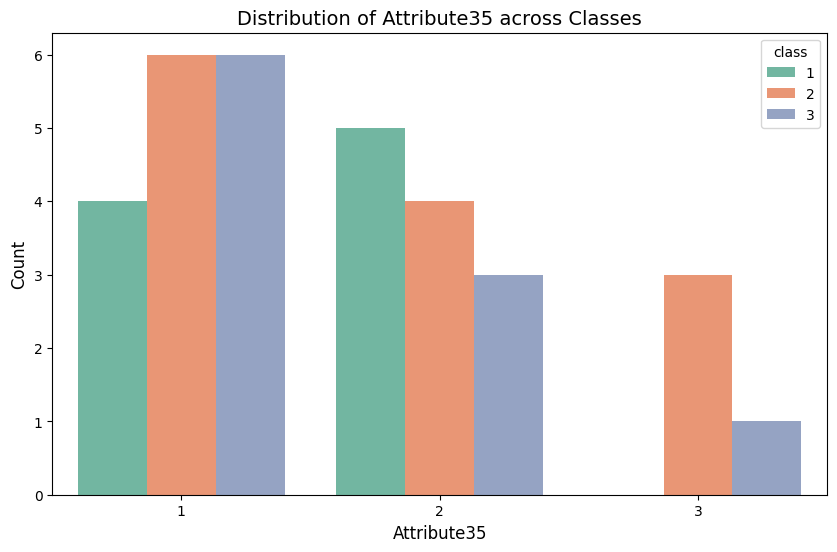

In [156]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute6' grouped by 'class'
sns.countplot(data=df, x='Attribute35', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute35 across Classes', fontsize=14)
plt.xlabel('Attribute35', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute36

In [157]:
# Counting the occurrences of each value in the 'Attribute36' column
Attribute36_counts = df['Attribute36'].value_counts()
Attribute36_counts

Attribute36
2    20
1    11
3     1
Name: count, dtype: int64

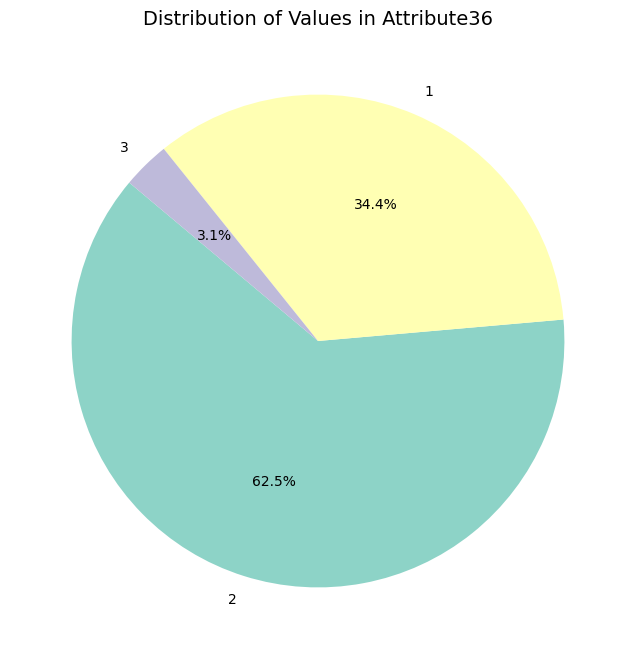

In [158]:
# Retrieve the value counts of 'Attribute36' from the dataframe
attribute36_counts = df['Attribute36'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute36_counts, labels=attribute36_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute36_counts)))

# Add a title
plt.title('Distribution of Values in Attribute36', fontsize=14)

# Display the chart
plt.show()

In [159]:
# Creating a cross-tabulation table of counts for Attribute36 against class
Attribute36_class_counts = pd.crosstab(df['Attribute36'], df['class'])
Attribute36_class_counts

class        1  2  3
Attribute36         
1            3  5  3
2            6  8  6
3            0  0  1

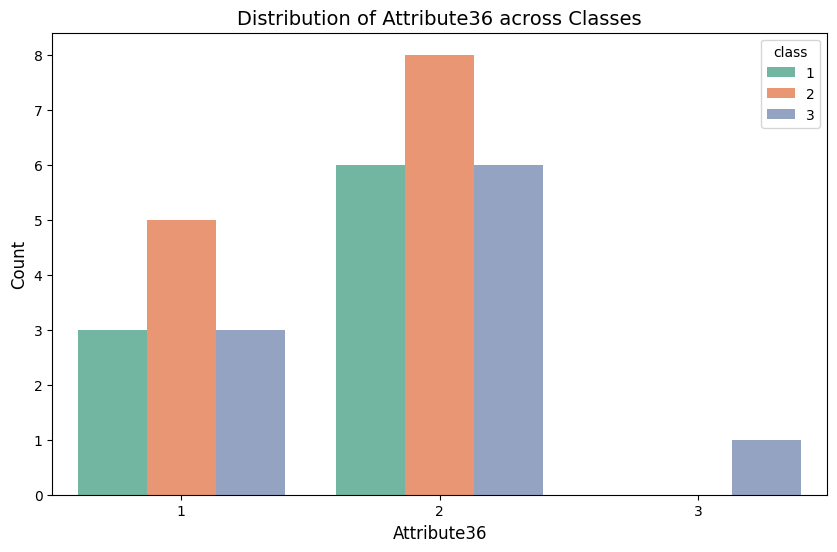

In [160]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute36' grouped by 'class'
sns.countplot(data=df, x='Attribute36', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute36 across Classes', fontsize=14)
plt.xlabel('Attribute36', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute37

In [161]:
# Counting the occurrences of each value in the 'Attribute37' column
Attribute37_counts = df['Attribute37'].value_counts()
Attribute37_counts

Attribute37
1    14
2    14
3     4
Name: count, dtype: int64

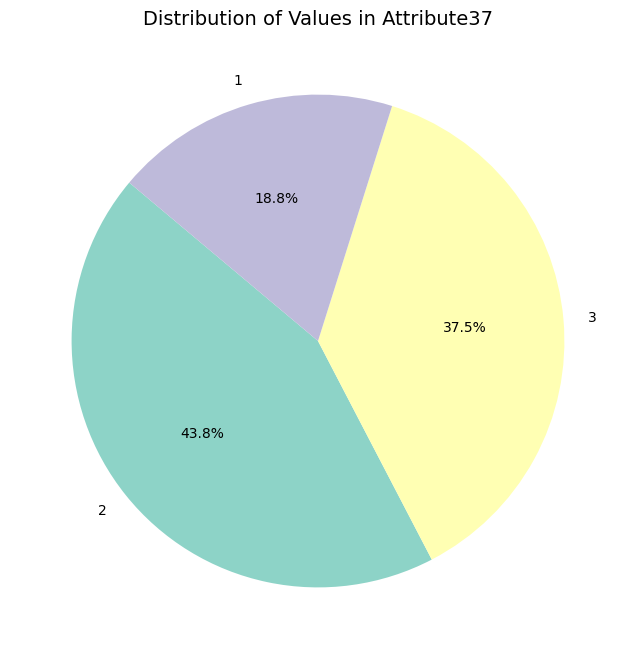

In [162]:
# Retrieve the value counts of 'Attribute37' from the dataframe
attribute37_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute37_counts, labels=attribute37_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute37_counts)))

# Add a title
plt.title('Distribution of Values in Attribute37', fontsize=14)

# Display the chart
plt.show()

In [163]:
# Creating a cross-tabulation table of counts for Attribute37 against class
Attribute37_class_counts = pd.crosstab(df['Attribute37'], df['class'])
Attribute37_class_counts

class        1  2  3
Attribute37         
1            4  8  2
2            5  5  4
3            0  0  4

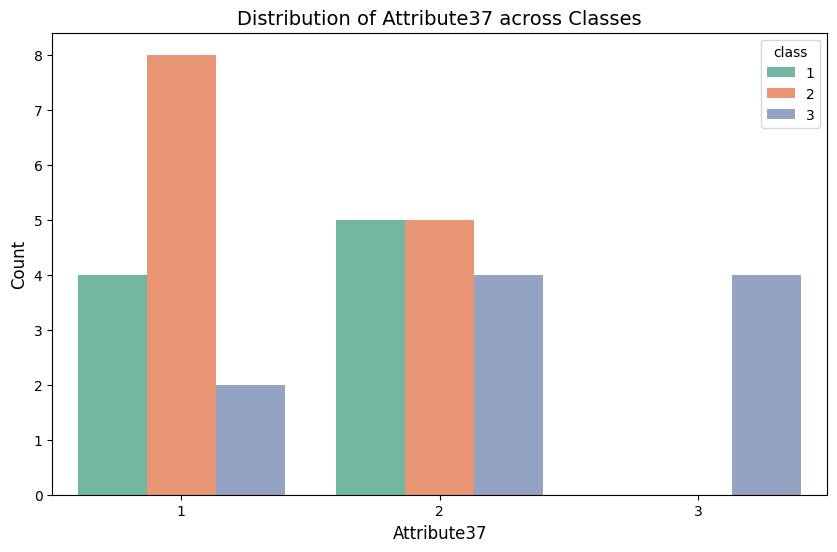

In [164]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute37' grouped by 'class'
sns.countplot(data=df, x='Attribute37', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute37 across Classes', fontsize=14)
plt.xlabel('Attribute37', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute38

In [165]:
# Counting the occurrences of each value in the 'Attribute38' column
Attribute38_counts = df['Attribute38'].value_counts()
Attribute38_counts

Attribute38
2.0    18
1.0    11
3.0     2
Name: count, dtype: int64

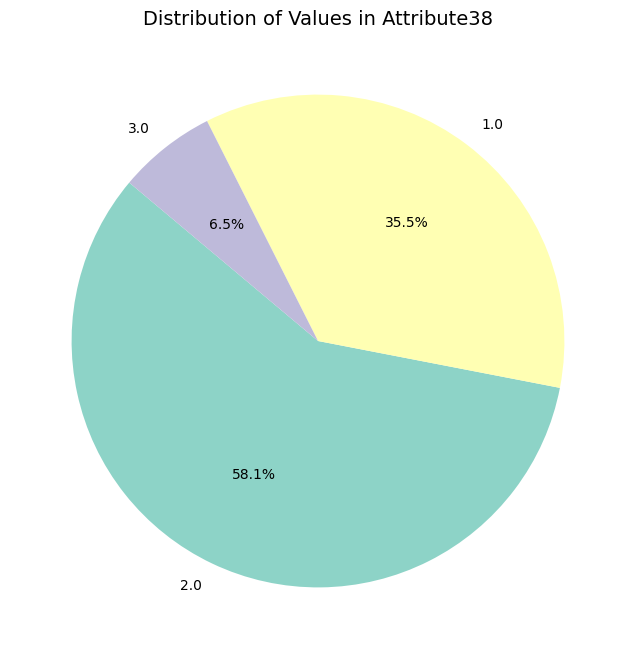

In [166]:
# Retrieve the value counts of 'Attribute38' from the dataframe
attribute38_counts = df['Attribute38'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute38_counts, labels=attribute38_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute38_counts)))

# Add a title
plt.title('Distribution of Values in Attribute38', fontsize=14)

# Display the chart
plt.show()

In [167]:
# Creating a cross-tabulation table of counts for Attribute38 against class
Attribute38_class_counts = pd.crosstab(df['Attribute38'], df['class'])
Attribute38_class_counts

class        1  2  3
Attribute38         
1.0          4  4  3
2.0          5  9  4
3.0          0  0  2

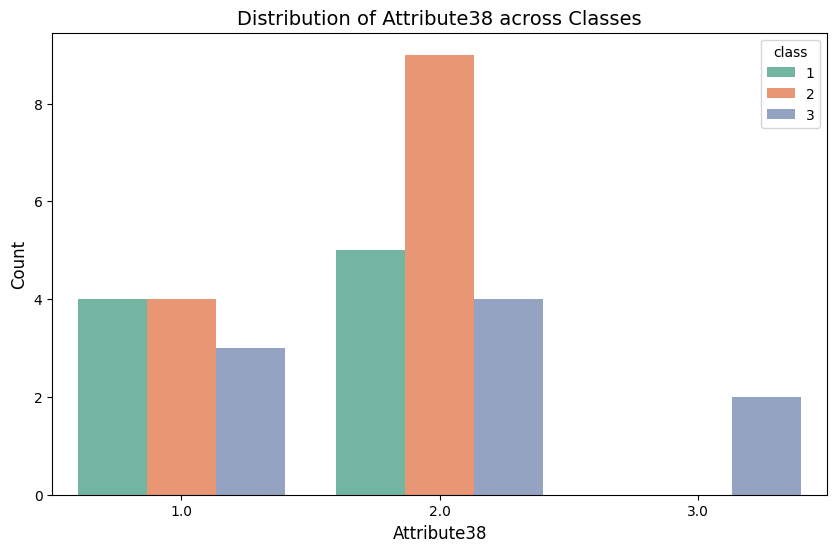

In [168]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute38' grouped by 'class'
sns.countplot(data=df, x='Attribute38', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute38 across Classes', fontsize=14)
plt.xlabel('Attribute38', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute39

In [169]:
# Counting the occurrences of each value in the 'Attribute39' column
Attribute39_counts = df['Attribute39'].value_counts()
Attribute39_counts

Attribute39
2    25
1     4
3     3
Name: count, dtype: int64

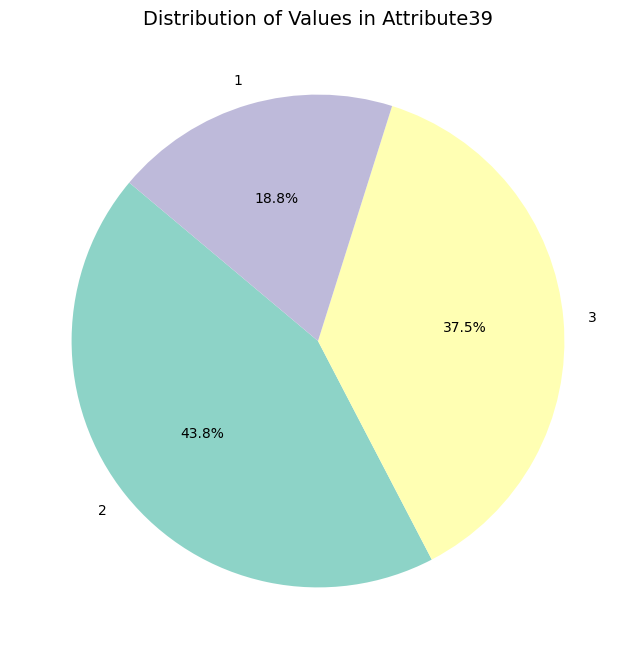

In [170]:
# Retrieve the value counts of 'Attribute39' from the dataframe
attribute39_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute39_counts, labels=attribute39_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute39_counts)))

# Add a title
plt.title('Distribution of Values in Attribute39', fontsize=14)

# Display the chart
plt.show()

In [171]:
# Creating a cross-tabulation table of counts for Attribute39 against class
Attribute39_class_counts = pd.crosstab(df['Attribute39'], df['class'])
Attribute39_class_counts

class        1   2  3
Attribute39          
1            1   2  1
2            8  11  6
3            0   0  3

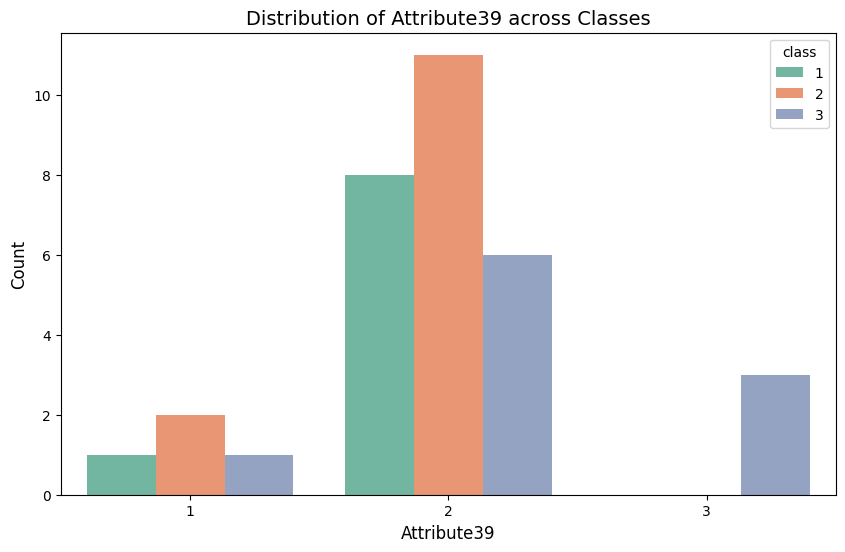

In [172]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute39' grouped by 'class'
sns.countplot(data=df, x='Attribute39', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute39 across Classes', fontsize=14)
plt.xlabel('Attribute39', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute40

In [173]:
# Counting the occurrences of each value in the 'Attribute40' column
Attribute40_counts = df['Attribute40'].value_counts()
Attribute40_counts

Attribute40
2    26
3     3
1     3
Name: count, dtype: int64

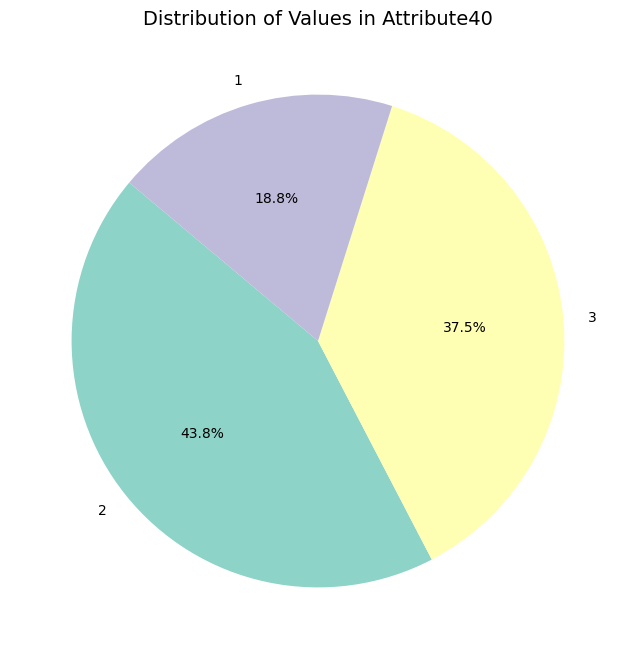

In [174]:
# Retrieve the value counts of 'Attribute40' from the dataframe
attribute40_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute40_counts, labels=attribute40_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute40_counts)))

# Add a title
plt.title('Distribution of Values in Attribute40', fontsize=14)

# Display the chart
plt.show()

In [175]:
# Creating a cross-tabulation table of counts for Attribute40 against class
Attribute40_class_counts = pd.crosstab(df['Attribute40'], df['class'])
Attribute40_class_counts

class        1   2  3
Attribute40          
1            0   0  3
2            9  13  4
3            0   0  3

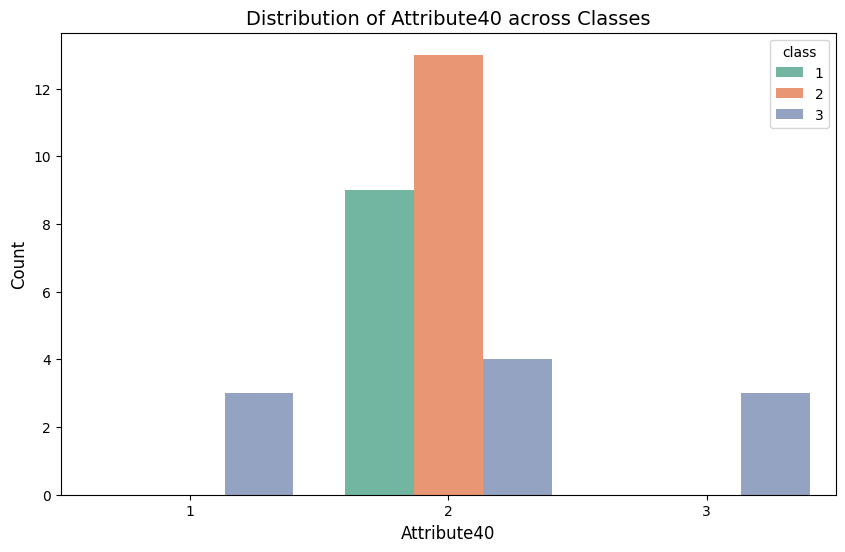

In [176]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute40' grouped by 'class'
sns.countplot(data=df, x='Attribute40', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute40 across Classes', fontsize=14)
plt.xlabel('Attribute40', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute41

In [177]:
# Counting the occurrences of each value in the 'Attribute41' column
Attribute41_counts = df['Attribute41'].value_counts()
Attribute41_counts

Attribute41
1    15
2    15
3     2
Name: count, dtype: int64

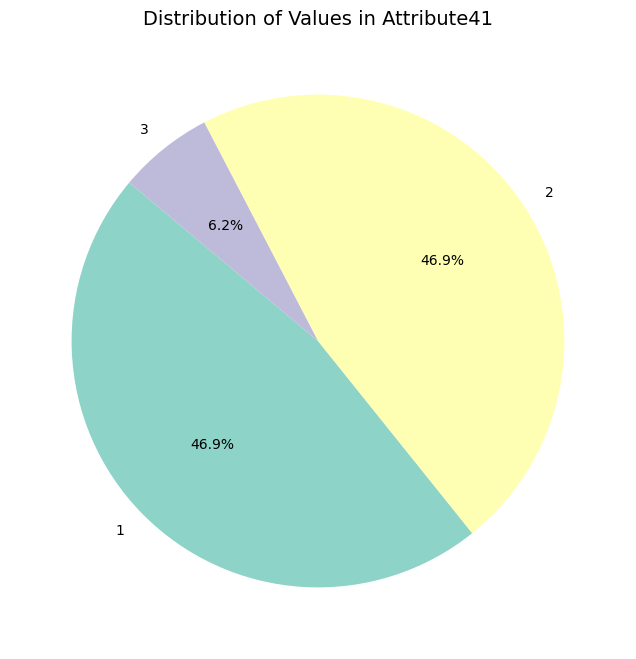

In [178]:
# Retrieve the value counts of 'Attribute41' from the dataframe
attribute41_counts = df['Attribute41'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute41_counts, labels=attribute41_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute41_counts)))

# Add a title
plt.title('Distribution of Values in Attribute41', fontsize=14)

# Display the chart
plt.show()

In [179]:
# Creating a cross-tabulation table of counts for Attribute41 against class
Attribute41_class_counts = pd.crosstab(df['Attribute41'], df['class'])
Attribute41_class_counts

class        1  2  3
Attribute41         
1            5  6  4
2            4  7  4
3            0  0  2

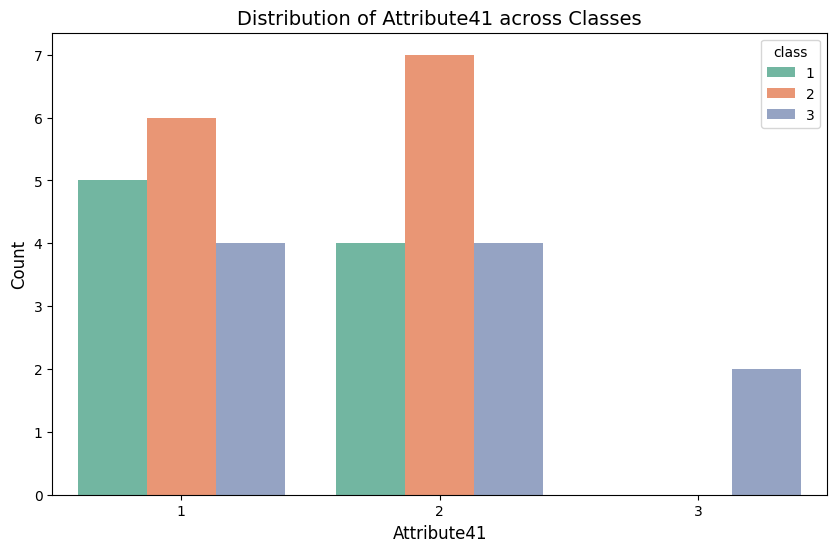

In [180]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute41' grouped by 'class'
sns.countplot(data=df, x='Attribute41', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute41 across Classes', fontsize=14)
plt.xlabel('Attribute41', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute42

In [181]:
# Counting the occurrences of each value in the 'Attribute42' column
Attribute42_counts = df['Attribute42'].value_counts()
Attribute42_counts

Attribute42
2    18
1    11
3     3
Name: count, dtype: int64

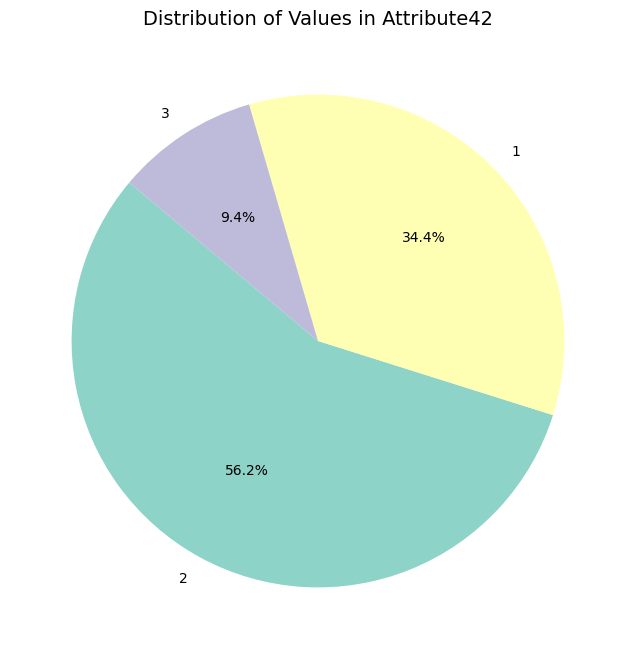

In [182]:
# Retrieve the value counts of 'Attribute42' from the dataframe
attribute42_counts = df['Attribute42'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute42_counts, labels=attribute42_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute42_counts)))

# Add a title
plt.title('Distribution of Values in Attribute42', fontsize=14)

# Display the chart
plt.show()

In [183]:
# Creating a cross-tabulation table of counts for Attribute42 against class
Attribute42_class_counts = pd.crosstab(df['Attribute42'], df['class'])
Attribute42_class_counts

class        1  2  3
Attribute42         
1            4  5  2
2            5  7  6
3            0  1  2

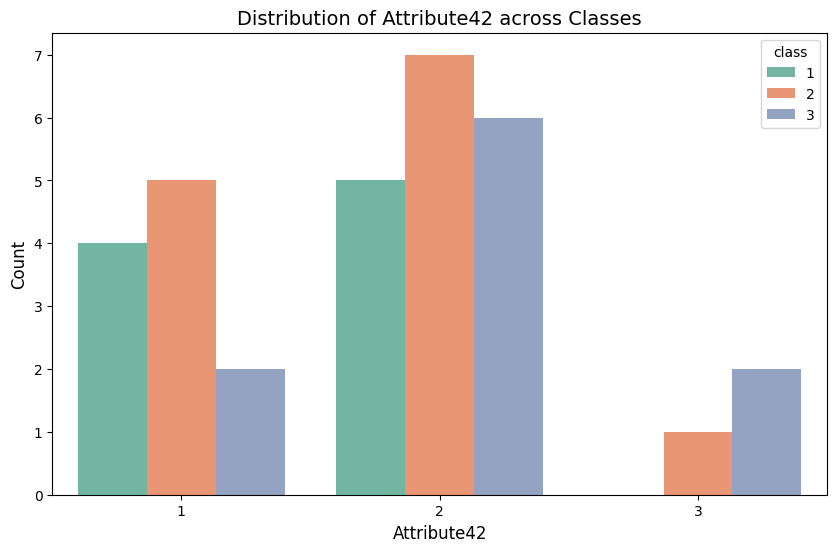

In [184]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute42' grouped by 'class'
sns.countplot(data=df, x='Attribute42', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute42 across Classes', fontsize=14)
plt.xlabel('Attribute42', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute43

In [185]:
# Counting the occurrences of each value in the 'Attribute6' column
Attribute43_counts = df['Attribute6'].value_counts()
Attribute43_counts

Attribute6
2    14
3    12
1     6
Name: count, dtype: int64

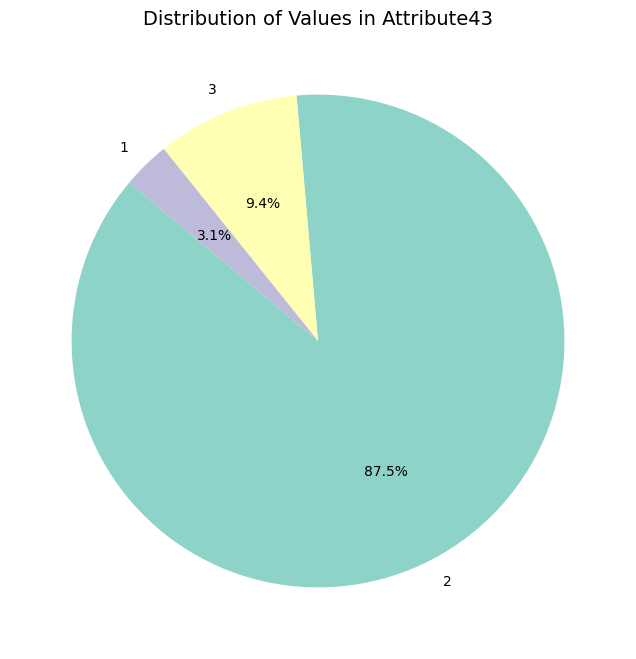

In [186]:
# Retrieve the value counts of 'Attribute43' from the dataframe
attribute43_counts = df['Attribute43'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute43_counts, labels=attribute43_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute43_counts)))

# Add a title
plt.title('Distribution of Values in Attribute43', fontsize=14)

# Display the chart
plt.show()

In [187]:
# Creating a cross-tabulation table of counts for Attribute43 against class
Attribute43_class_counts = pd.crosstab(df['Attribute43'], df['class'])
Attribute43_class_counts

class        1   2  3
Attribute43          
1            0   0  1
2            9  13  6
3            0   0  3

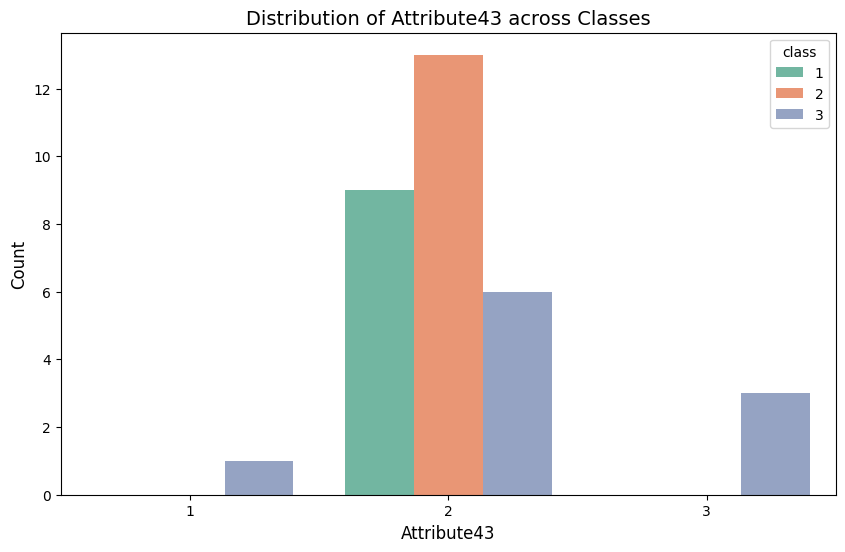

In [188]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute43' grouped by 'class'
sns.countplot(data=df, x='Attribute43', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute43 across Classes', fontsize=14)
plt.xlabel('Attribute43', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute44

In [189]:
# Counting the occurrences of each value in the 'Attribute44' column
Attribute44_counts = df['Attribute44'].value_counts()
Attribute44_counts

Attribute44
2    24
1     6
3     2
Name: count, dtype: int64

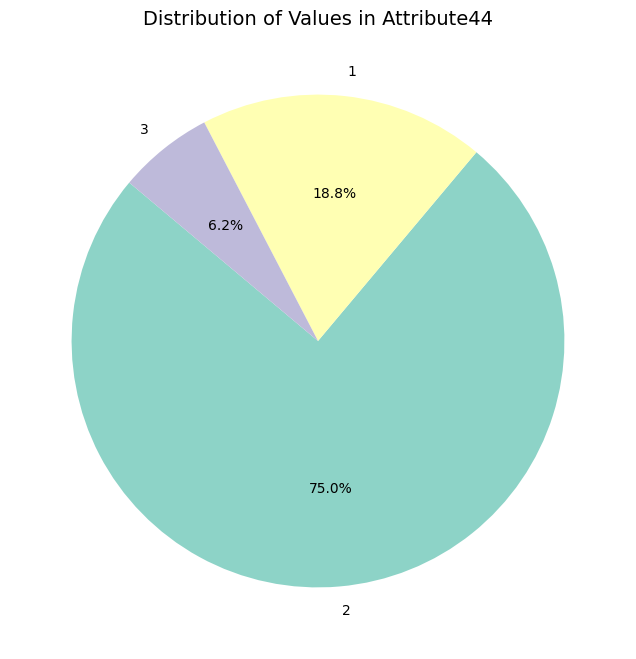

In [190]:
# Retrieve the value counts of 'Attribute44' from the dataframe
attribute44_counts = df['Attribute44'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute44_counts, labels=attribute44_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute44_counts)))

# Add a title
plt.title('Distribution of Values in Attribute44', fontsize=14)

# Display the chart
plt.show()

In [191]:
# Creating a cross-tabulation table of counts for Attribute44 against class
Attribute44_class_counts = pd.crosstab(df['Attribute44'], df['class'])
Attribute44_class_counts

class        1   2  3
Attribute44          
1            2   3  1
2            7  10  7
3            0   0  2

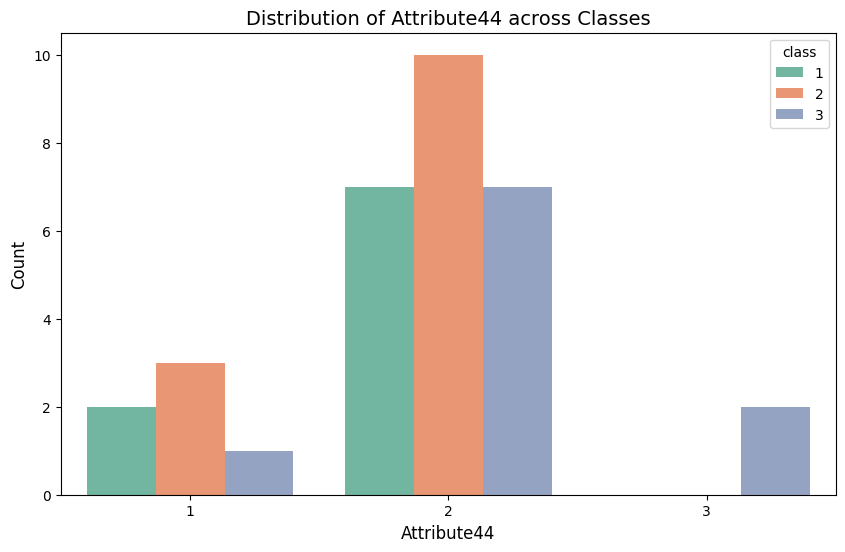

In [192]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute44' grouped by 'class'
sns.countplot(data=df, x='Attribute44', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute44 across Classes', fontsize=14)
plt.xlabel('Attribute44', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute45

In [193]:
# Counting the occurrences of each value in the 'Attribute6' column
Attribute45_counts = df['Attribute45'].value_counts()
Attribute45_counts

Attribute45
2    27
1     3
3     2
Name: count, dtype: int64

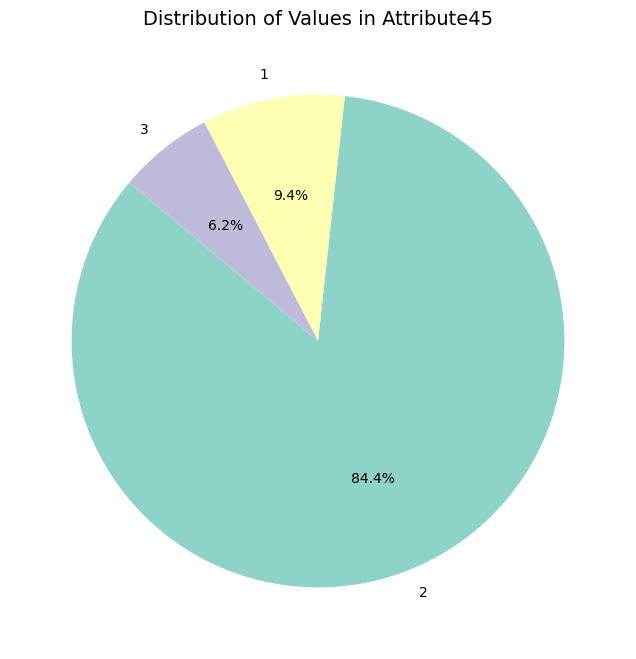

In [194]:
# Retrieve the value counts of 'Attribute6' from the dataframe
attribute45_counts = df['Attribute45'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute45_counts, labels=attribute45_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute45_counts)))

# Add a title
plt.title('Distribution of Values in Attribute45', fontsize=14)

# Display the chart
plt.show()

In [195]:
# Creating a cross-tabulation table of counts for Attribute45 against class
Attribute45_class_counts = pd.crosstab(df['Attribute45'], df['class'])
Attribute45_class_counts

class        1   2  3
Attribute45          
1            2   1  0
2            7  12  8
3            0   0  2

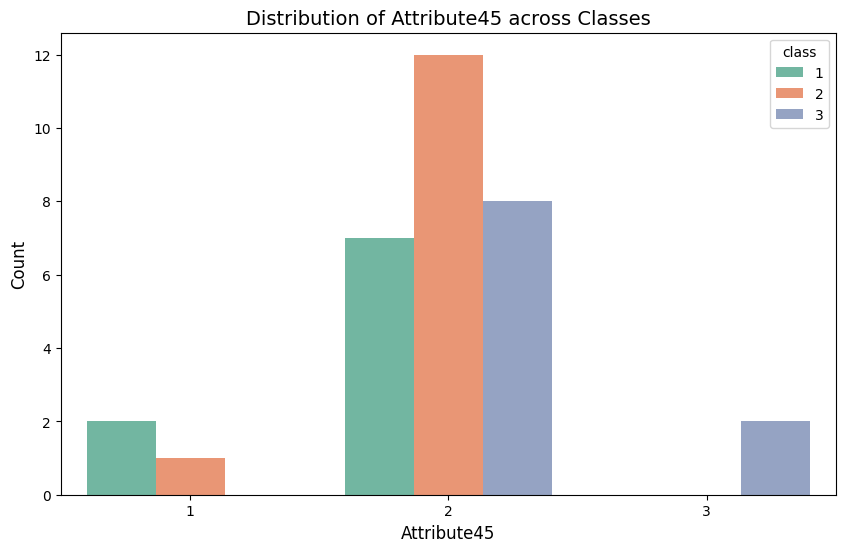

In [196]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute45' grouped by 'class'
sns.countplot(data=df, x='Attribute45', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute45 across Classes', fontsize=14)
plt.xlabel('Attribute45', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute46

In [197]:
# Counting the occurrences of each value in the 'Attribute46' column
Attribute46_counts = df['Attribute46'].value_counts()
Attribute46_counts

Attribute46
2    26
1     4
3     2
Name: count, dtype: int64

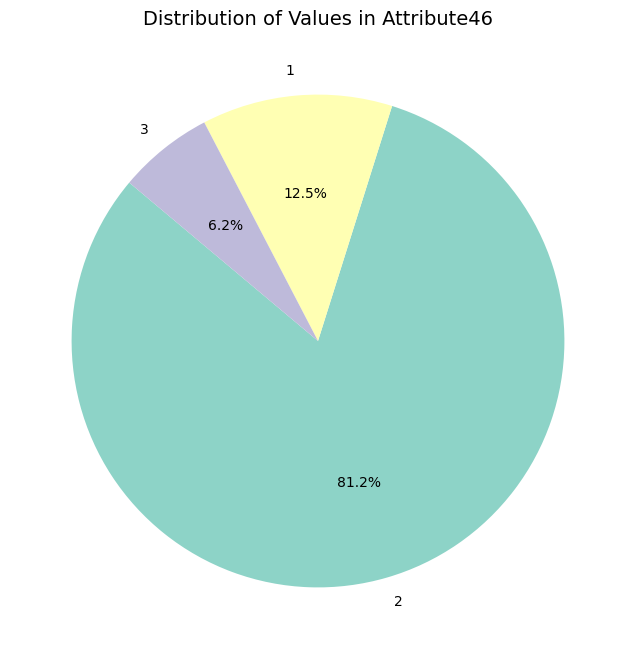

In [198]:
# Retrieve the value counts of 'Attribute46' from the dataframe
attribute46_counts = df['Attribute46'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute46_counts, labels=attribute46_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute46_counts)))

# Add a title
plt.title('Distribution of Values in Attribute46', fontsize=14)

# Display the chart
plt.show()

In [199]:
# Creating a cross-tabulation table of counts for Attribute6 against class
Attribute46_class_counts = pd.crosstab(df['Attribute46'], df['class'])
Attribute46_class_counts

class        1   2  3
Attribute46          
1            2   0  2
2            7  13  6
3            0   0  2

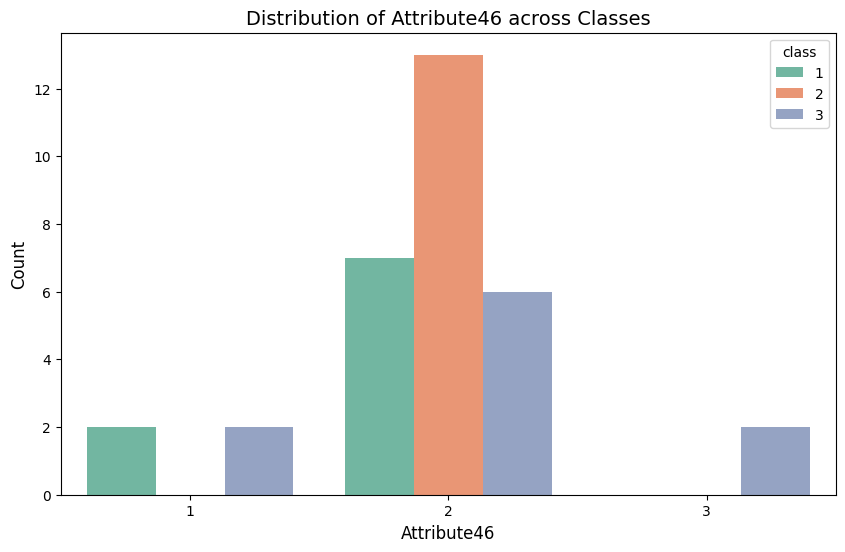

In [200]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute46' grouped by 'class'
sns.countplot(data=df, x='Attribute46', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute46 across Classes', fontsize=14)
plt.xlabel('Attribute46', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute47

In [201]:
# Counting the occurrences of each value in the 'Attribute47' column
Attribute47_counts = df['Attribute47'].value_counts()
Attribute47_counts

Attribute47
2    30
3     2
Name: count, dtype: int64

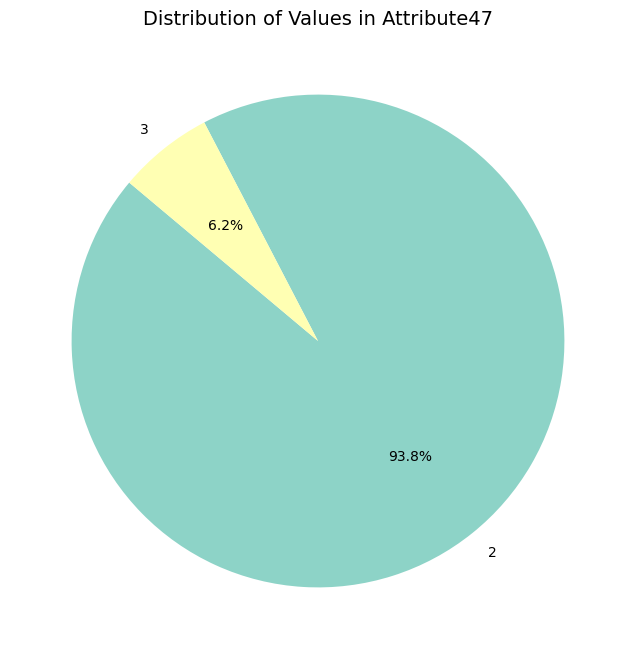

In [202]:
# Retrieve the value counts of 'Attribute47' from the dataframe
attribute47_counts = df['Attribute47'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute47_counts, labels=attribute47_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute47_counts)))

# Add a title
plt.title('Distribution of Values in Attribute47', fontsize=14)

# Display the chart
plt.show()

In [203]:
# Creating a cross-tabulation table of counts for Attribute47 against class
Attribute47_class_counts = pd.crosstab(df['Attribute47'], df['class'])
Attribute47_class_counts

class        1   2  3
Attribute47          
2            9  13  8
3            0   0  2

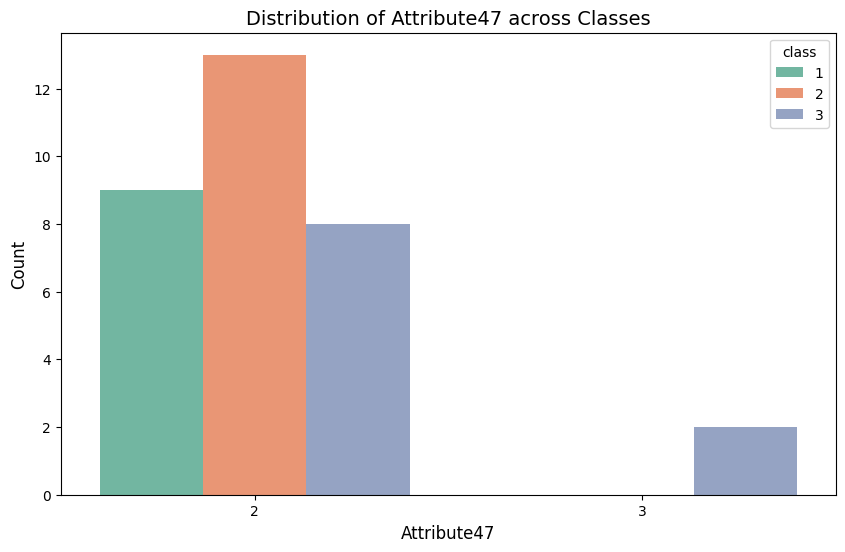

In [204]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute47' grouped by 'class'
sns.countplot(data=df, x='Attribute47', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute47 across Classes', fontsize=14)
plt.xlabel('Attribute47', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute48

In [205]:
# Counting the occurrences of each value in the 'Attribute48' column
Attribute48_counts = df['Attribute48'].value_counts()
Attribute48_counts

Attribute48
2    30
3     2
Name: count, dtype: int64

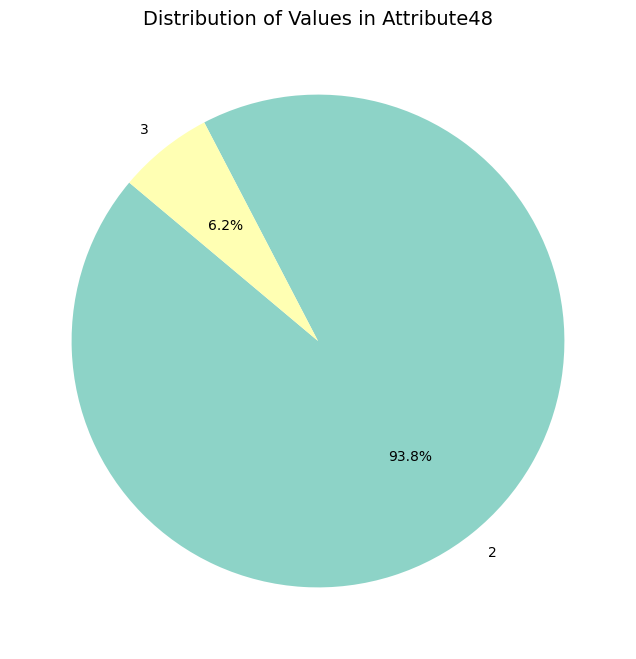

In [206]:
# Retrieve the value counts of 'Attribute48' from the dataframe
attribute48_counts = df['Attribute48'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute48_counts, labels=attribute48_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute48_counts)))

# Add a title
plt.title('Distribution of Values in Attribute48', fontsize=14)

# Display the chart
plt.show()

In [207]:
# Creating a cross-tabulation table of counts for Attribute48 against class
Attribute48_class_counts = pd.crosstab(df['Attribute48'], df['class'])
Attribute48_class_counts

class        1   2  3
Attribute48          
2            9  13  8
3            0   0  2

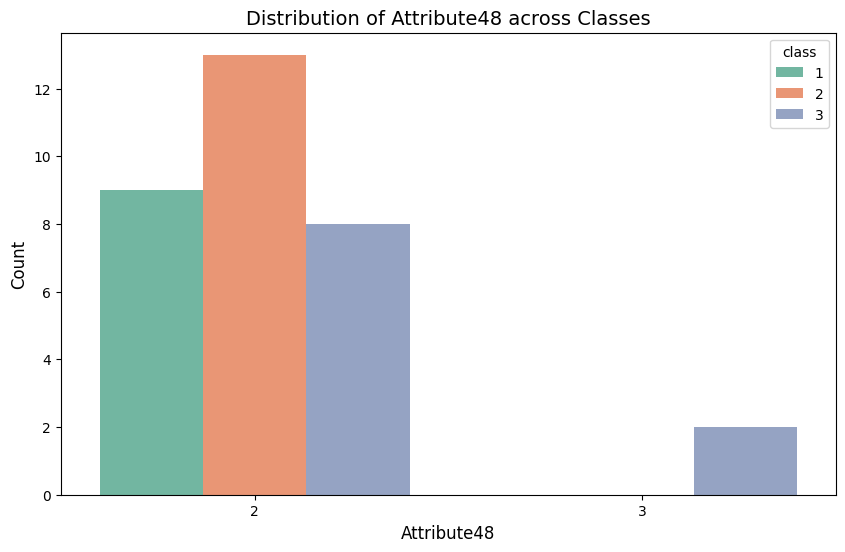

In [208]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute48' grouped by 'class'
sns.countplot(data=df, x='Attribute48', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute48 across Classes', fontsize=14)
plt.xlabel('Attribute48', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute49

In [209]:
# Counting the occurrences of each value in the 'Attribute49' column
Attribute49_counts = df['Attribute49'].value_counts()
Attribute49_counts

Attribute49
2    28
1     2
3     2
Name: count, dtype: int64

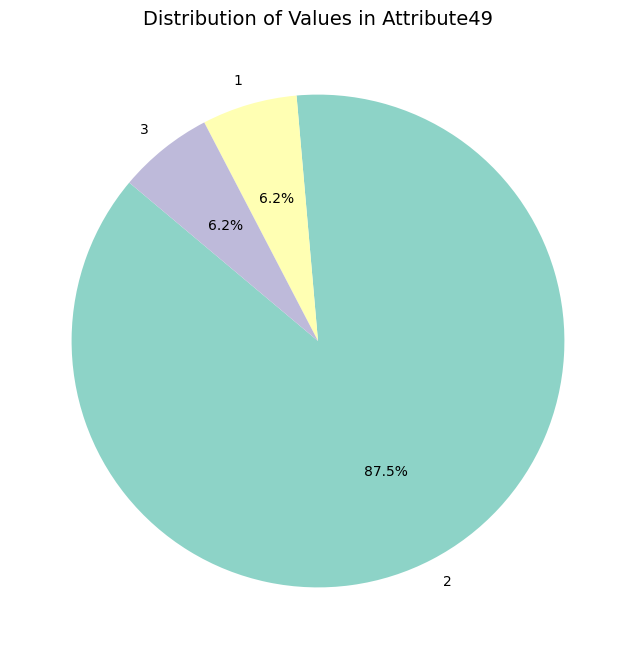

In [210]:
# Retrieve the value counts of 'Attribute6' from the dataframe
attribute49_counts = df['Attribute49'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute49_counts, labels=attribute49_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute49_counts)))

# Add a title
plt.title('Distribution of Values in Attribute49', fontsize=14)

# Display the chart
plt.show()

In [211]:
# Creating a cross-tabulation table of counts for Attribute49 against class
Attribute49_class_counts = pd.crosstab(df['Attribute49'], df['class'])
Attribute49_class_counts

class        1   2  3
Attribute49          
1            1   1  0
2            8  12  8
3            0   0  2

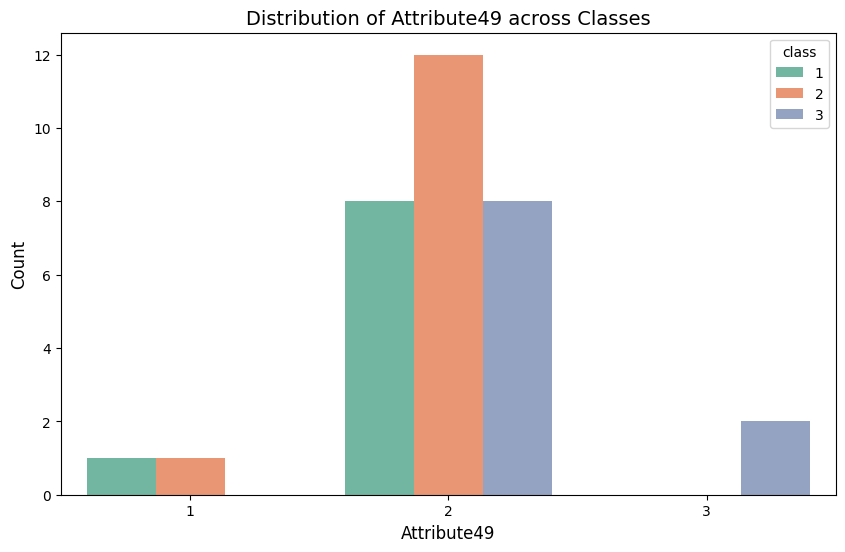

In [212]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute49' grouped by 'class'
sns.countplot(data=df, x='Attribute49', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute49 across Classes', fontsize=14)
plt.xlabel('Attribute49', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute50

In [213]:
# Counting the occurrences of each value in the 'Attribute50' column
Attribute50_counts = df['Attribute50'].value_counts()
Attribute50_counts

Attribute50
2    28
1     2
3     2
Name: count, dtype: int64

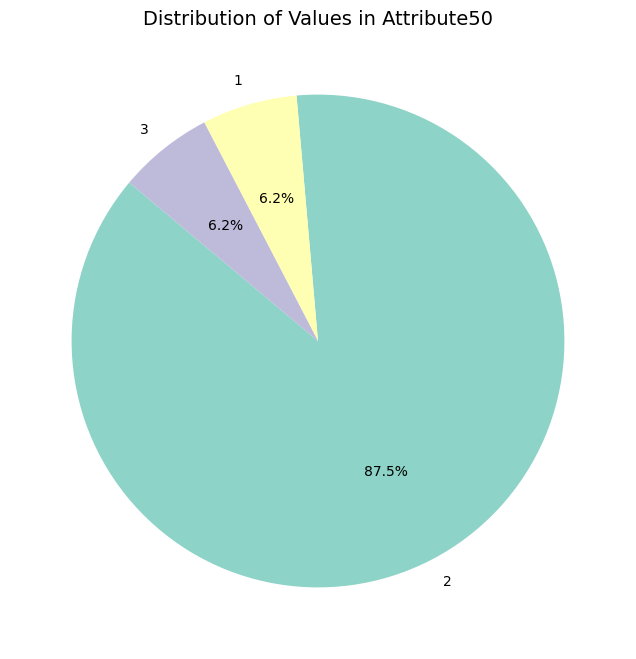

In [214]:
# Retrieve the value counts of 'Attribute50' from the dataframe
attribute50_counts = df['Attribute50'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute50_counts, labels=attribute50_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute50_counts)))

# Add a title
plt.title('Distribution of Values in Attribute50', fontsize=14)

# Display the chart
plt.show()

In [215]:
# Creating a cross-tabulation table of counts for Attribute50 against class
Attribute50_class_counts = pd.crosstab(df['Attribute50'], df['class'])
Attribute50_class_counts

class        1   2  3
Attribute50          
1            0   1  1
2            9  12  7
3            0   0  2

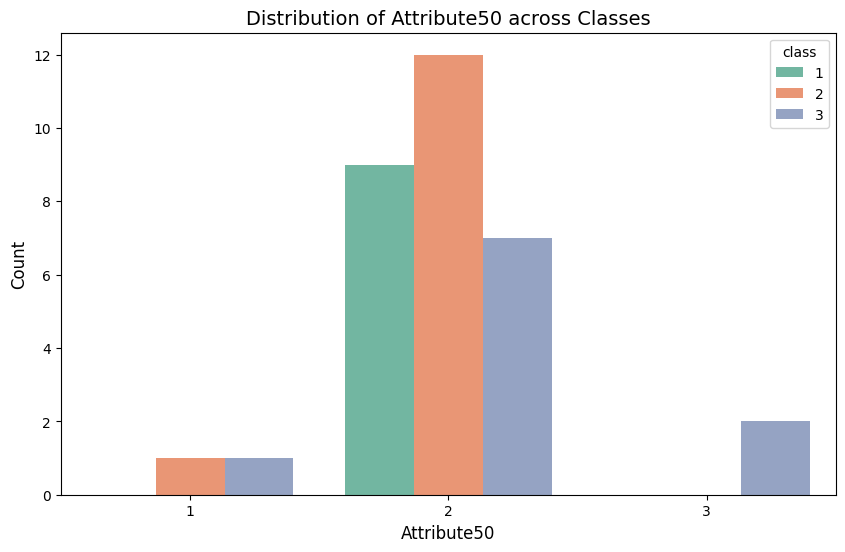

In [216]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute50' grouped by 'class'
sns.countplot(data=df, x='Attribute50', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute50 across Classes', fontsize=14)
plt.xlabel('Attribute50', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute51

In [217]:
# Counting the occurrences of each value in the 'Attribute51' column
Attribute51_counts = df['Attribute51'].value_counts()
Attribute51_counts

Attribute51
2    24
1     4
3     4
Name: count, dtype: int64

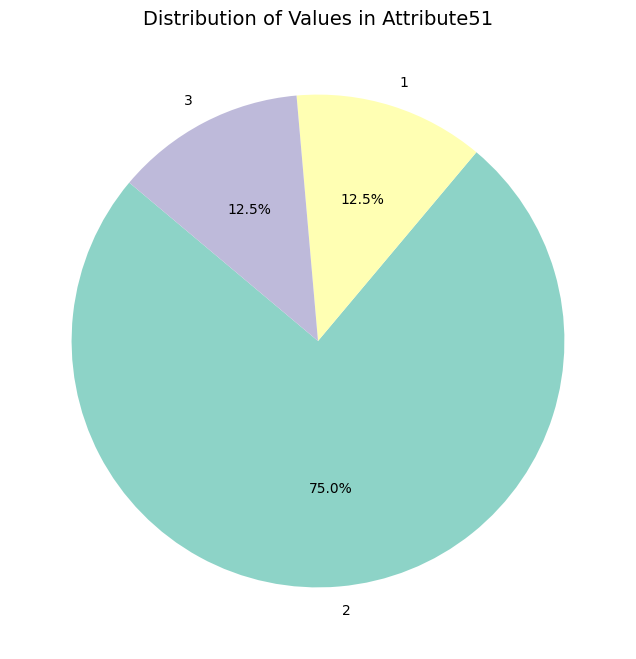

In [218]:
# Retrieve the value counts of 'Attribute51' from the dataframe
attribute51_counts = df['Attribute51'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute51_counts, labels=attribute51_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute51_counts)))

# Add a title
plt.title('Distribution of Values in Attribute51', fontsize=14)

# Display the chart
plt.show()

In [219]:
# Creating a cross-tabulation table of counts for Attribute51 against class
Attribute51_class_counts = pd.crosstab(df['Attribute51'], df['class'])
Attribute51_class_counts

class        1   2  3
Attribute51          
1            1   1  2
2            8  11  5
3            0   1  3

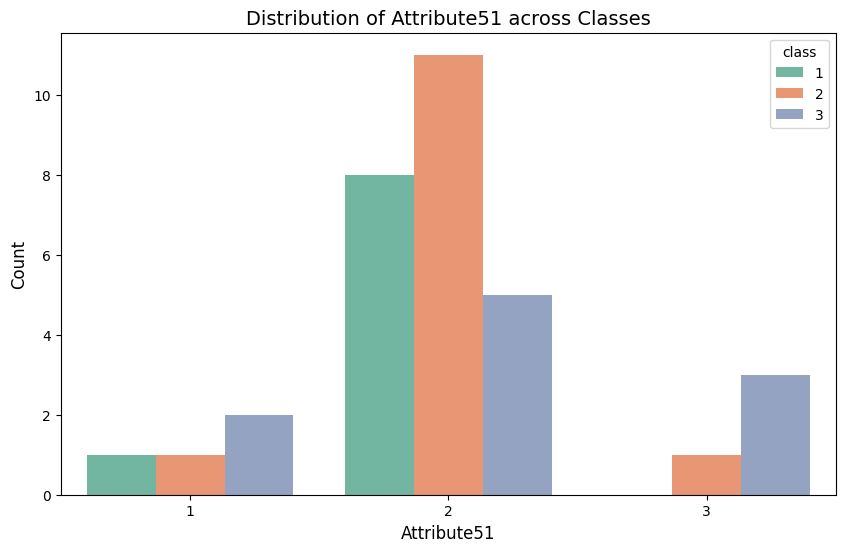

In [220]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute51' grouped by 'class'
sns.countplot(data=df, x='Attribute51', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute51 across Classes', fontsize=14)
plt.xlabel('Attribute51', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute52

In [221]:
# Counting the occurrences of each value in the 'Attribute52' column
Attribute52_counts = df['Attribute52'].value_counts()
Attribute52_counts

Attribute52
2    25
1     6
3     1
Name: count, dtype: int64

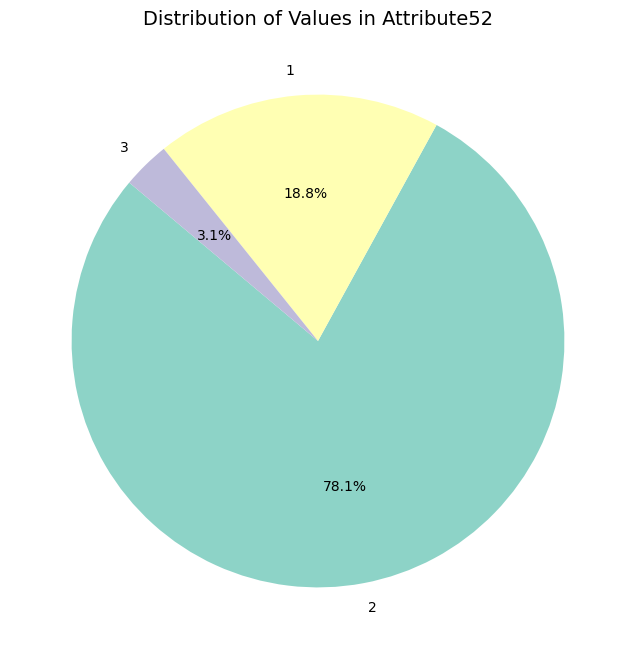

In [222]:
# Retrieve the value counts of 'Attribute52' from the dataframe
attribute52_counts = df['Attribute52'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute52_counts, labels=attribute52_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute52_counts)))

# Add a title
plt.title('Distribution of Values in Attribute52', fontsize=14)

# Display the chart
plt.show()

In [223]:
# Creating a cross-tabulation table of counts for Attribute52 against class
Attribute52_class_counts = pd.crosstab(df['Attribute52'], df['class'])
Attribute52_class_counts

class        1  2  3
Attribute52         
1            1  4  1
2            8  9  8
3            0  0  1

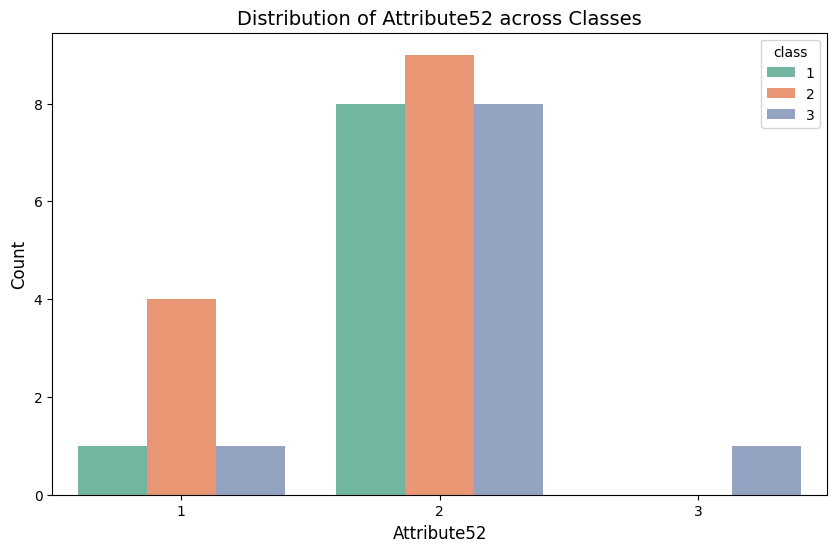

In [224]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute52' grouped by 'class'
sns.countplot(data=df, x='Attribute52', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute52 across Classes', fontsize=14)
plt.xlabel('Attribute52', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute53

In [225]:
# Counting the occurrences of each value in the 'Attribute53' column
Attribute53_counts = df['Attribute53'].value_counts()
Attribute53_counts

Attribute53
2    25
1     6
3     1
Name: count, dtype: int64

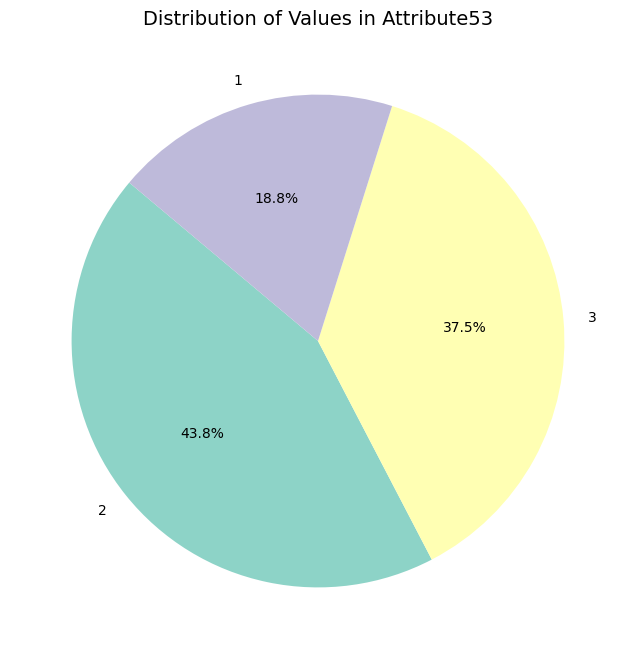

In [226]:
# Retrieve the value counts of 'Attribute53' from the dataframe
attribute53_counts = df['Attribute6'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute53_counts, labels=attribute53_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute53_counts)))

# Add a title
plt.title('Distribution of Values in Attribute53', fontsize=14)

# Display the chart
plt.show()

In [227]:
# Creating a cross-tabulation table of counts for Attribute53 against class
Attribute53_class_counts = pd.crosstab(df['Attribute53'], df['class'])
Attribute53_class_counts

class        1  2  3
Attribute53         
1            1  5  0
2            8  8  9
3            0  0  1

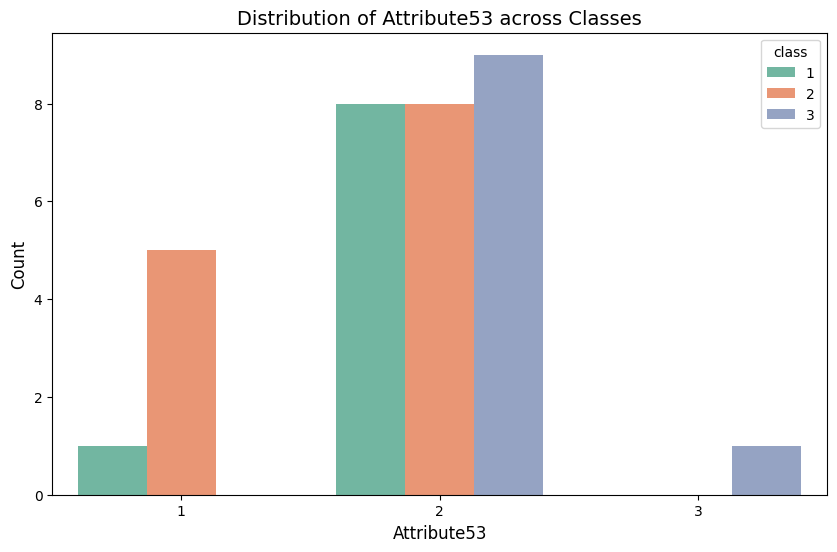

In [228]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute53' grouped by 'class'
sns.countplot(data=df, x='Attribute53', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute53 across Classes', fontsize=14)
plt.xlabel('Attribute53', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute54

In [231]:
# Counting the occurrences of each value in the 'Attribute54' column
Attribute54_counts = df['Attribute54'].value_counts()
Attribute54_counts

Attribute54
2    18
1    14
Name: count, dtype: int64

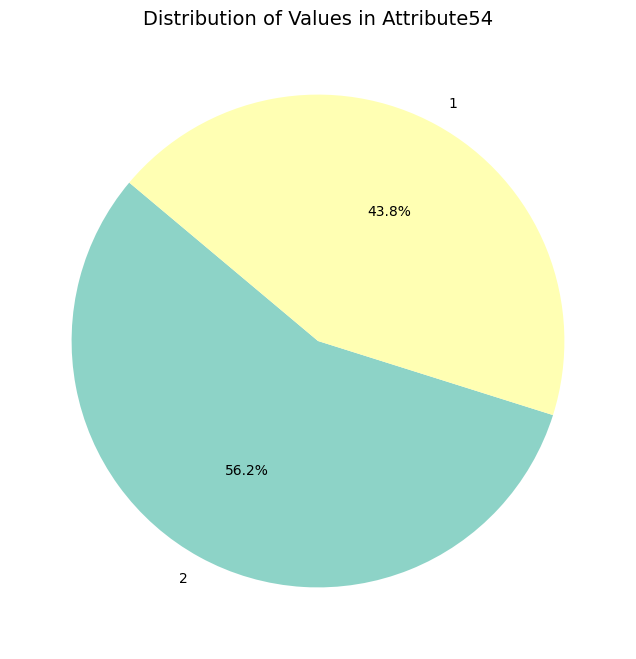

In [232]:
# Retrieve the value counts of 'Attribute54' from the dataframe
attribute54_counts = df['Attribute54'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute54_counts, labels=attribute54_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute54_counts)))

# Add a title
plt.title('Distribution of Values in Attribute54', fontsize=14)

# Display the chart
plt.show()

In [233]:
# Creating a cross-tabulation table of counts for Attribute54 against class
Attribute54_class_counts = pd.crosstab(df['Attribute54'], df['class'])
Attribute54_class_counts

class        1  2  3
Attribute54         
1            5  7  2
2            4  6  8

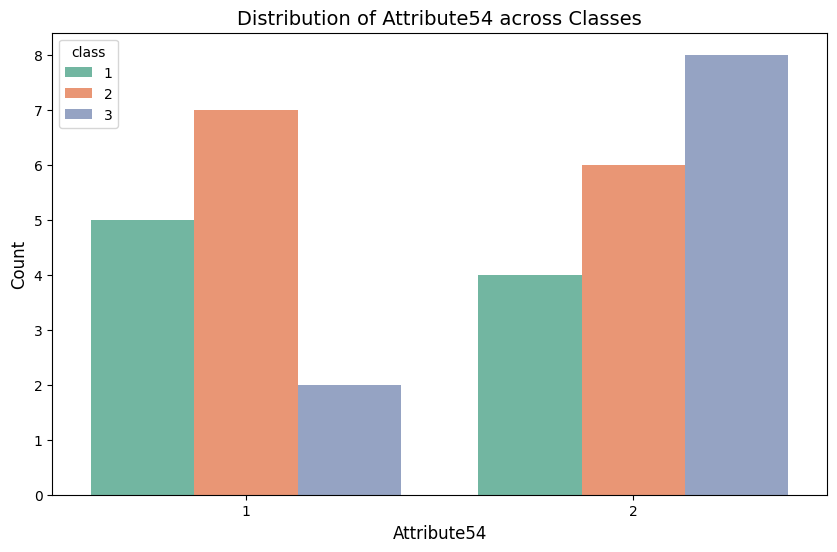

In [234]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute54' grouped by 'class'
sns.countplot(data=df, x='Attribute54', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute54 across Classes', fontsize=14)
plt.xlabel('Attribute54', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Attribute55

In [235]:
# Counting the occurrences of each value in the 'Attribute55' column
Attribute55_counts = df['Attribute55'].value_counts()
Attribute55_counts

Attribute55
2    26
1     6
Name: count, dtype: int64

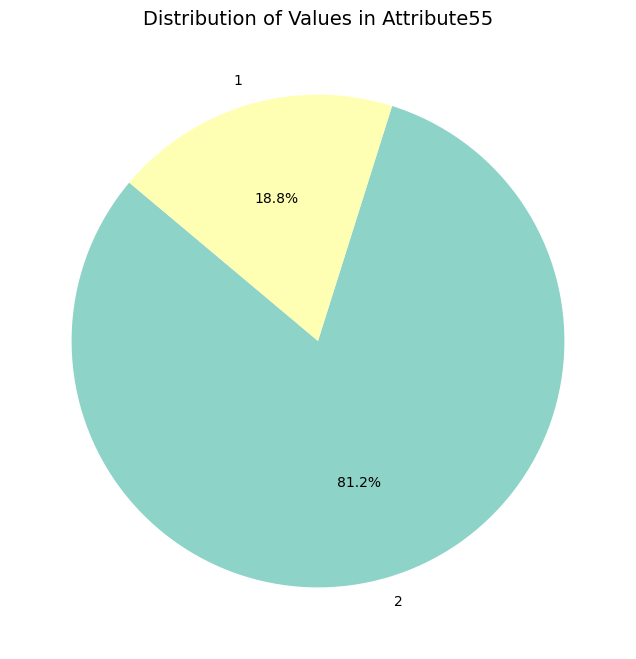

In [236]:
# Retrieve the value counts of 'Attribute55' from the dataframe
attribute55_counts = df['Attribute55'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(attribute55_counts, labels=attribute55_counts.index, autopct='%1.1f%%',
        startangle=140,colors=sns.color_palette('Set3', len(attribute55_counts)))

# Add a title
plt.title('Distribution of Values in Attribute55', fontsize=14)

# Display the chart
plt.show()

In [237]:
# Creating a cross-tabulation table of counts for Attribute55 against class
Attribute55_class_counts = pd.crosstab(df['Attribute55'], df['class'])
Attribute55_class_counts

class        1   2  3
Attribute55          
1            3   2  1
2            6  11  9

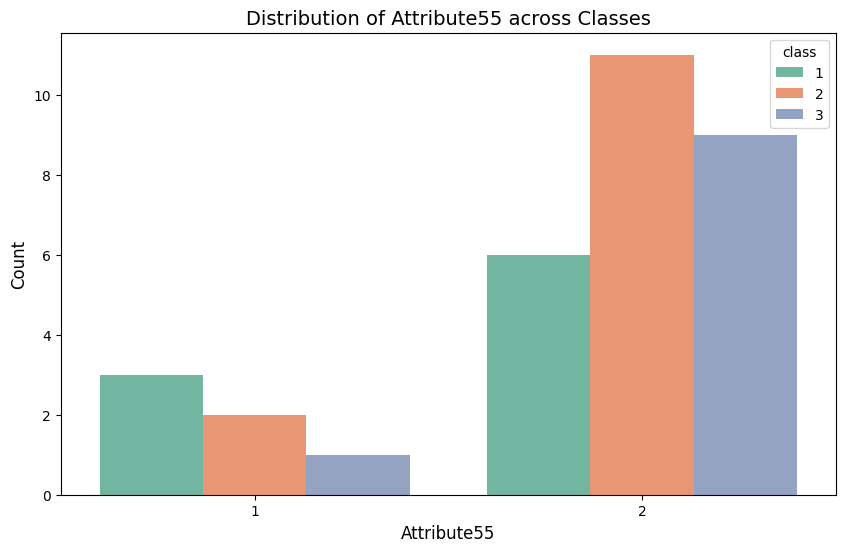

In [238]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot the count plot of 'Attribute55' grouped by 'class'
sns.countplot(data=df, x='Attribute55', hue='class', palette='Set2')

# Add title and labels
plt.title('Distribution of Attribute55 across Classes', fontsize=14)
plt.xlabel('Attribute55', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

###Correlation Heatmap

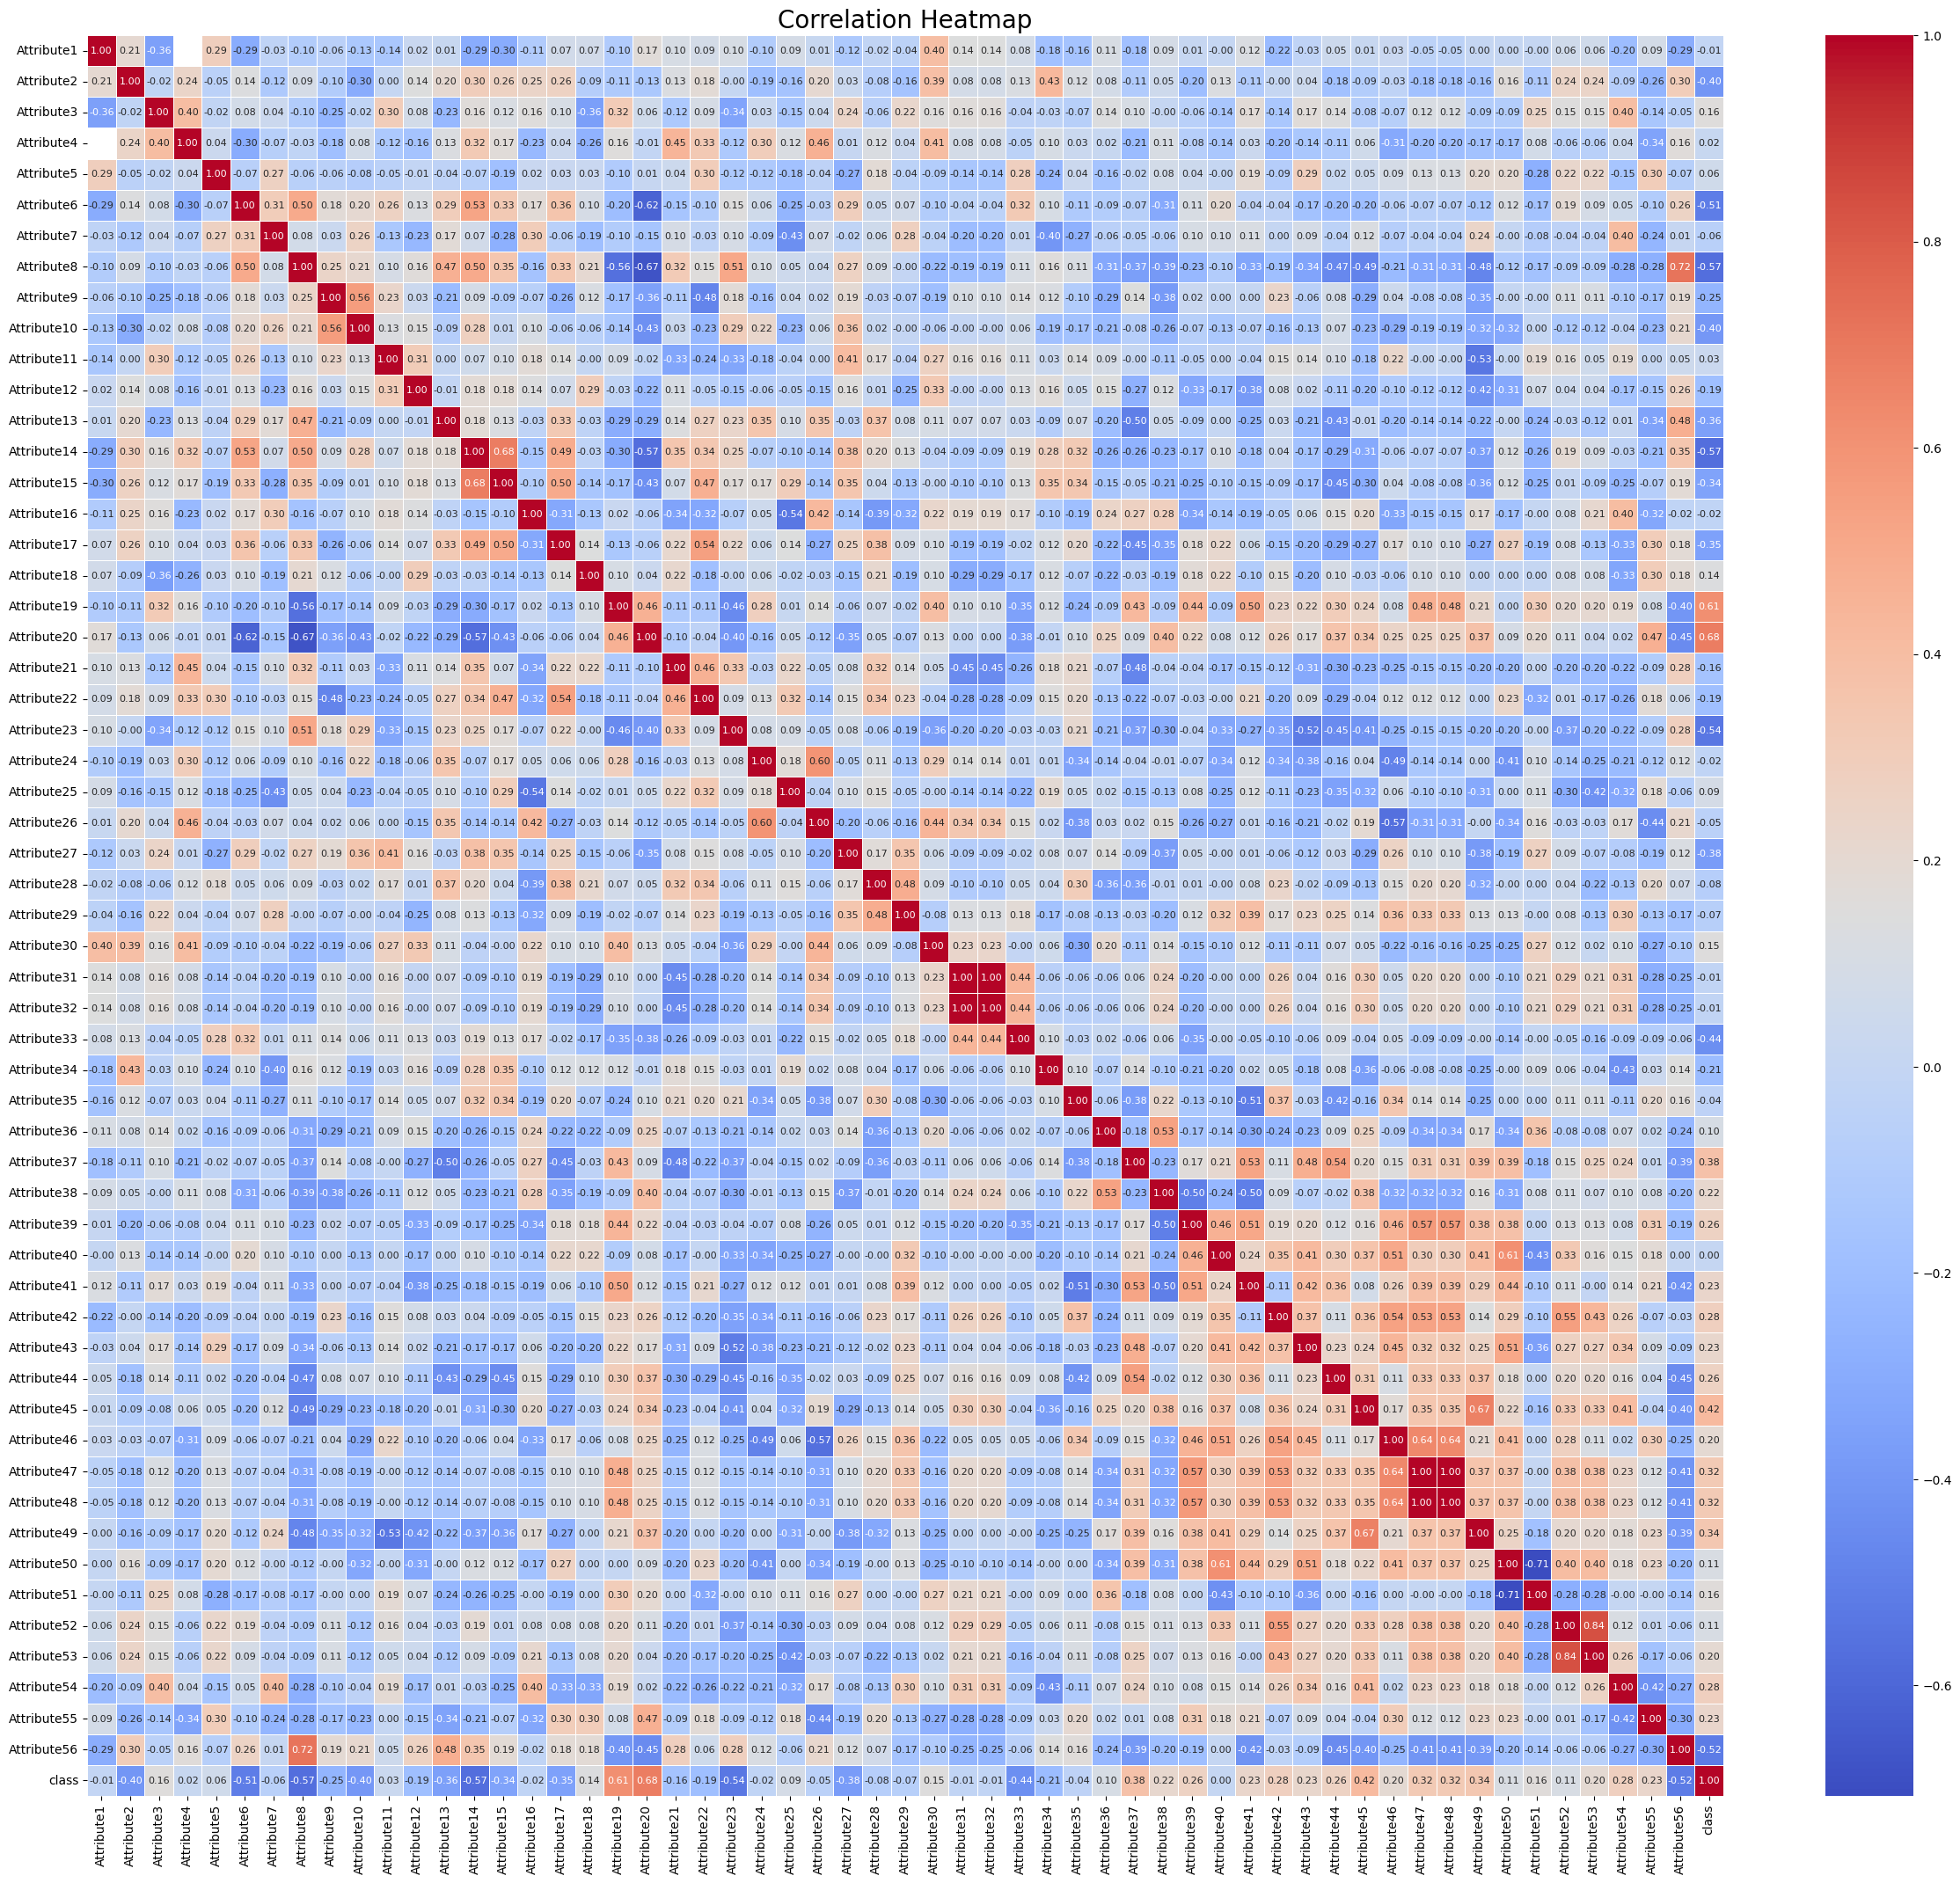

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix on the DataFrame
corr_matrix = df.corr()

# Set up the matplotlib figure with a larger size to accommodate 57 columns
plt.figure(figsize=(30, 26))  # Increased the figure size to improve readability

# Draw the heatmap with a more suitable fontsize for annotations
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

# Title for the heatmap
plt.title('Correlation Heatmap', fontsize=20)

# Show the plot
plt.show()


###Correlation All Features Vs. class

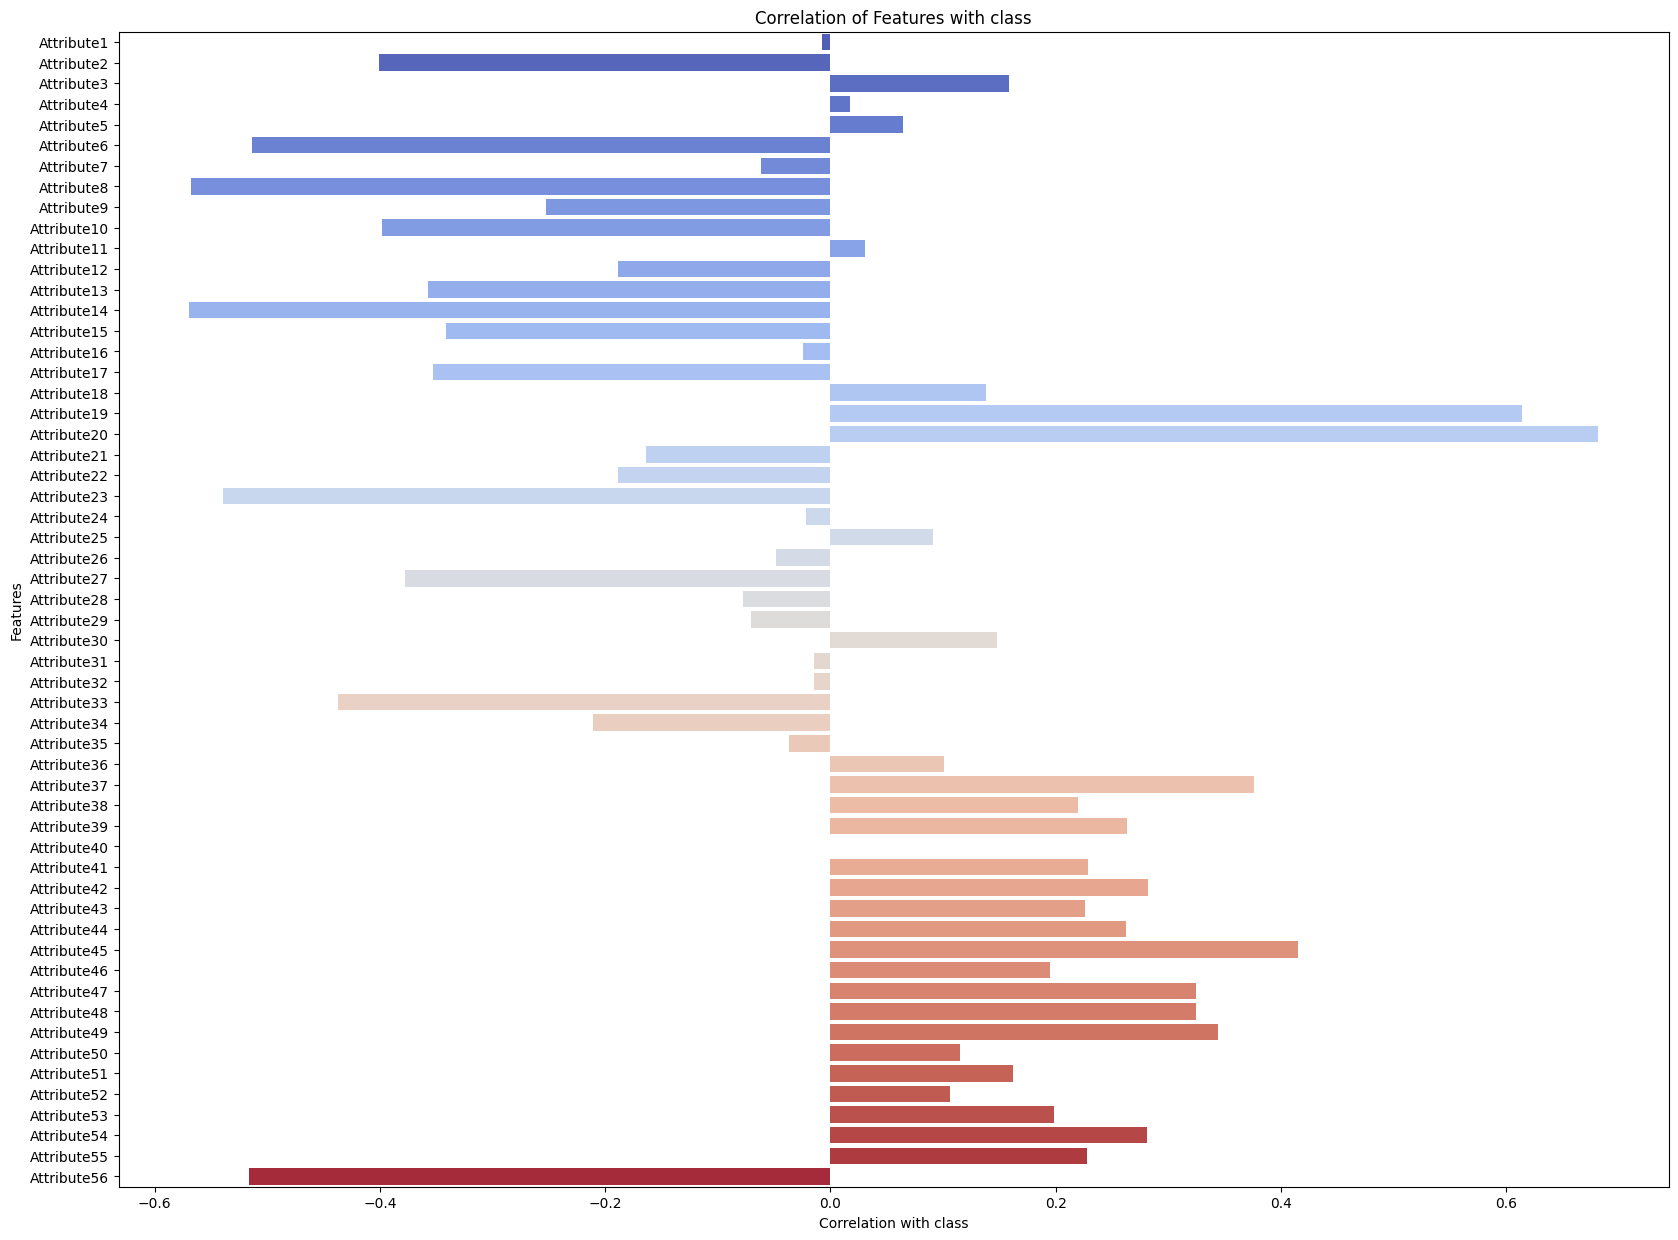

In [240]:
# Calculate the correlation between all features and the class
corr_with_class = df.corr()['class'].drop('class')  # Exclude self-correlation

# Plotting the correlations
plt.figure(figsize=(20, 15))
sns.barplot(x=corr_with_class.values, y=corr_with_class.index, palette='coolwarm')

# Add labels and title
plt.xlabel('Correlation with class')
plt.ylabel('Features')
plt.title('Correlation of Features with class')
plt.show()

###class(Target Variable)

In [241]:
df['class'].value_counts()

class
2    13
3    10
1     9
Name: count, dtype: int64

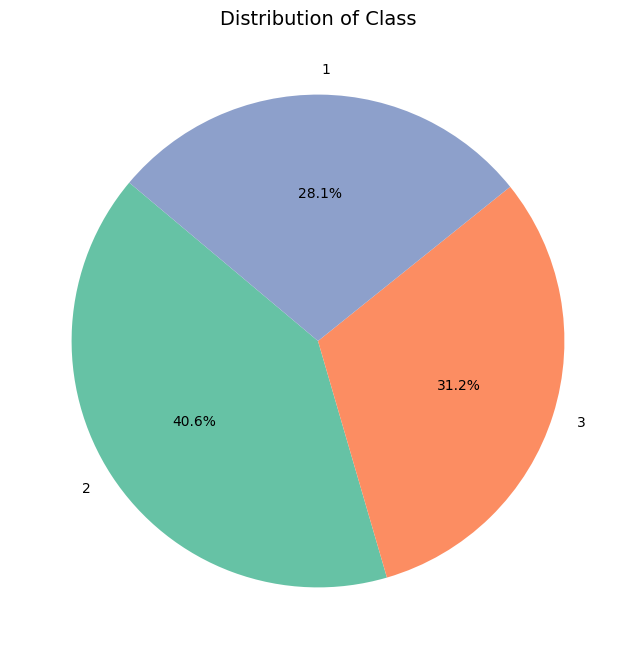

In [242]:
# Retrieve the value counts of the encoded 'NObeyesdad' from the dataframe
target_counts = df['class'].value_counts()
# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2', len(target_counts)))

# Add a title
plt.title('Distribution of Class', fontsize=14)

# Display the chart
plt.show()

##5.Predictive Modeling

###Model Training

####Data Preparating

In [243]:
df.dtypes

Attribute1       int64
Attribute2       int64
Attribute3       int64
Attribute4     float64
Attribute5       int64
Attribute6       int64
Attribute7       int64
Attribute8       int64
Attribute9       int64
Attribute10      int64
Attribute11      int64
Attribute12      int64
Attribute13      int64
Attribute14      int64
Attribute15      int64
Attribute16      int64
Attribute17      int64
Attribute18      int64
Attribute19      int64
Attribute20      int64
Attribute21      int64
Attribute22      int64
Attribute23      int64
Attribute24      int64
Attribute25      int64
Attribute26      int64
Attribute27      int64
Attribute28      int64
Attribute29      int64
Attribute30      int64
Attribute31      int64
Attribute32      int64
Attribute33      int64
Attribute34      int64
Attribute35      int64
Attribute36      int64
Attribute37      int64
Attribute38    float64
Attribute39      int64
Attribute40      int64
Attribute41      int64
Attribute42      int64
Attribute43      int64
Attribute44      int64
Attribute45      int64
Attribute46      int64
Attribute47      int64
Attribute48      int64
Attribute49      int64
Attribute50      int64
Attribute51      int64
Attribute52      int64
Attribute53      int64
Attribute54      int64
Attribute55      int64
Attribute56      int64
class            int64
dtype: object

In [244]:
df.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0           0           3           0         NaN           0           2   
1           0           3           3         1.0           0           3   
2           0           3           3         2.0           0           3   
3           0           2           3         2.0           1           3   
4           0           3           2         1.0           1           3   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute48  \
0           2           2           1            1  ...            2   
1           1           3           1            1  ...            2   
2           3           3           1            1  ...            2   
3           3           3           1            2  ...            2   
4           3           3           2            2  ...            2   

   Attribute49  Attribute50  Attribute51  Attribute52  Attribute53  \
0            2            2            2            1            1   
1            2            2            2            2            2   
2            2            2            2            2            2   
3            2            2            2            2            2   
4            2            2            2            2            2   

   Attribute54  Attribute55  Attribute56  class  
0            1            2            2      1  
1            1            2            2      1  
2            2            1            2      1  
3            2            2            2      1  
4            1            2            2      1  

[5 rows x 57 columns]

In [245]:
missing_values = df.isnull().sum()  # Calculate the number of missing values in each column
missing_columns = missing_values[missing_values > 0]  # Filter only columns with missing values
missing_columns

Attribute4     4
Attribute38    1
dtype: int64

In [246]:
df[['Attribute4', 'Attribute38']].dtypes

Attribute4     float64
Attribute38    float64
dtype: object

In [247]:
df['Attribute4'].unique()

array([nan,  1.,  2.,  0.])

In [248]:
df['Attribute38'].unique()

array([ 2.,  1.,  3., nan])

In [249]:
# Fill missing values in Attribute4 and Attribute38 with their respective median
df[['Attribute4', 'Attribute38']] = df[['Attribute4', 'Attribute38']].fillna(df[['Attribute4', 'Attribute38']].median())

In [250]:
# Define features and target
X = df.drop('class', axis=1)
y = df['class']

In [251]:
y.value_counts()

class
2    13
3    10
1     9
Name: count, dtype: int64

In [252]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [253]:
# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

####Model Selection and Training

In [254]:
# List of models to train, including SVC
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42),
    "LogitBoost": LogitBoost(),
    "SVC": SVC(probability=True, random_state=42)  # SVC added to the model list
}

In [255]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        predictions[name] = y_pred

        print(f"{name} results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}\n")

         # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results, predictions

###Model Evaluation

In [256]:
# Adjust the class labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

Logistic Regression results:
Accuracy: 0.4286
Precision: 0.5556
Recall: 0.5556
F1 Score: 0.5556



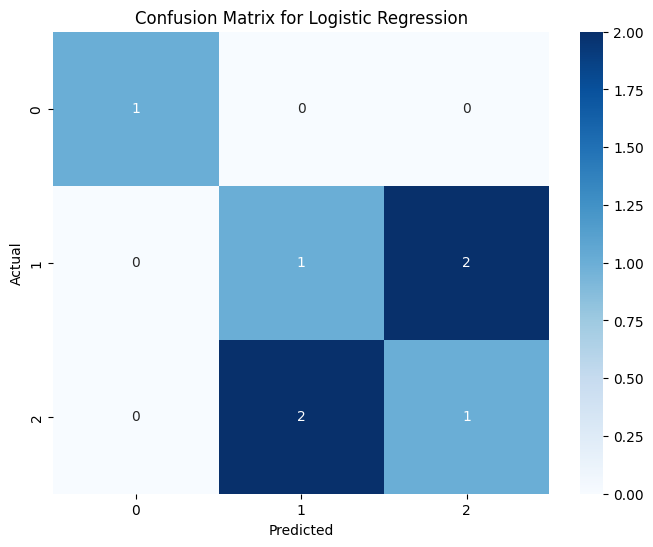

Decision Tree results:
Accuracy: 0.2857
Precision: 0.4167
Recall: 0.4444
F1 Score: 0.4286



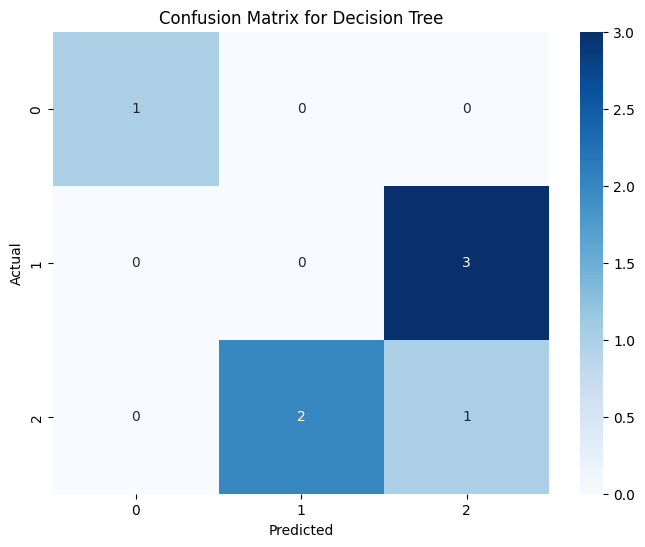

Random Forest results:
Accuracy: 0.5714
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6571



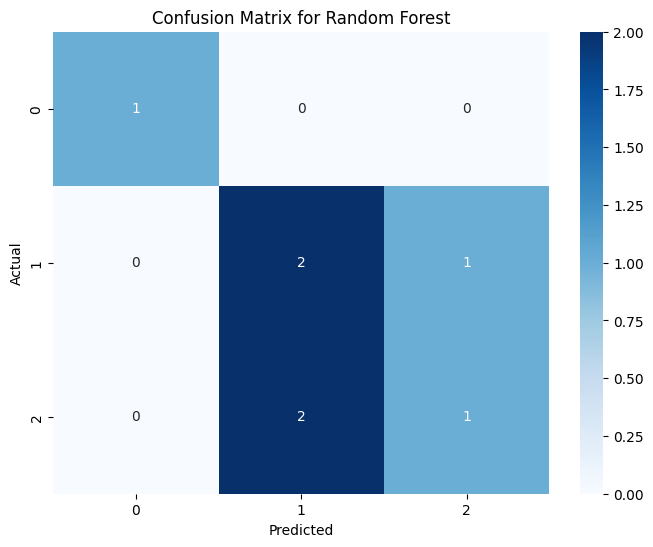

AdaBoost results:
Accuracy: 0.4286
Precision: 0.3000
Recall: 0.3333
F1 Score: 0.3000



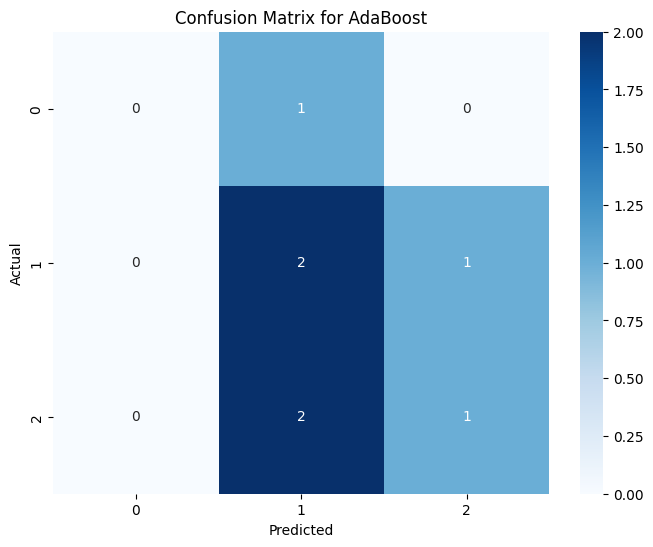

Gradient Boosting results:
Accuracy: 0.4286
Precision: 0.3333
Recall: 0.5556
F1 Score: 0.4127



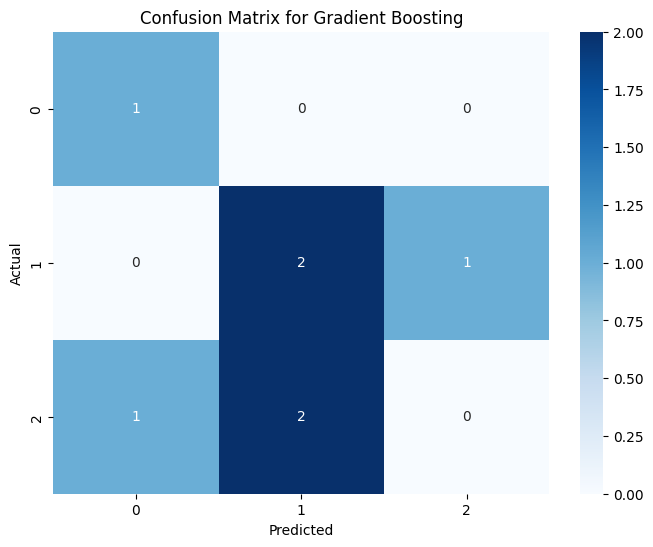

XGBoost results:
Accuracy: 0.4286
Precision: 0.3333
Recall: 0.5556
F1 Score: 0.4127



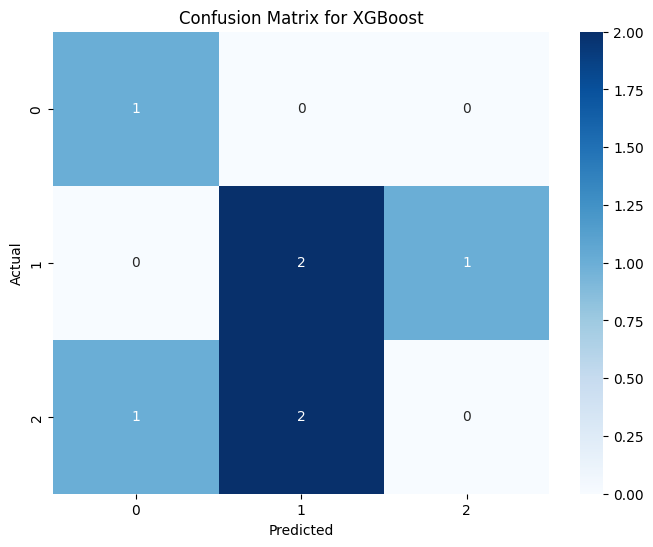

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score -1.139434
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Info] Start training from score -1.272966
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

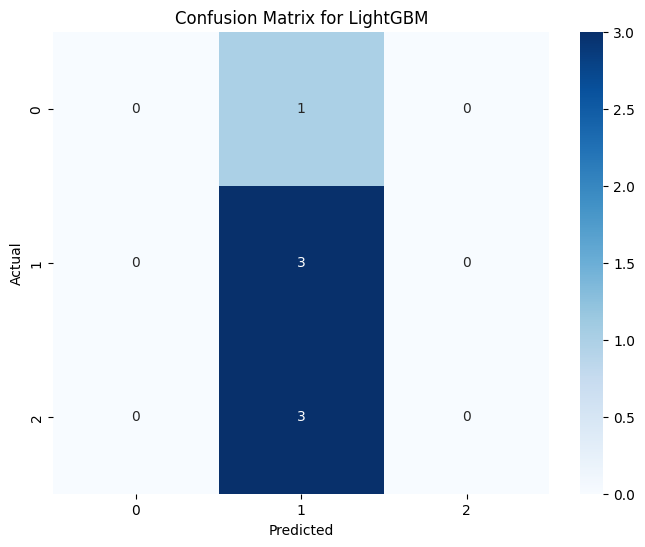

CatBoost results:
Accuracy: 0.5714
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6571



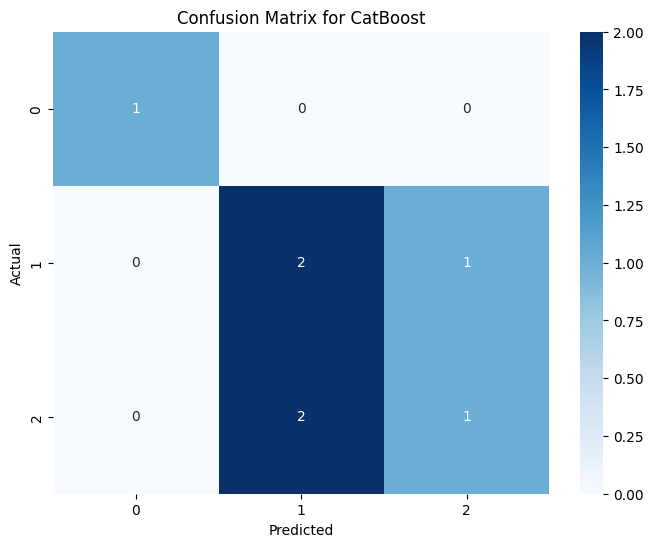

LogitBoost results:
Accuracy: 0.5714
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.5794



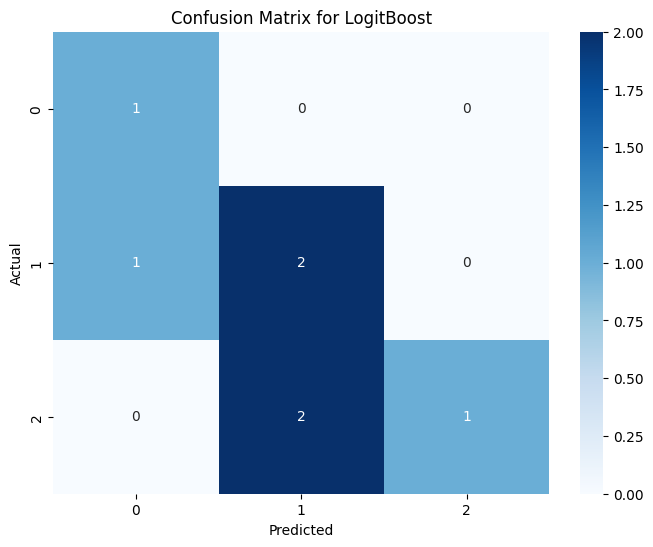

SVC results:
Accuracy: 0.4286
Precision: 0.1429
Recall: 0.3333
F1 Score: 0.2000



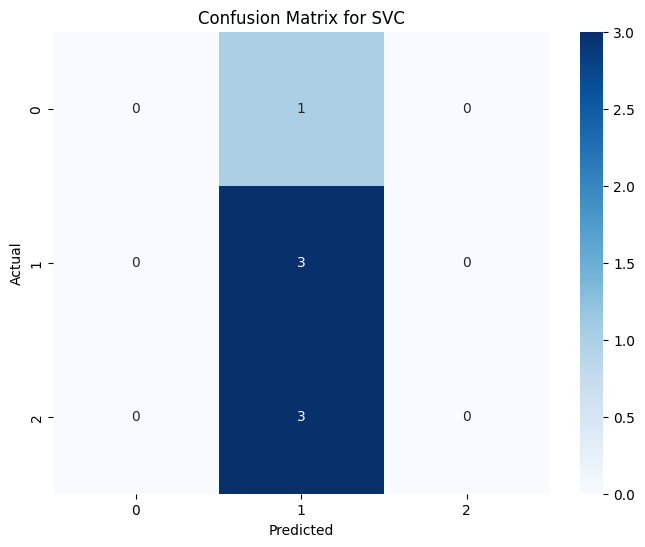

In [257]:
# Train and evaluate the models using the adjusted labels
results, predictions = train_and_evaluate(models, X_train, X_test, y_train_adjusted, y_test_adjusted)

In [258]:
# Display results in a table format
results_df = pd.DataFrame(results)
results_df

Logistic Regression  Decision Tree  Random Forest  AdaBoost  \
accuracy              0.428571       0.285714       0.571429  0.428571   
precision             0.555556       0.416667       0.666667  0.300000   
recall                0.555556       0.444444       0.666667  0.333333   
f1_score              0.555556       0.428571       0.657143  0.300000   

           Gradient Boosting   XGBoost  LightGBM  CatBoost  LogitBoost  \
accuracy            0.428571  0.428571  0.428571  0.571429    0.571429   
precision           0.333333  0.333333  0.142857  0.666667    0.666667   
recall              0.555556  0.555556  0.333333  0.666667    0.666667   
f1_score            0.412698  0.412698  0.200000  0.657143    0.579365   

                SVC  
accuracy   0.428571  
precision  0.142857  
recall     0.333333  
f1_score   0.200000

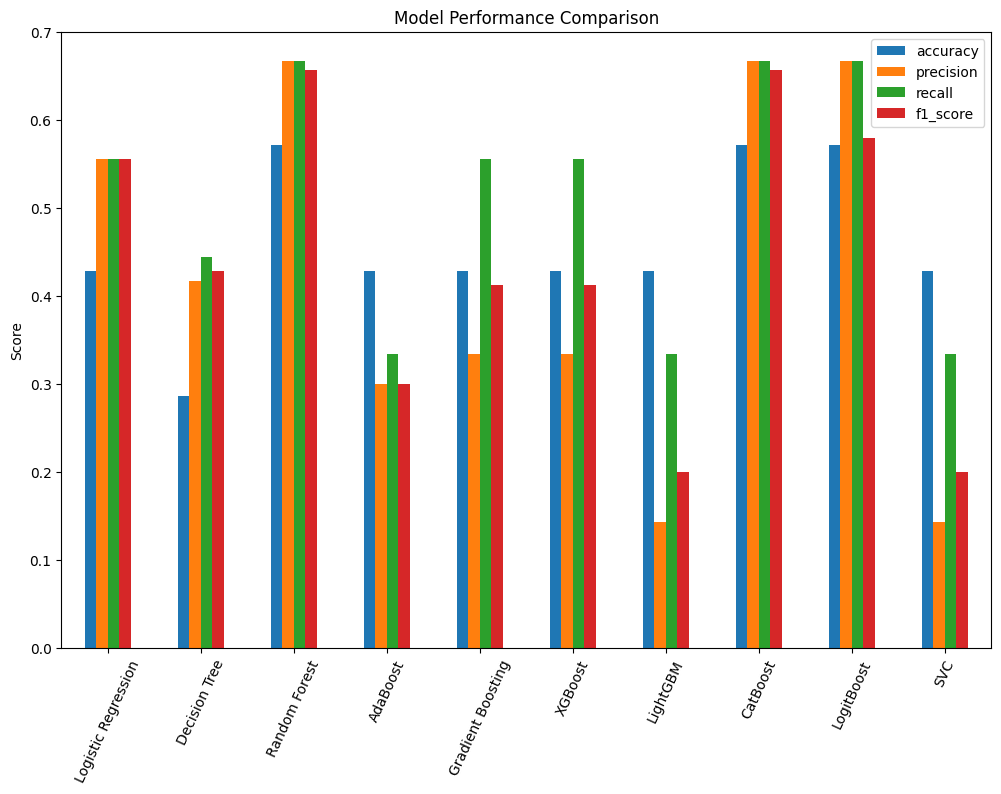

In [259]:
# Plotting the results
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=65)
plt.show()

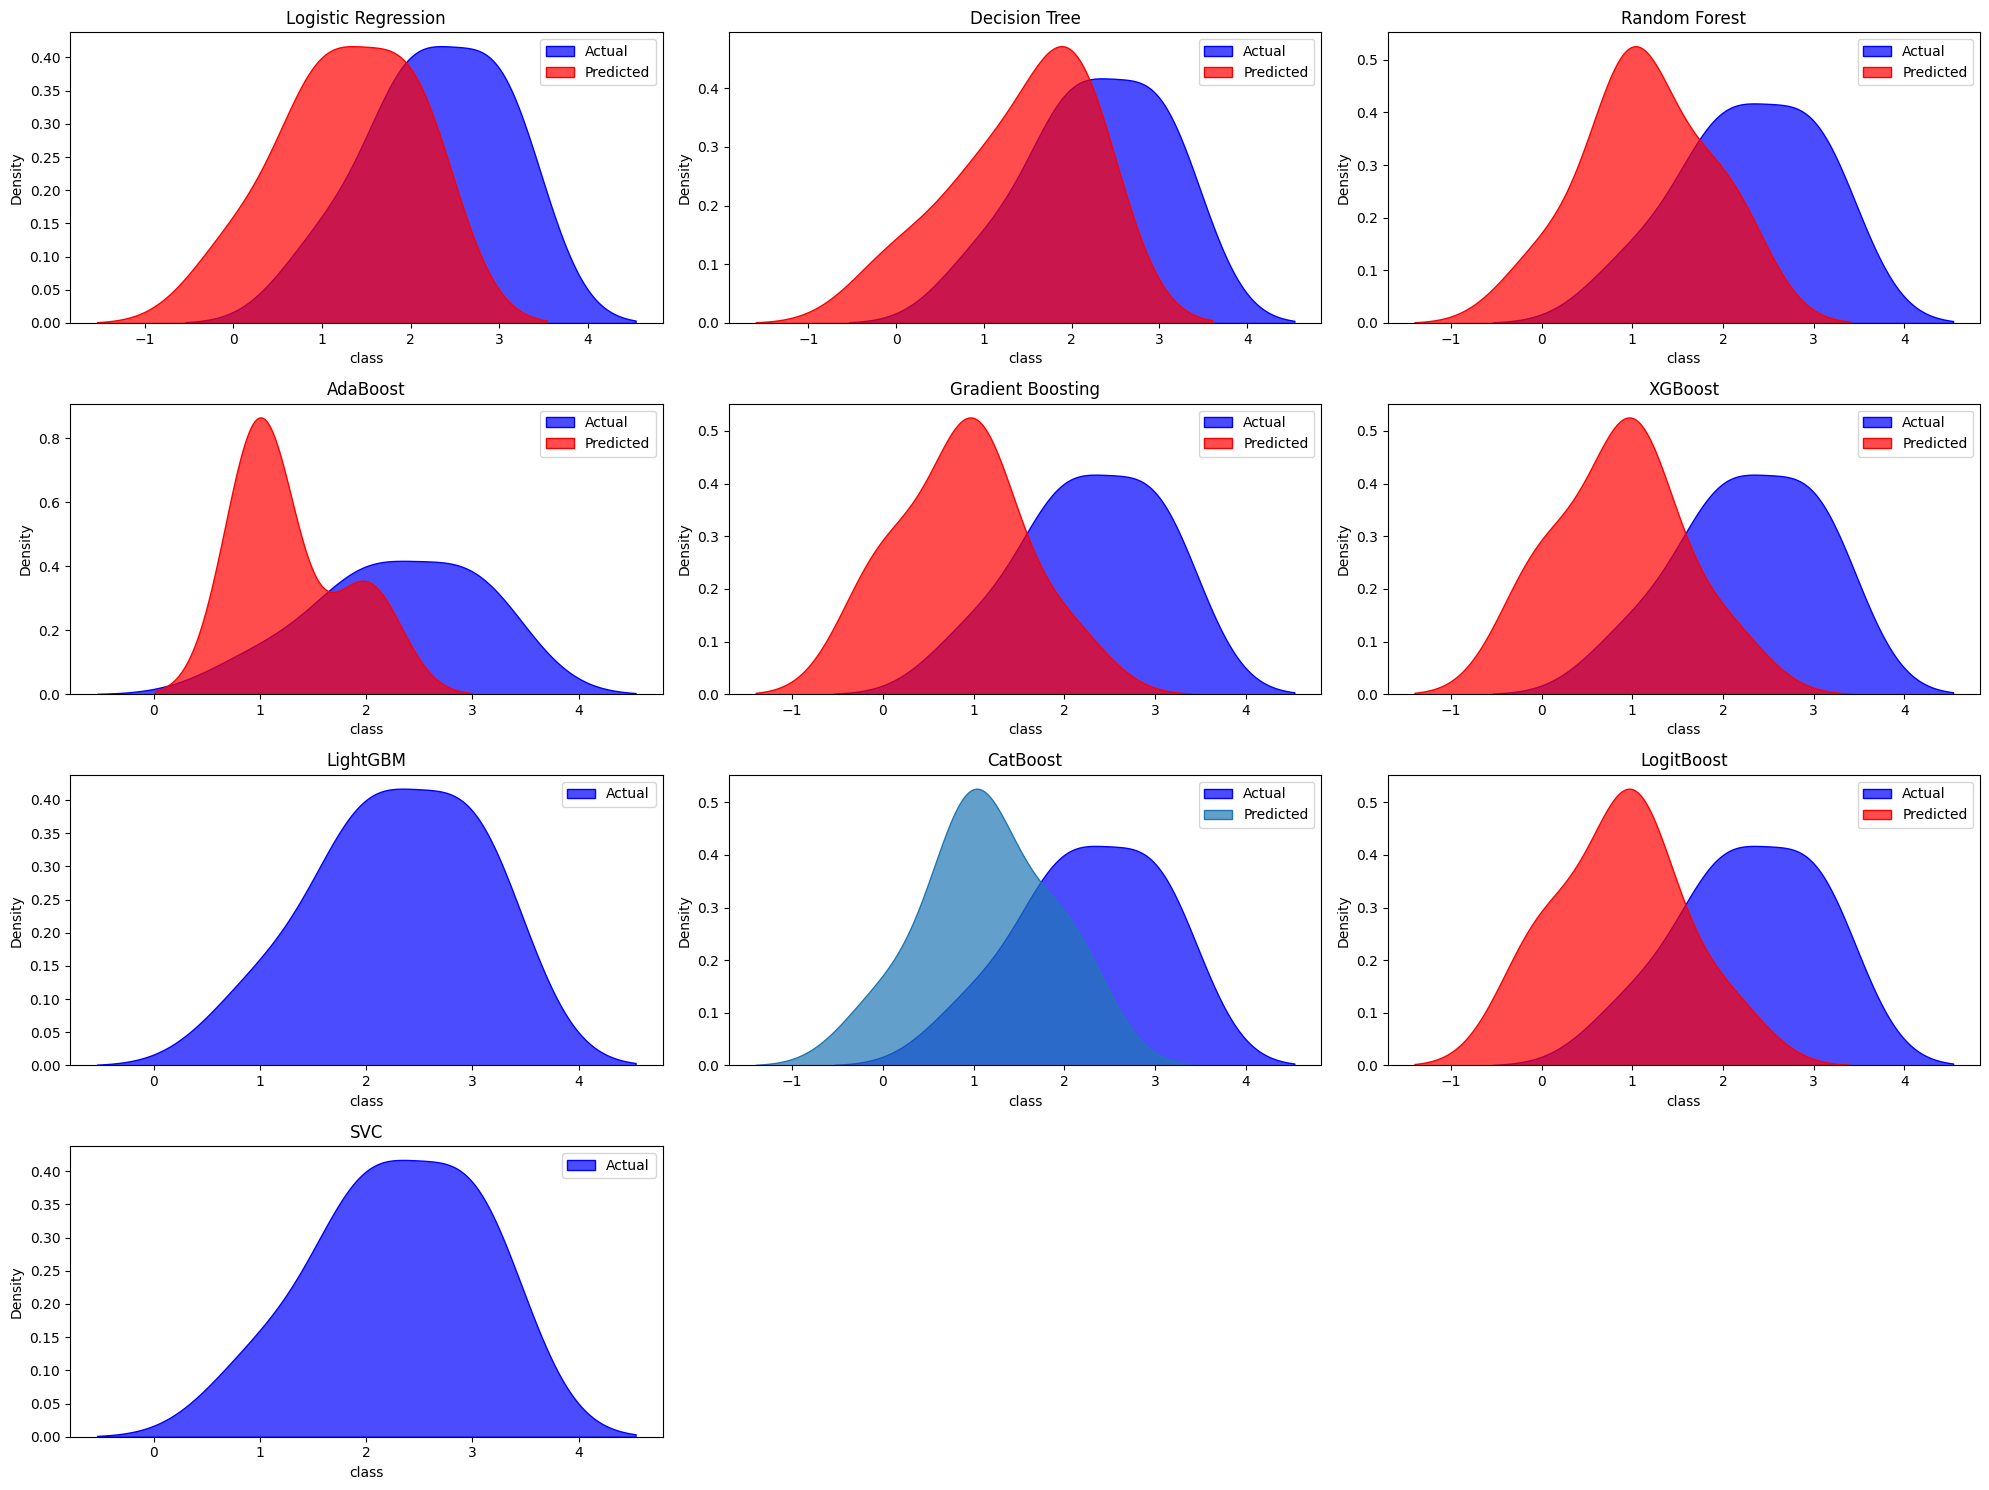

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 4x3 grid to accommodate up to 12 models
fig, ax = plt.subplots(4, 3, figsize=(20, 15))

# Flatten the axes array for easy indexing
ax = ax.flatten()

model_names = list(models.keys())

# Loop through each model and plot the actual vs. predicted distributions
for i, name in enumerate(model_names):
    if i < len(ax):  # Ensure we do not exceed available axes
        # Plot actual vs predicted distributions with distinct colors and transparency
        sns.kdeplot(y_test, ax=ax[i], label='Actual', color='blue', alpha=0.7, fill=True)
        sns.kdeplot(predictions[name], ax=ax[i], label='Predicted', color='red', alpha=0.7, fill=True)
        ax[i].set_title(name)
        ax[i].legend()

# Hide any unused subplots (since we may have fewer models than grid slots)
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


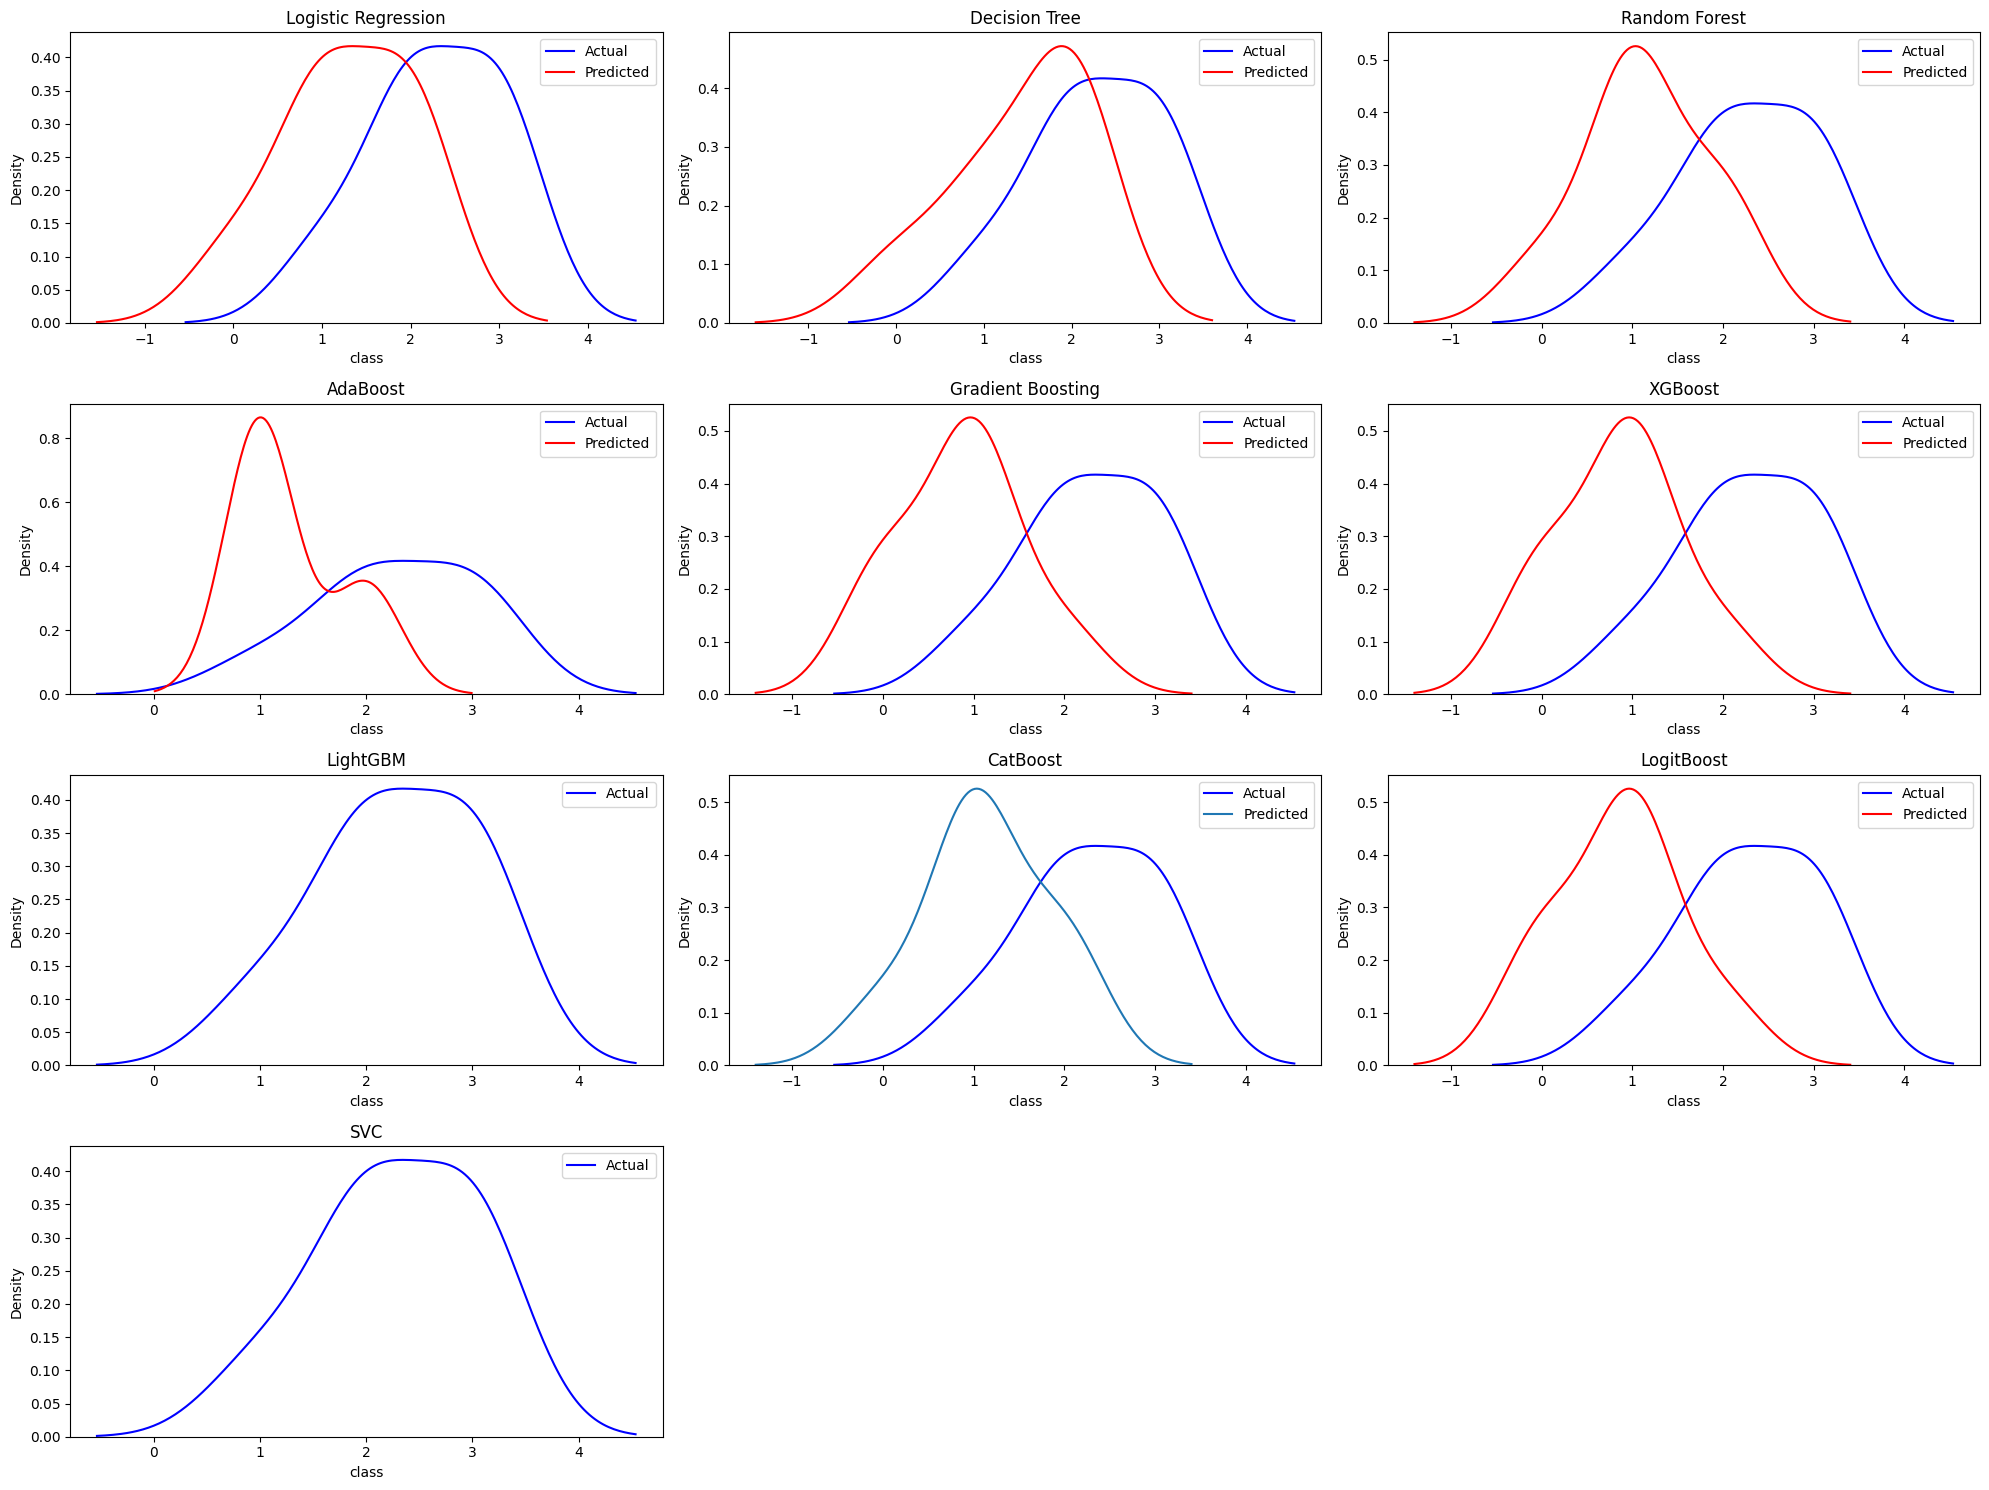

In [261]:
# Create a 4x3 grid to accommodate 10 models
fig, ax = plt.subplots(4, 3, figsize=(20, 15))

# Flatten the axes array for easy indexing
ax = ax.flatten()

model_names = list(models.keys())

# Loop through each model and plot the actual vs. predicted distributions
for i, name in enumerate(model_names):
    sns.kdeplot(y_test, ax=ax[i], label='Actual', color='blue')
    sns.kdeplot(predictions[name], ax=ax[i], label='Predicted', color='red')
    ax[i].set_title(name)
    ax[i].legend()

# Hide any unused subplots (since we only have 10 models but a 12 subplot grid)
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

##6.Conclusion

**Random Forest** and **CatBoost** both have the highest accuracy (0.571429), precision (0.666667), recall (0.666667), and F1 score (0.657143), indicating that they are the best-performing models in this comparison.

